In [3]:
#imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from collections import defaultdict
from datetime import datetime
%matplotlib inline
# Las graficas en formato retina son más legibles
%config InlineBackend.figure_format = 'retina'
sns.set(rc={'figure.figsize':(11.7,8.27)})
import warnings
warnings.filterwarnings('ignore')


In [4]:
#importar CSV. Concatenamos todos los csv del escenario en un dataframe.

path=r"C:\Users\White\Desktop\tfg\InSDN_DatasetCSV"
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join(path, "*.csv"))),ignore_index=True)
#Reindexamos el dataframe tras la concatenacion
df =df.reindex()
df=df.drop("Flow ID", axis=1)
##Creacion de una feature que refleje mejor nuestros objetivos.
#Esta feature refleja si el flujo es un ataque o no, sin meterse en el tipo de ataque

df['LabelA'] = (df['Label'] !="Normal").astype(int)

#Y aqui creamos una feature equivalente pero mas verbosa, para poder verlo de forma mas legible, simplemente por comodidad.
df['LabelN'] = (df['LabelA'])
dct = {0: "Normal", 1: "Attack"}
df=df.replace({"LabelN": dct})

In [5]:
#Imprimimos la relacion de features completas de la concatenación de escenarios
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343889 entries, 0 to 343888
Data columns (total 85 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Src IP             343889 non-null  object 
 1   Src Port           343889 non-null  int64  
 2   Dst IP             343889 non-null  object 
 3   Dst Port           343889 non-null  int64  
 4   Protocol           343889 non-null  int64  
 5   Timestamp          343889 non-null  object 
 6   Flow Duration      343889 non-null  int64  
 7   Tot Fwd Pkts       343889 non-null  int64  
 8   Tot Bwd Pkts       343889 non-null  int64  
 9   TotLen Fwd Pkts    343889 non-null  float64
 10  TotLen Bwd Pkts    343889 non-null  float64
 11  Fwd Pkt Len Max    343889 non-null  int64  
 12  Fwd Pkt Len Min    343889 non-null  int64  
 13  Fwd Pkt Len Mean   343889 non-null  float64
 14  Fwd Pkt Len Std    343889 non-null  float64
 15  Bwd Pkt Len Max    343889 non-null  int64  
 16  Bw

# Comprobamos si tenemos valores faltantes en los datos

In [6]:
# Número de datos faltantes en cada feature
miss = pd.DataFrame(df.isnull().sum()).rename(columns = {0: 'total'})

# En porcentaje
miss['percent'] = miss['total'] / len(df)

miss.sort_values('percent', ascending = False).head(10)


total  percent
Src IP                0      0.0
CWE Flag Count        0      0.0
Fwd Blk Rate Avg      0      0.0
Fwd Pkts/b Avg        0      0.0
Fwd Byts/b Avg        0      0.0
Bwd Seg Size Avg      0      0.0
Fwd Seg Size Avg      0      0.0
Pkt Size Avg          0      0.0
Down/Up Ratio         0      0.0
ECE Flag Cnt          0      0.0

In [7]:
# Número de valores negativos en cada columna

negative = pd.DataFrame(df.select_dtypes(np.number).lt(0).sum()).rename(columns = {0: 'total'})

# Creando un porcentaje 
negative['percent'] = negative['total'] / len(df)

negative.sort_values('percent', ascending = False).head(11)


total   percent
Init Fwd Win Byts  343889  1.000000
Init Bwd Win Byts  155865  0.453242
Flow IAT Min         7799  0.022679
Bwd IAT Min            13  0.000038
Bwd IAT Tot             9  0.000026
Bwd IAT Mean            9  0.000026
Bwd IAT Max             9  0.000026
Flow Duration           8  0.000023
Flow IAT Max            8  0.000023
Flow IAT Mean           8  0.000023
Flow Pkts/s             8  0.000023

In [8]:
#Eliminamos las dos primeras features ya que son completamente erroneas
df=df.drop("Init Fwd Win Byts", axis=1)
df=df.drop("Init Bwd Win Byts", axis=1)


In [9]:
# Eliminamos el pequeño número de muestras negativas
# Número de valores negativos en cada columna

negative = pd.DataFrame(df.select_dtypes(np.number).lt(0).sum()).rename(columns = {0: 'total'})

# Creando un porcentaje 
negative['percent'] = negative['total'] / len(df)

negativec = negative[ negative['percent'] >0 ]

for col in (negativec.index):
    indexNames = df[ df[col] <0 ].index
    df.drop(indexNames , inplace=True)




In [10]:
#Nuevo numero de muestras
df.shape[0]

336090

In [11]:
#Comprobamos la distribución
def calc_prevalence(y):
    return (sum(y)/len(y))
calc_prevalence(df["LabelA"])

0.819408491773037

La distribucion es de un 80% de ataques y un 20% de trafico normal

# Buscamos filas duplicadas y columnas cuyos valores que no cambian


In [12]:
#print(df.drop_duplicates())
df = df.drop_duplicates()

In [13]:
#Columnas que solo tienen 1 valor
nunique = df.nunique()
cols_to_drop = nunique[nunique == 1].index
print(cols_to_drop)

Index(['Fwd PSH Flags', 'Fwd URG Flags', 'CWE Flag Count', 'ECE Flag Cnt',
       'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg',
       'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg',
       'Fwd Seg Size Min'],
      dtype='object')


In [14]:
df=df.drop(cols_to_drop, axis=1)
print((df != 0).any(axis=0))

Src IP      True
Src Port    True
Dst IP      True
Dst Port    True
Protocol    True
            ... 
Idle Max    True
Idle Min    True
Label       True
LabelA      True
LabelN      True
Length: 72, dtype: bool


## A continuacion procedemos al analisis de Features:

### Analisis de la feature Src IP & Dst IP:


In [15]:
df["Src IP"].nunique()

122861

##### Src IP y Dst IP son variables categoricas, pero con un elevado numero de valores unicos.

Para el analisis, se ha considerado interesante abordar una agrupacion de los valores siguiendo la estructura de la red.

Asi pues, tenemos las categorias controlador, docker,  red OVS y Mininet para el trafico de nuestra red y "outside" para la kali y cualquier otra IP que no pertenezca a las conocidas.

##### Si bien se ha considerado en un principio el docker de forma individual, al ver el poco trafico que tiene (no llega a las 3 cifras ) , se ha introducido en el OVS para simplificar las graficas.

In [16]:

kwargs = {'192.168.8.128': "Src_Controller",
          '172.17.0.1': "Src_OVS",'172.17.0.2': "Src_OVS" ,'200.175.2.129': "Src_OVS",'192.168.3.129': "Src_OVS" ,'192.168.20.129': "Src_OVS",
          '200.175.2.130': "Src_Outside",
          '192.168.3.130': "Src_Metasploitable",
          '192.168.20.131': "Src_Mininet",'192.168.20.132': "Src_Mininet",'192.168.20.133': "Src_Mininet",'192.168.20.134': "Src_Mininet", "192.168.20.2": "Src_Mininet"}

df['Src Host'] = df['Src IP']
df['Src Host'] = df['Src Host'].map(kwargs).fillna("Src_Outside").astype(str)

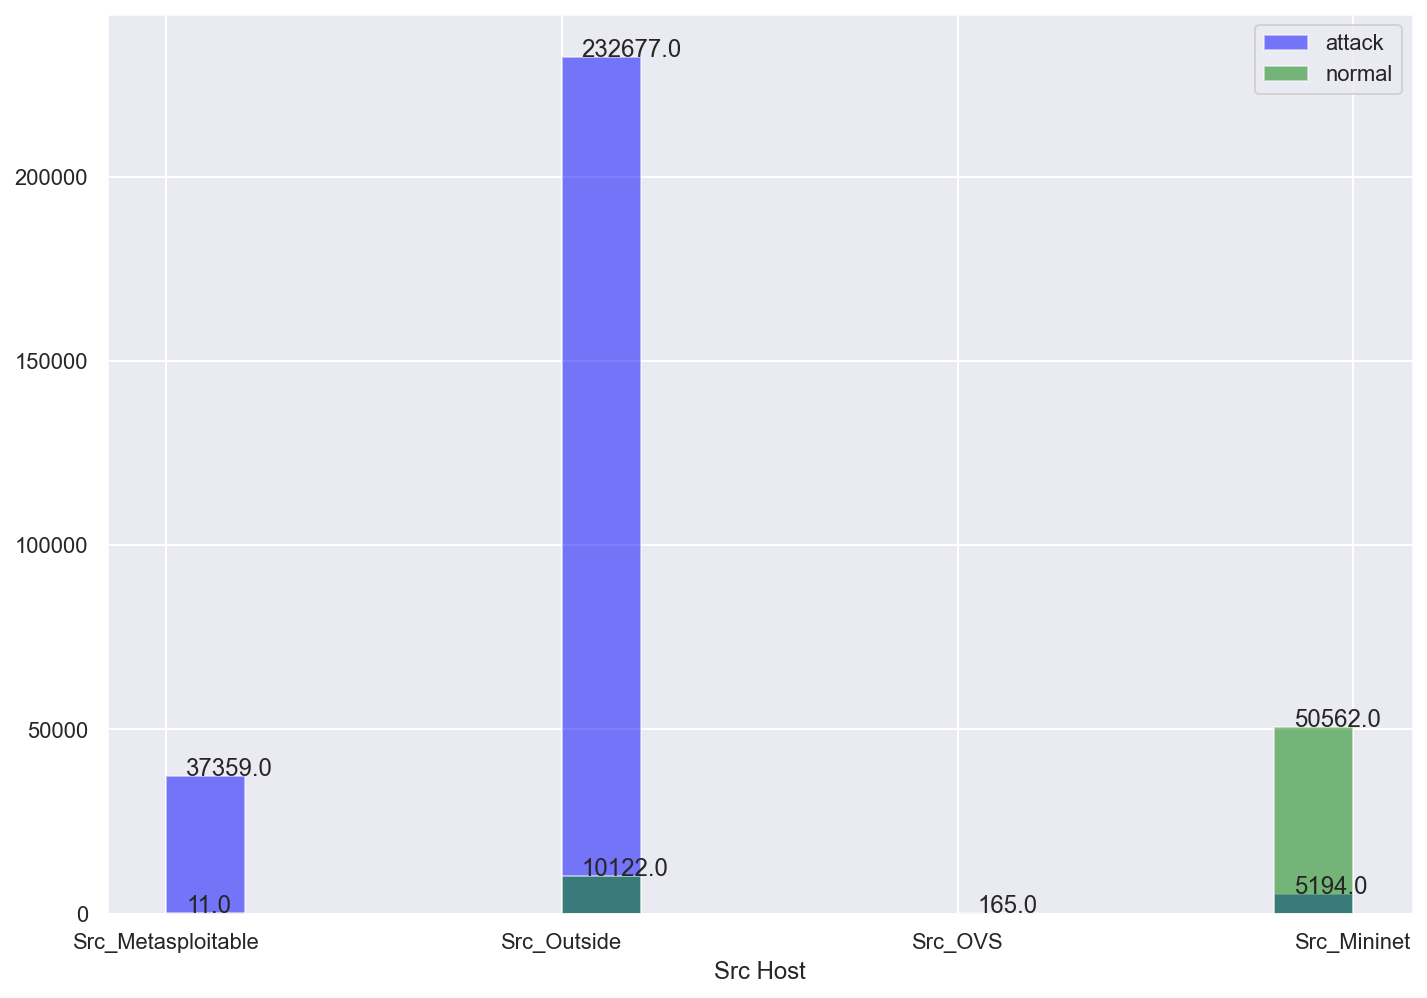

In [17]:
i='Src Host'

fig, ax = plt.subplots()

ax.hist(df[df["LabelA"]==1][i], bins=15, alpha=0.5, color="blue", label="attack")
ax.hist(df[df["LabelA"]==0][i], bins=15, alpha=0.5, color="green", label="normal")

ax.set_xlabel(i)
for p in ax.patches:
        if p.get_height()>0:
            ax.annotate((p.get_height()), (p.get_x()+0.05, p.get_height()+50))

ax.legend();

#### La gran mayoria de flujos procedentes de metasploitable son parte de ataques
#### La gran mayoria de flujos procedentes de fuera son ataques (Estamos incluyendo a la Kali aqui)
#### La gran mayoria de flujos procedentes de la Mininet son trafico normal.

### Analisis de la feature Dst IP:


In [18]:

kwargs = {'192.168.8.128': "Dst_Controller",
          '172.17.0.1': "Dst_OVS",'172.17.0.2': "Dst_OVS" ,'200.175.2.129': "Dst_OVS",'192.168.3.129': "Dst_OVS" ,'192.168.20.129': "Dst_OVS",
          '200.175.2.130': "Dst_Outside",
          '192.168.3.130': "Dst_Metasploitable",
          '192.168.20.131': "Dst_Mininet",'192.168.20.132': "Dst_Mininet",'192.168.20.133': "Dst_Mininet",'192.168.20.134': "Dst_Mininet", "192.168.20.2": "Dst_Mininet"}

df['Dst Host'] = df['Dst IP']
df['Dst Host'] = df['Dst Host'].map(kwargs).fillna("Dst_Outside").astype(str)

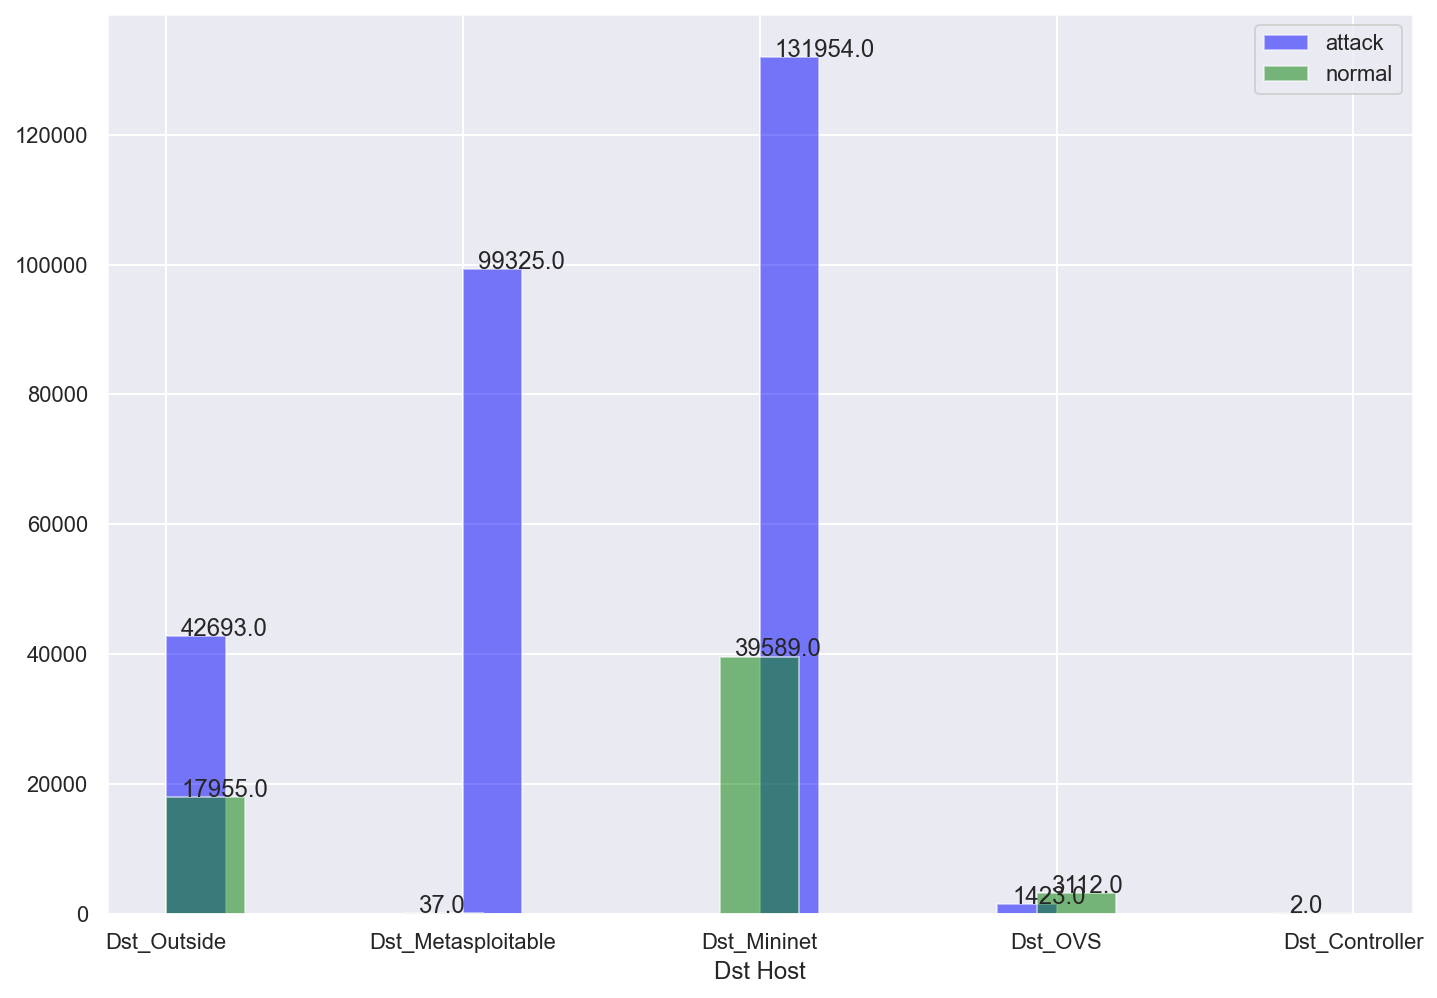

In [19]:
i='Dst Host'

fig, ax = plt.subplots()

ax.hist(df[df["LabelA"]==1][i], bins=15, alpha=0.5, color="blue", label="attack")
ax.hist(df[df["LabelA"]==0][i], bins=15, alpha=0.5, color="green", label="normal")

ax.set_xlabel(i)
for p in ax.patches:
        if p.get_height()>0:
            ax.annotate((p.get_height()), (p.get_x()+0.05, p.get_height()+50))
ax.legend();

#### La gran mayoria de flujos destinados a metasploitable son parte de ataques

# Analisis de cada una de las maquinas de Mininet

In [20]:
kwargs = {'192.168.8.128': "Inside",
          '172.17.0.1': "Inside",'172.17.0.2': "Inside" ,'200.175.2.129': "Inside",'192.168.3.129': "Inside" ,'192.168.20.129': "Inside",
          '200.175.2.130': "Outside",
          '192.168.3.130': "Metasploitable",
          '192.168.20.131': "Mininet 1",'192.168.20.132': "Mininet 2",'192.168.20.133': "Mininet 3",'192.168.20.134': "Mininet 4", "192.168.20.2": "Mininet 5"}

df['Dst HostM'] = df['Dst IP']
df['Dst HostM'] = df['Dst HostM'].map(kwargs).fillna("Outside").astype(str)

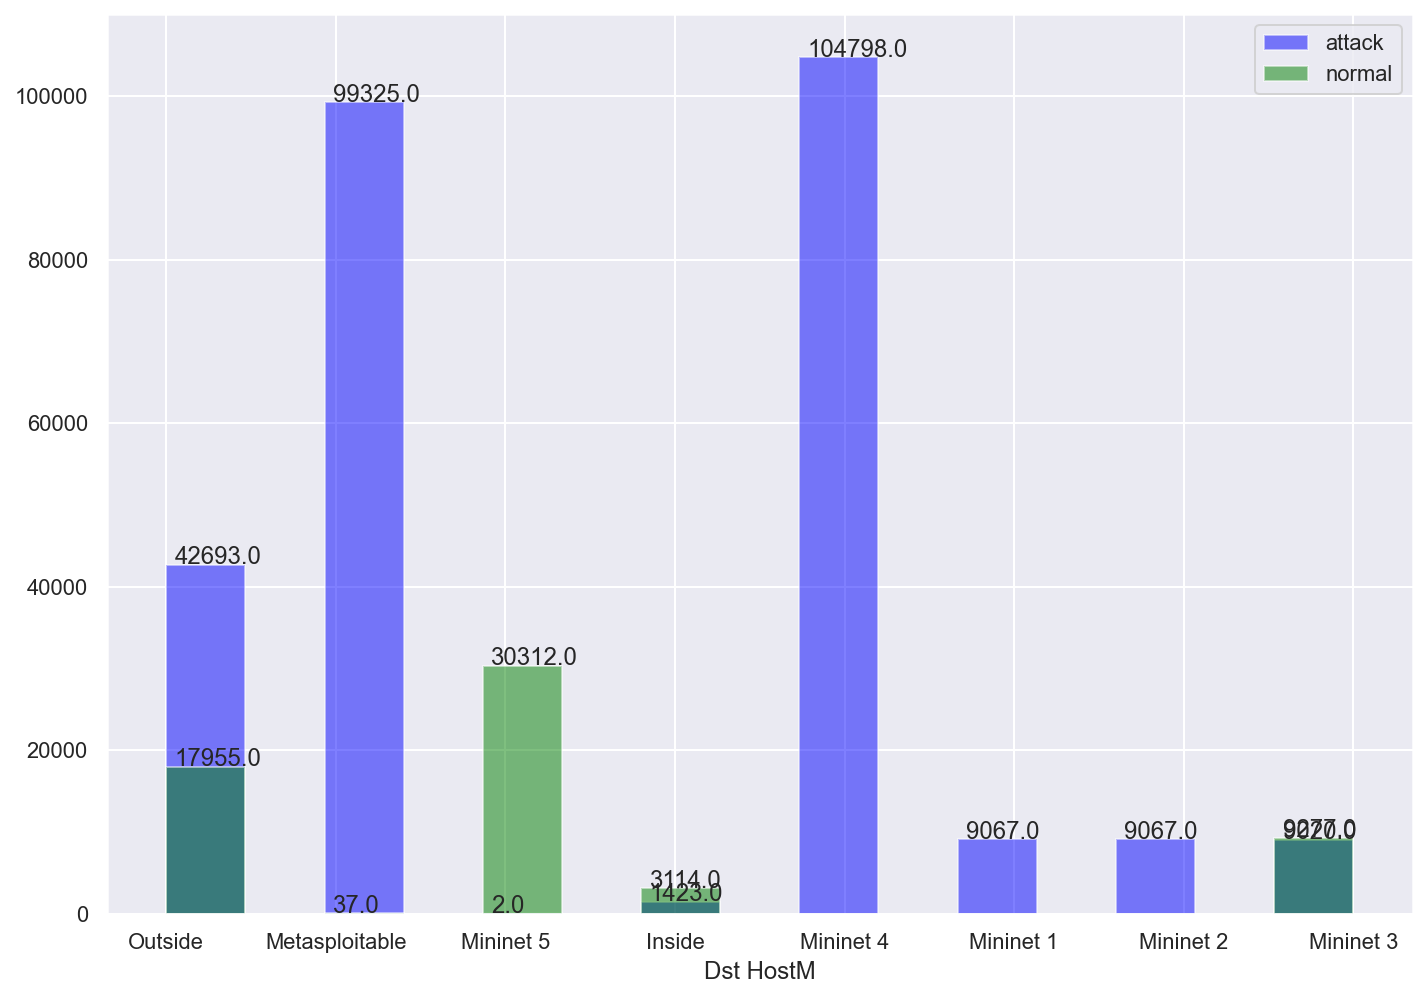

In [21]:
i='Dst HostM'

fig, ax = plt.subplots()

ax.hist(df[df["LabelA"]==1][i], bins=15, alpha=0.5, color="blue", label="attack")
ax.hist(df[df["LabelA"]==0][i], bins=15, alpha=0.5, color="green", label="normal")

ax.set_xlabel(i)
for p in ax.patches:
        if p.get_height()>0:
            ax.annotate((p.get_height()), (p.get_x()+0.05, p.get_height()+50))

ax.legend();

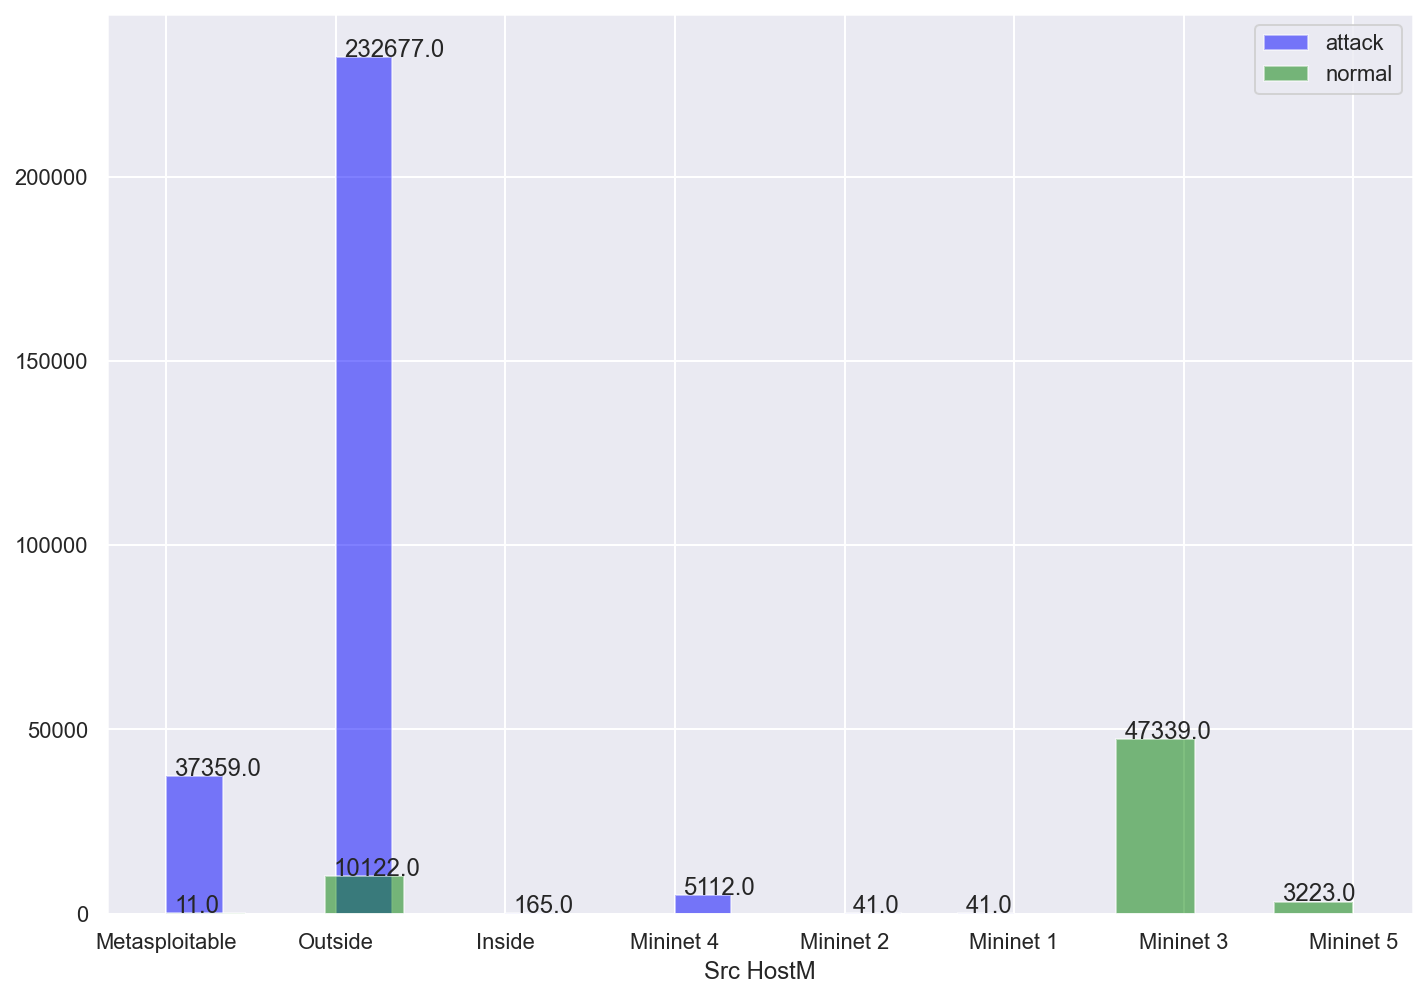

In [22]:
kwargs = {'192.168.8.128': "Inside",
          '172.17.0.1': "Inside",'172.17.0.2': "Inside" ,'200.175.2.129': "Inside",'192.168.3.129': "Inside" ,'192.168.20.129': "Inside",
          '200.175.2.130': "Outside",
          '192.168.3.130': "Metasploitable",
          '192.168.20.131': "Mininet 1",'192.168.20.132': "Mininet 2",'192.168.20.133': "Mininet 3",'192.168.20.134': "Mininet 4", "192.168.20.2": "Mininet 5"}

df['Src HostM'] = df['Src IP']
df['Src HostM'] = df['Src HostM'].map(kwargs).fillna("Outside").astype(str)

i='Src HostM'

fig, ax = plt.subplots()

ax.hist(df[df["LabelA"]==1][i], bins=15, alpha=0.5, color="blue", label="attack")
ax.hist(df[df["LabelA"]==0][i], bins=15, alpha=0.5, color="green", label="normal")

ax.set_xlabel(i)
for p in ax.patches:
        if p.get_height()>0:
            ax.annotate((p.get_height()), (p.get_x()+0.05, p.get_height()+50))

ax.legend();

In [23]:
#Seria demasiado sobreajustar mirar cada uno de los hosts de mininet? Al fin y al cabo se describen como 4 hosts iguales

## Analisis de los flujos con respecto a Source y Destination


In [24]:
df1=df[(df["Src Host"] == 'Src_Outside') & (df["Dst Host"] == "Dst_Metasploitable")]
df1["Type"]=df1["Type"].values[:] = "O>Me"

df2=df[(df["Src Host"] == 'Src_Outside') & (df["Dst Host"] == "Dst_Mininet")]
df2["Type"]=df2["Type"].values[:] = "O>Mi"

#
df3=df[(df["Src Host"] == 'Src_Metasploitable') & (df["Dst Host"] == "Dst_Outside")]
df3["Type"]=df3["Type"].values[:] = "Me>O"

df4=df[(df["Src Host"] == 'Src_Metasploitable') & (df["Dst Host"] == "Dst_Mininet")]
df4["Type"]=df4["Type"].values[:] = "Me>Mi"

#
df5=df[(df["Src Host"] == 'Src_Mininet') & (df["Dst Host"] == "Dst_Metasploitable")]
df5["Type"]=df5["Type"].values[:] = "Mi>Me"

df6=df[(df["Src Host"] == 'Src_Mininet') & (df["Dst Host"] == "Dst_Outside")]
df6["Type"]=df6["Type"].values[:] = "Mi>O"


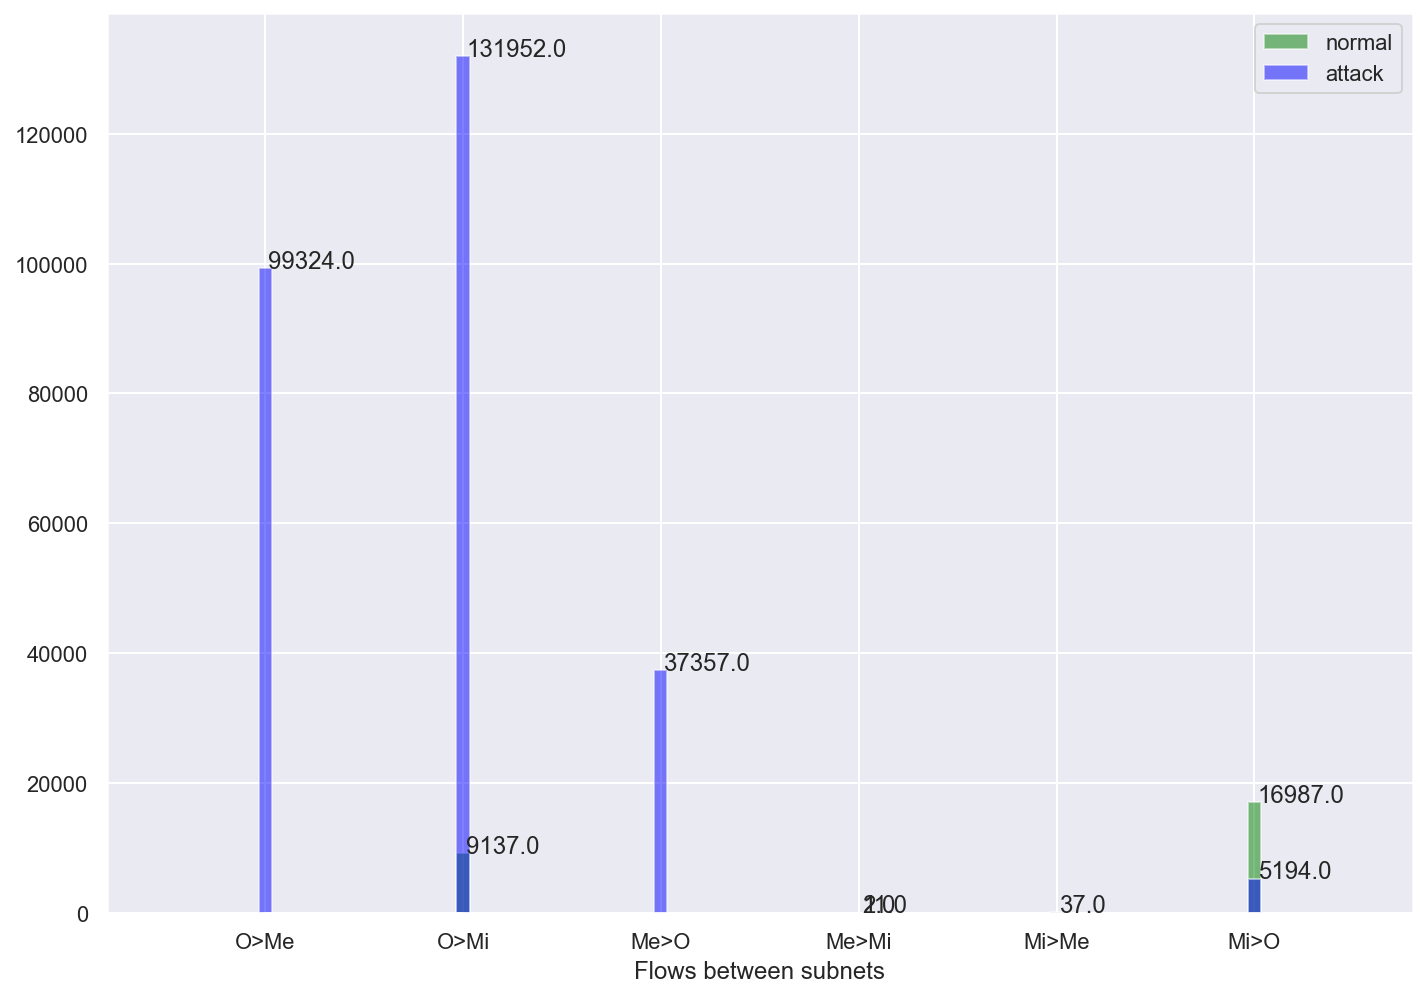

In [25]:
i="Type"
fig, ax = plt.subplots()

ax.hist(df1[df1["LabelA"]==0][i], bins=15, alpha=0.5, color="green", label="normal")
ax.hist(df1[df1["LabelA"]==1][i], bins=15, alpha=0.5, color="blue", label="attack")

ax.hist(df2[df2["LabelA"]==0][i], bins=15, alpha=0.5, color="green")
ax.hist(df2[df["LabelA"]==1][i], bins=15, alpha=0.5, color="blue")

ax.hist(df3[df3["LabelA"]==0][i], bins=15, alpha=0.5, color="green")
ax.hist(df3[df3["LabelA"]==1][i], bins=15, alpha=0.5, color="blue")

ax.hist(df4[df4["LabelA"]==0][i], bins=15, alpha=0.5, color="green")
ax.hist(df4[df4["LabelA"]==1][i], bins=15, alpha=0.5, color="blue")

ax.hist(df5[df5["LabelA"]==0][i], bins=15, alpha=0.5, color="green")
ax.hist(df5[df5["LabelA"]==1][i], bins=15, alpha=0.5, color="blue")

ax.hist(df6[df6["LabelA"]==0][i], bins=15, alpha=0.5, color="green")
ax.hist(df6[df6["LabelA"]==1][i], bins=15, alpha=0.5, color="blue")

ax.set_xlabel("Flows between subnets")
for p in ax.patches:
        if p.get_height()>0:
            ax.annotate((p.get_height()), (p.get_x()+0.05, p.get_height()+50))
ax.legend();

### La mayoria del trafico que entra o sale de la metasploitable es un ataque. La metasploitable apenas se comunica con algo que no este en el exterior.
La mininet se comunica mayormente con el exterior. Le llegan mayormente ataques y manda mayormente trafico normal

## Analisis de cada una de las maquinas de mininet:

# Analisis del timestamp

In [26]:
#Convertimos a datetime el timestamp para poder trabajar con el.
df['Datetime'] = pd.to_datetime(df['Timestamp'])

assert df.Datetime.isnull().sum() == 0, "missing Datetime dates"

In [27]:
#Extraemos el día y el mes
df['DayName'] = df['Datetime'].dt.day_name()
df["day"]= df['Datetime'].dt.day
df["Month"]= df['Datetime'].dt.month
# Creamos un nuevo atributo que refleja si es o no fin de semana
dct = {'Saturday': 1,'Sunday': 1 ,'Monday': 0,'Thursday': 0 ,'Wednesday': 0 ,'Tuesday': 0 ,'Friday': 0}
df['Weekend'] = df['DayName']
df=df.replace({"Weekend": dct})
#Creamos dos atributos horarios nuevos que contienen la hora y el minuto
df["Hour"]=df["Datetime"].dt.hour
df["Minute"]=df["Datetime"].dt.minute

Comprobamos si tenemos suficientes muestras

In [28]:
df.groupby("Hour").size()

Hour
0         2
1      1401
3         3
4         3
5     73532
11       49
12    13860
13    49288
14    16949
15    51985
16    63191
17    49891
18     7054
19     4742
20       37
21        1
22      209
23     3893
dtype: int64

In [29]:
df.groupby("DayName").size()

DayName
Friday        48363
Saturday      39534
Thursday     179138
Tuesday       64765
Wednesday      4290
dtype: int64

In [30]:
df.groupby("Month").size()

Month
1      4098
4     55741
5     39534
7     13186
9     62845
10    73839
12    86847
dtype: int64

Comprobamos si el ser fin de semana o no es predictivo de ataque

In [31]:
df.groupby("Weekend").apply(lambda g: calc_prevalence(g.LabelA.values))

Weekend
0    0.928644
1    0.000000
dtype: float64

Con bastante claridad, durante el fin de semana no hay ni un solo ataque


### Segun si el dia es de semana o no

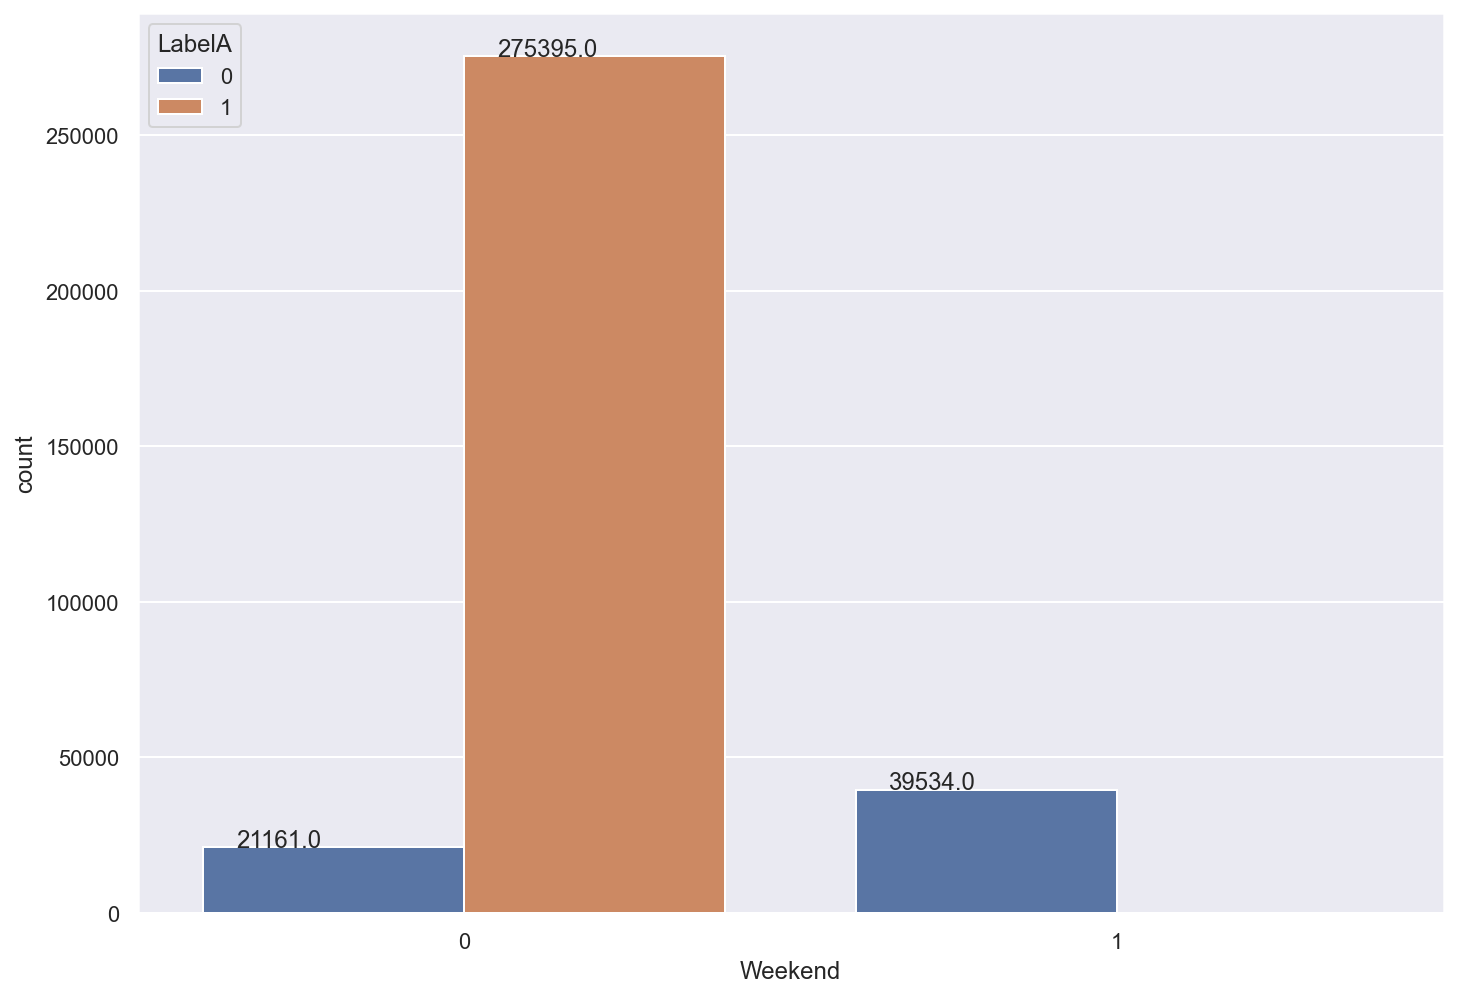

In [32]:
ax = sns.countplot(x='Weekend', hue="LabelA",data=df);
for p in ax.patches:
    if p.get_height()>0:
        ax.annotate((p.get_height()), (p.get_x()+0.05, p.get_height()+50))


### Los ataques ocurren durante la semana

In [33]:
df1=df[(df["DayName"] == 'Tuesday')]
df2=df[(df["DayName"] == 'Wednesday')]
df3=df[(df["DayName"] == 'Thursday')]
df4=df[(df["DayName"] == 'Friday')]
df5=df[(df["DayName"] == 'Saturday')]


Buscando patrones de ataque horarios en cada dia

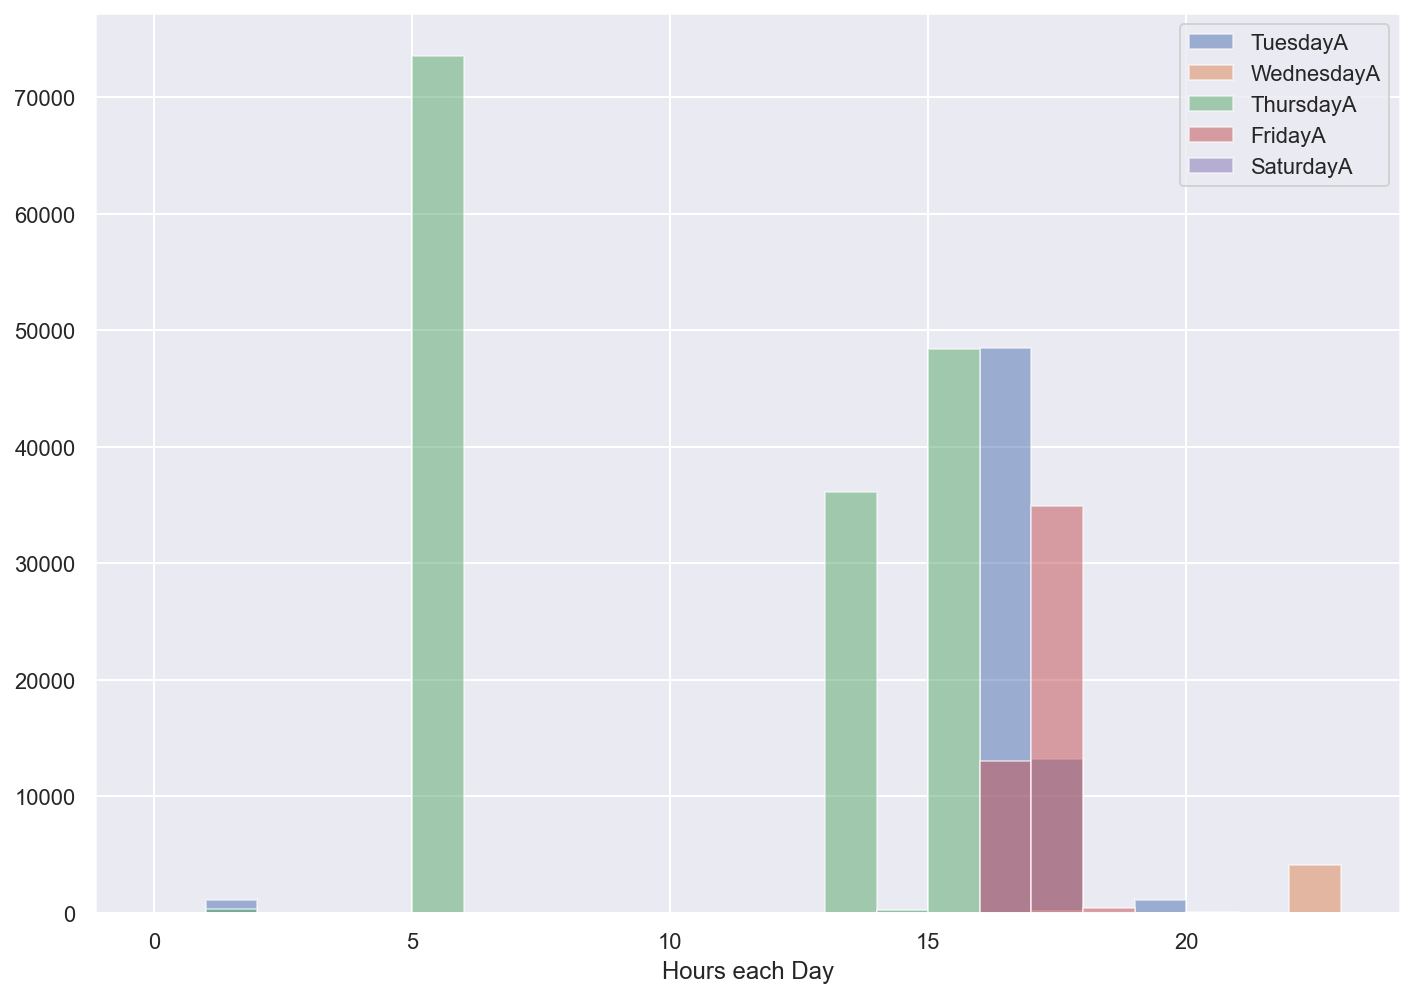

In [34]:
i="Hour"
fig, ax = plt.subplots()


plt.hist(df1[df1["LabelA"]==1][i], alpha=0.5, bins = range(0,24,1),  label="TuesdayA")
plt.hist(df2[df2["LabelA"]==1][i], alpha=0.5, bins = range(0,24,1), label="WednesdayA")
plt.hist(df3[df3["LabelA"]==1][i], alpha=0.5, bins = range(0,24,1),  label="ThursdayA")
plt.hist(df4[df4["LabelA"]==1][i], alpha=0.5, bins = range(0,24,1),  label="FridayA")
plt.hist(df5[df5["LabelA"]==1][i], alpha=0.5, bins = range(0,24,1), label="SaturdayA")
ax.set_xlabel("Hours each Day")
ax.legend();


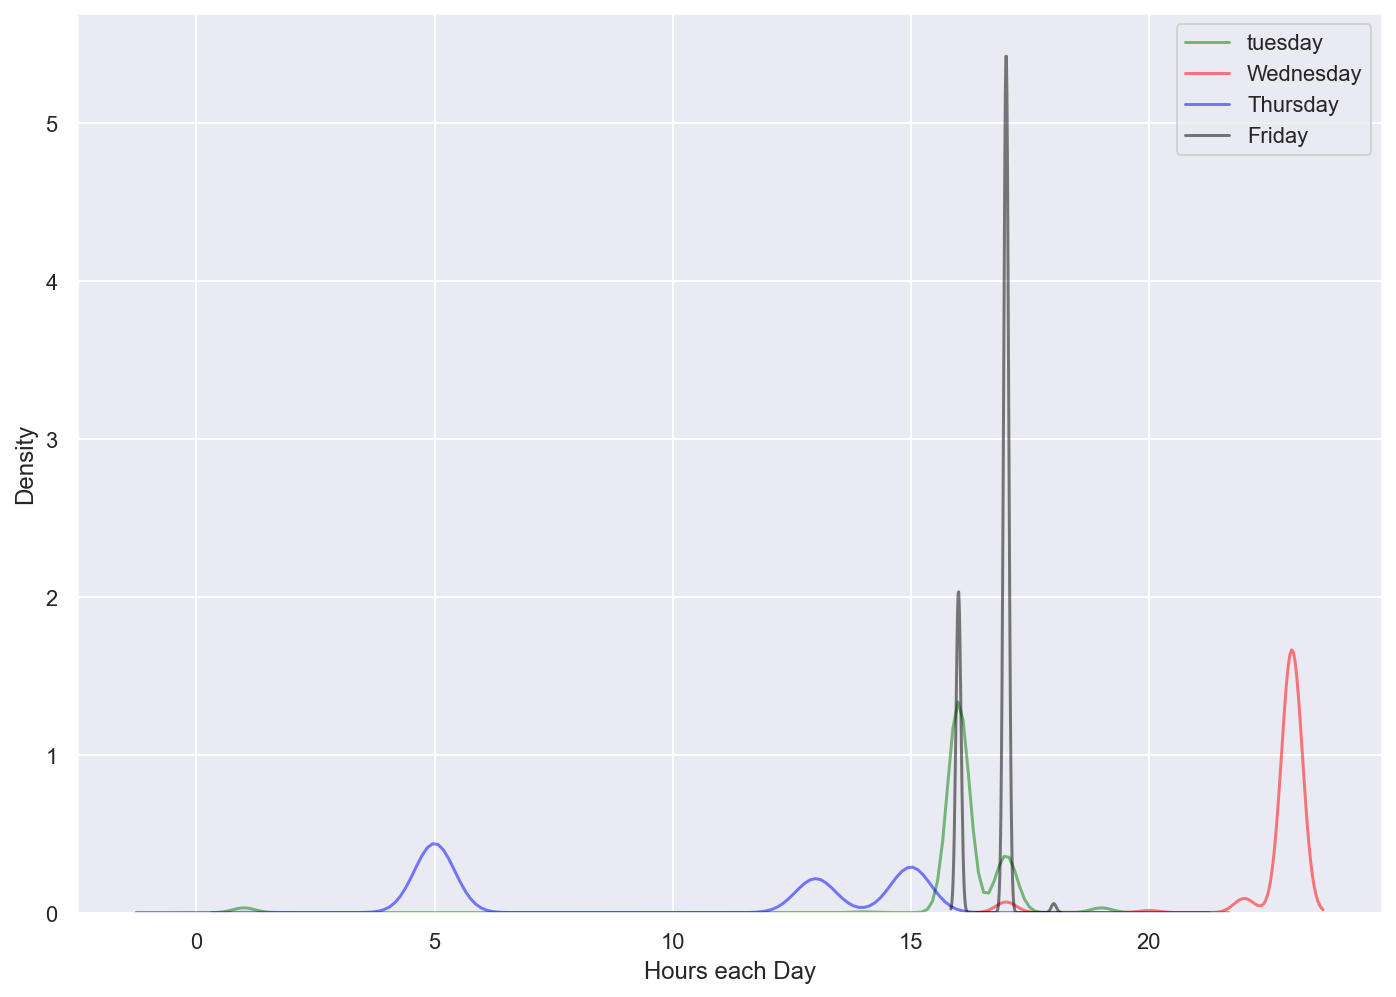

In [35]:
i="Hour"
fig, ax = plt.subplots()


sns.kdeplot(df1[df1["LabelA"]==1][i], alpha=0.5, color="green", label="tuesday", ax=ax)
sns.kdeplot(df2[df2["LabelA"]==1][i], alpha=0.5, color="red", label="Wednesday", ax=ax)
sns.kdeplot(df3[df3["LabelA"]==1][i], alpha=0.5, color="blue", label="Thursday", ax=ax)
sns.kdeplot(df4[df4["LabelA"]==1][i], alpha=0.5, color="black", label="Friday", ax=ax)
sns.kdeplot(df5[df5["LabelA"]==1][i], alpha=0.5, color="brown", label="Saturday", ax=ax)

ax.set_xlabel("Hours each Day")
for p in ax.patches:
        if p.get_height()>0:
            ax.annotate((p.get_height()), (p.get_x()+0.05, p.get_height()+50))
ax.legend();

El tráfico normal se concentra en un intervalo horario concreto. Lo incluiremos

### Haciendo las horas ciclicas para aportar información de cercanía cíclica

In [36]:
df['hourfloat']=df["Hour"]+df["Minute"]/60.0
df['hx']=np.sin(2.*np.pi*df.hourfloat/24.)
df['hy']=np.cos(2.*np.pi*df.hourfloat/24.)

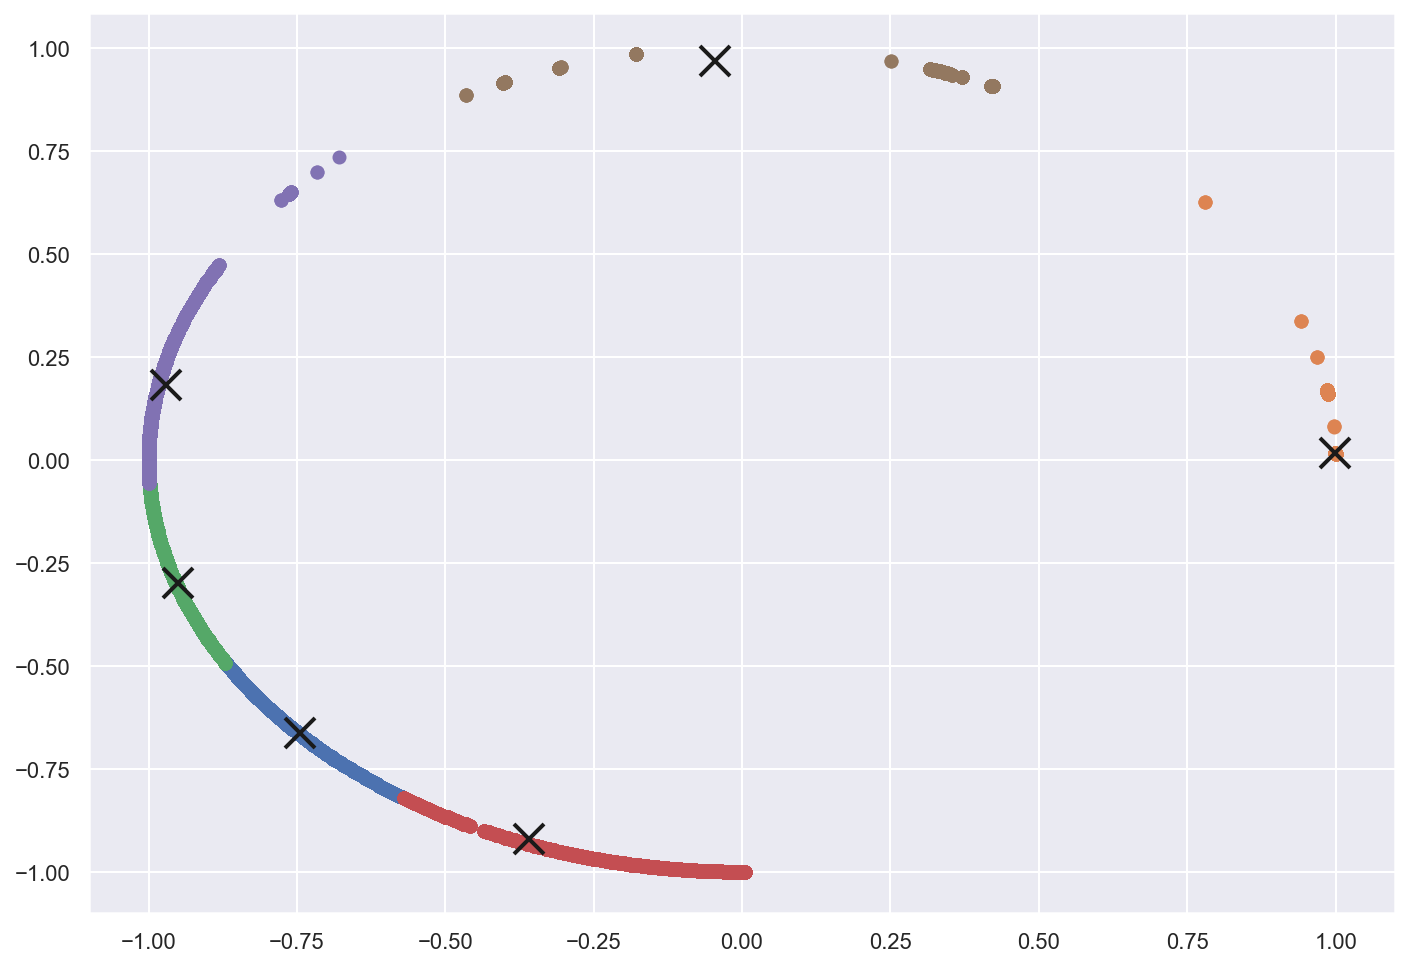

array([[-0.74556061, -0.66261563],
       [ 0.99978245,  0.01577148],
       [-0.94978079, -0.29896333],
       [-0.35879809, -0.92159649],
       [-0.97076324,  0.180609  ],
       [-0.04522695,  0.96742554]])

In [39]:
def kmeansshow(k,X):

    from sklearn import cluster
    from matplotlib import pyplot
    import numpy as np

    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(X)

    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    
    for i in range(k):
        # seleccionar muestras con cluster label == i
        ds = X[np.where(labels==i)]
        # dibujar las muestras
        pyplot.plot(ds[:,0],ds[:,1],'o')
        # dibujar los centroides
        lines = pyplot.plot(centroids[i,0],centroids[i,1],'kx')
        # destacar las X de los centroides
        pyplot.setp(lines,ms=15.0)
        pyplot.setp(lines,mew=2.0)
    pyplot.show()
    return centroids

kmeansshow(6,df[['hx', 'hy']].values)


Y ahora tenemos informacion ciclica, haciendo que las 12 y la 1 esten cerca (y las 23 y las 00, dependiendo del formato)

# Src Ports for attacks 

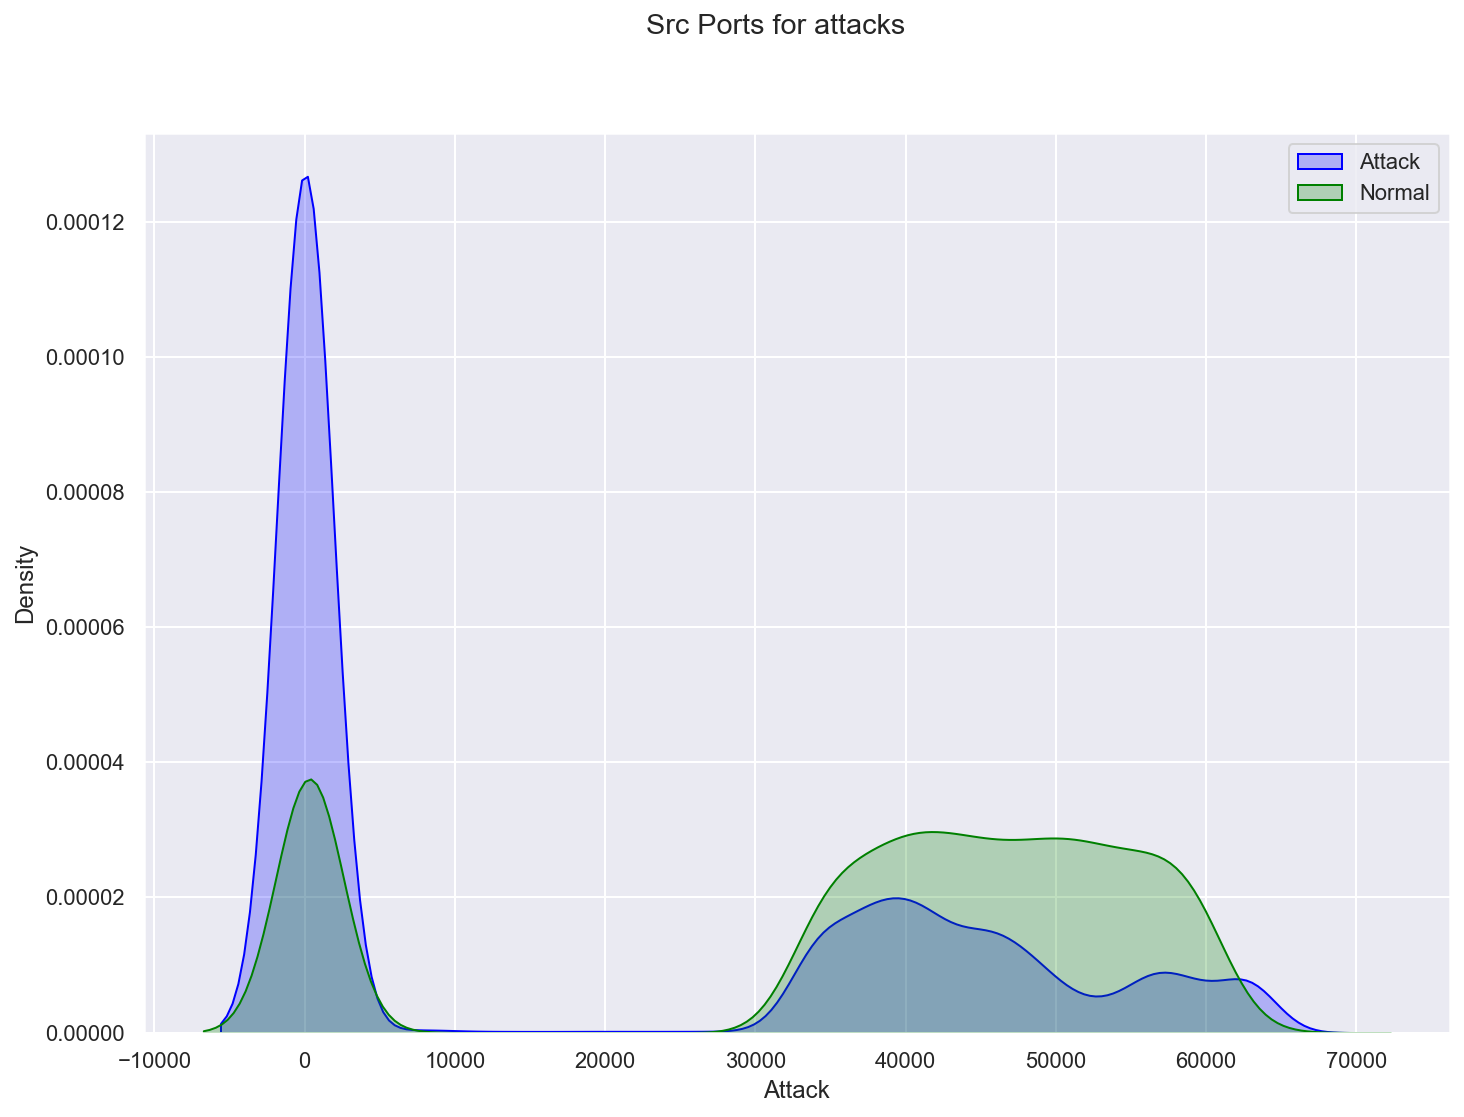

In [40]:
fig, ax = plt.subplots()

sns.kdeplot(df[df["LabelA"]==1]["Src Port"], shade=True, color="blue", label="Attack", ax=ax)
sns.kdeplot(df[df["LabelA"]==0]["Src Port"], shade=True, color="green", label="Normal", ax=ax)

ax.set_xlabel("Attack")
ax.set_ylabel("Density")


fig.suptitle("Src Ports for attacks");
ax.legend();

In [41]:
#Comprobando que no haya puertos extraños fuera de rango
for p in (df["Src Port"].unique()):
    if p>65535:
        print (p)
        
for p in (df["Dst Port"].unique()):
    if p>65535:
        print (p)        

In [42]:
criteria = [df['Src Port']==0, df['Src Port']==53,df['Src Port']==80,df['Src Port']==443,df['Src Port'].between(1058, 49151), df['Src Port'].between(49152, 65535)]
values = ["Src_0","Src_DNS","Src_HTTP","Src_HTTPS", "Src_Registered", "Src_Ephemeral"]

df['Src Port Grp'] = np.select(criteria, values)

In [43]:
df0=df[(df["Src Port Grp"] =="0")]
df0[["Src Port","Src Port Grp"]]
df0["Src Port"].value_counts()


137    68
138    42
23      2
22      2
514     1
227     1
111     1
512     1
513     1
25      1
354     1
445     1
139     1
21      1
355     1
353     1
356     1
352     1
506     1
Name: Src Port, dtype: int64

In [44]:
df["Src Port Grp"]=df["Src Port Grp"].replace("0","Src_WellKnown")

df["Src Port Grp"].value_counts()

Src_0             121855
Src_Registered    108380
Src_Ephemeral      51033
Src_HTTP           42678
Src_HTTPS           8791
Src_DNS             3224
Src_WellKnown        129
Name: Src Port Grp, dtype: int64

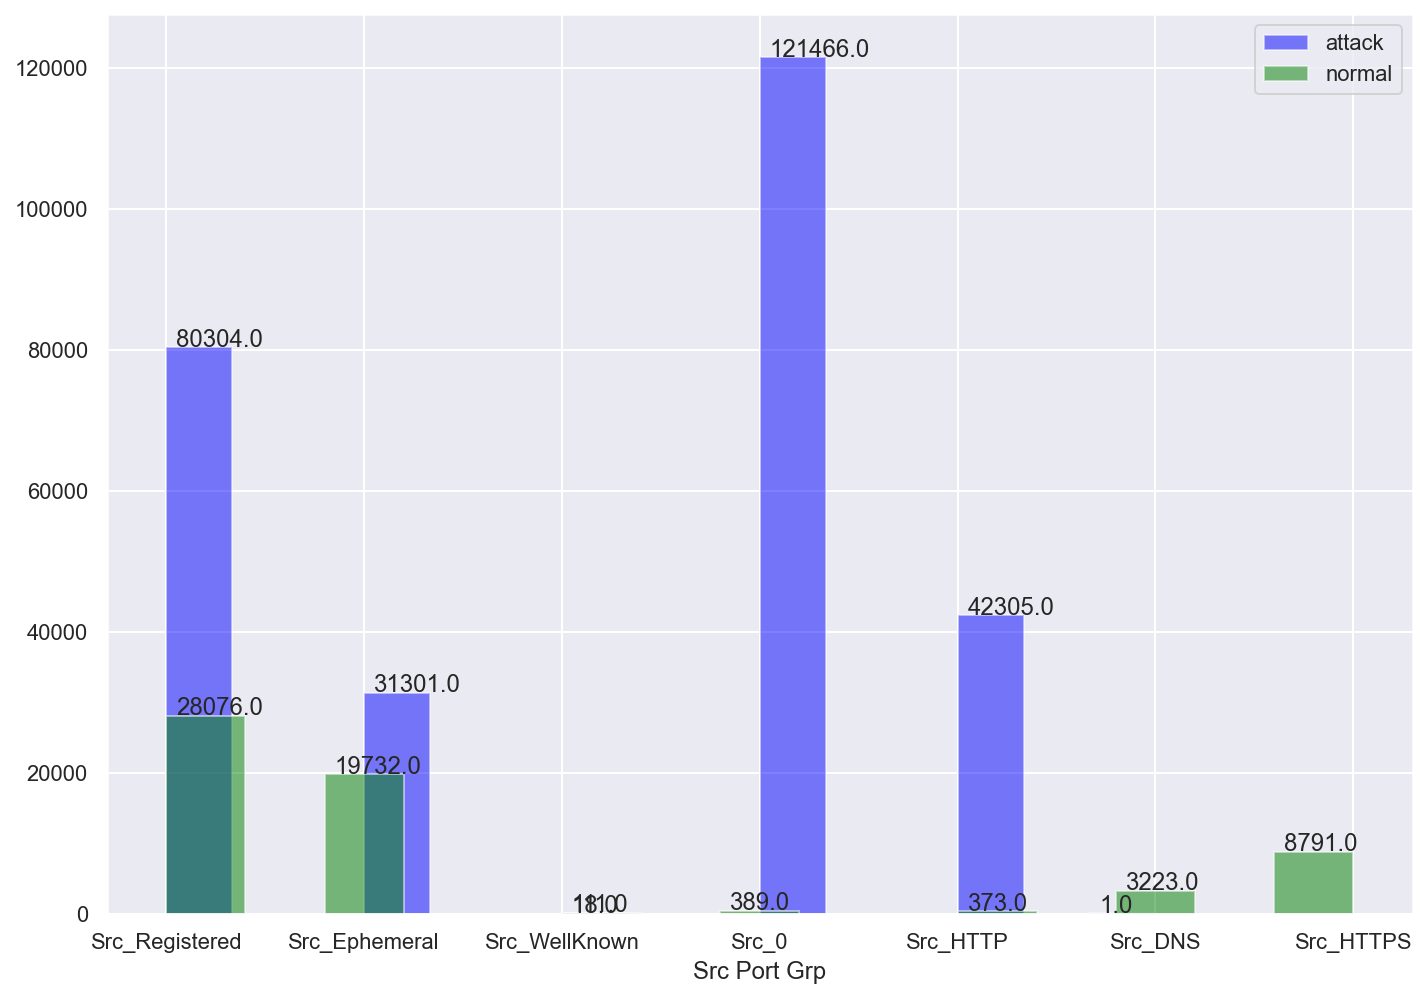

In [45]:
i='Src Port Grp'

fig, ax = plt.subplots()

ax.hist(df[df["LabelA"]==1][i], bins=15, alpha=0.5, color="blue", label="attack")
ax.hist(df[df["LabelA"]==0][i], bins=15, alpha=0.5, color="green", label="normal")

ax.set_xlabel(i)
for p in ax.patches:
        if p.get_height()>0:
            ax.annotate((p.get_height()), (p.get_x()+0.05, p.get_height()+50))

ax.legend();

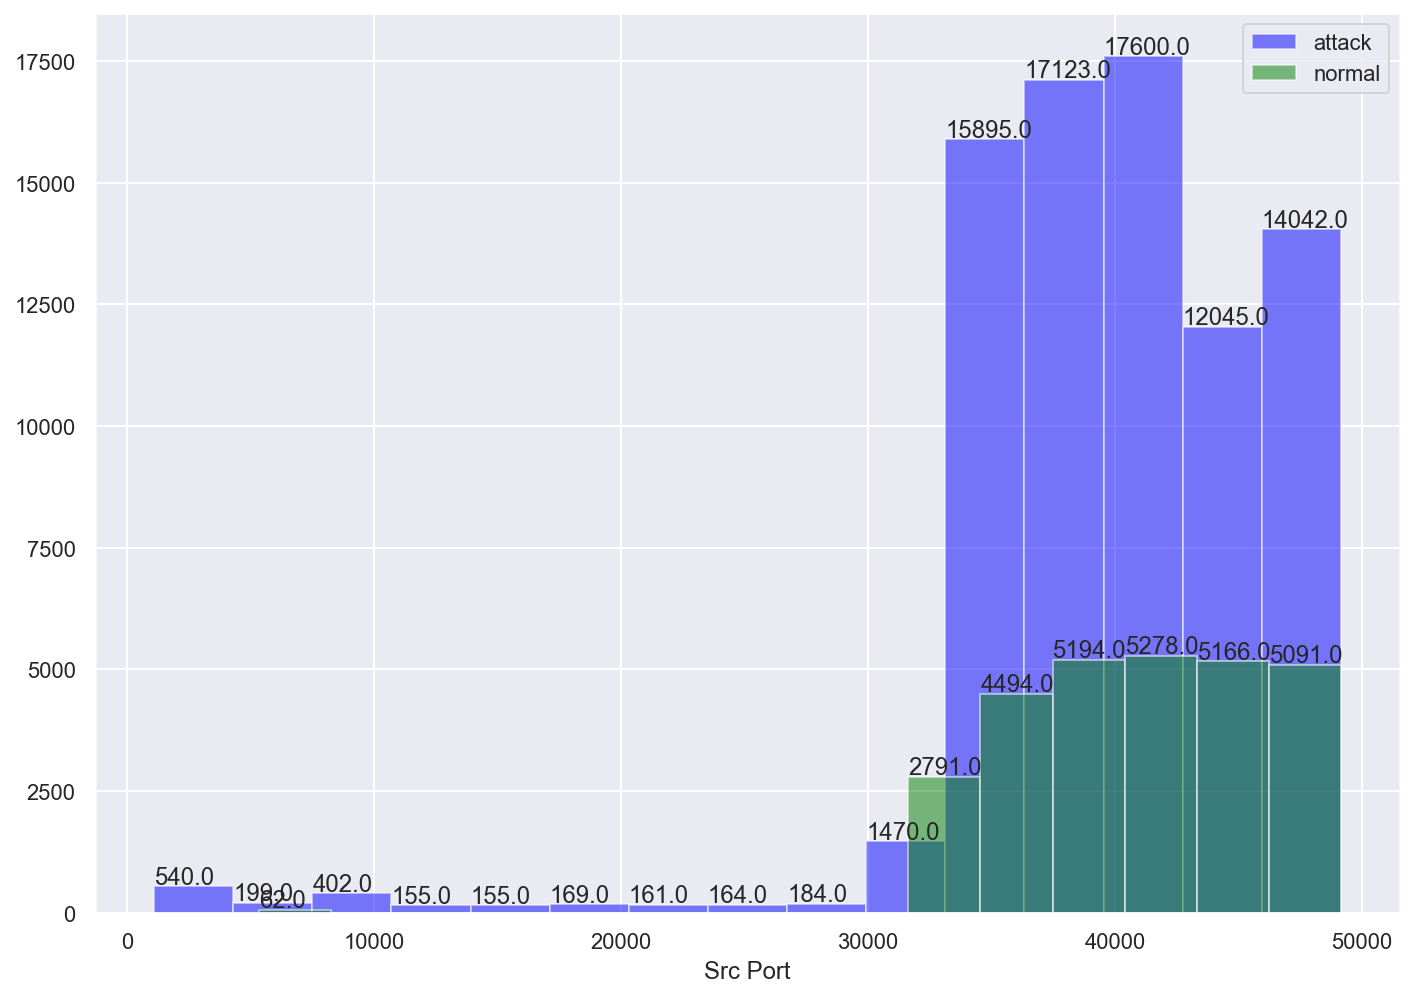

In [46]:
i='Src Port'
dfR=df[df["Src Port Grp"]=="Src_Registered"]
fig, ax = plt.subplots()

ax.hist(dfR[dfR["LabelA"]==1][i], bins=15, alpha=0.5, color="blue", label="attack")
ax.hist(dfR[dfR["LabelA"]==0][i], bins=15, alpha=0.5, color="green", label="normal")

ax.set_xlabel(i)
for p in ax.patches:
        if p.get_height()>0:
            ax.annotate((p.get_height()), (p.get_x()+0.05, p.get_height()+50))

ax.legend();

### Dst Port

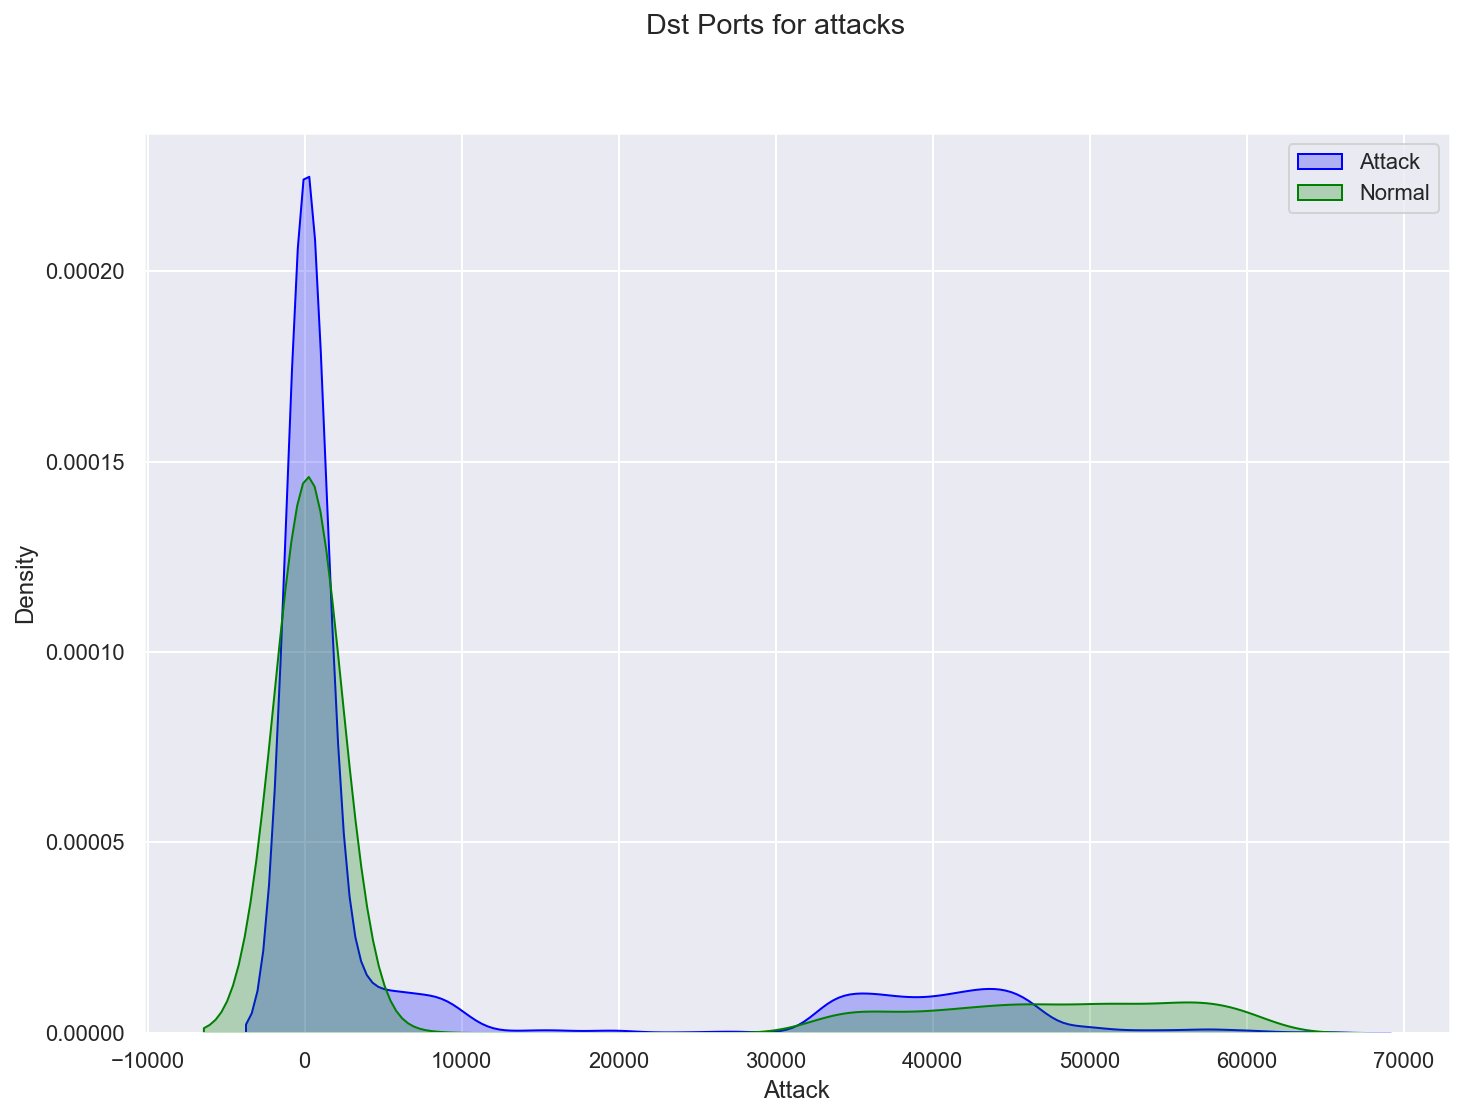

In [47]:
fig, ax = plt.subplots()

sns.kdeplot(df[df["LabelA"]==1]["Dst Port"], shade=True, color="blue", label="Attack", ax=ax)
sns.kdeplot(df[df["LabelA"]==0]["Dst Port"], shade=True, color="green", label="Normal", ax=ax)

ax.set_xlabel("Attack")
ax.set_ylabel("Density")


fig.suptitle("Dst Ports for attacks");
ax.legend();

In [48]:
criteria = [df['Dst Port']==0,df['Dst Port']=="0", df['Dst Port']==53,df['Dst Port']==80,df['Dst Port']==443,df['Dst Port'].between(1058, 49151), df['Dst Port'].between(49152, 65535)]
values = ["Dst_0","Dst_0","Dst_DNS","Dst_HTTP","Dst_HTTPS", "Dst_Registered", "Dst_Ephemeral"]

df['Dst Port Grp'] = np.select(criteria, values, 0)

In [49]:
df0=df[(df["Dst Port Grp"] =="0")]
df0[["Dst Port","Dst Port Grp"]]
df0["Dst Port"].value_counts()

137    70
138    44
22     43
23     41
139    40
       ..
553     2
167     2
462     2
945     2
386     2
Name: Dst Port, Length: 1054, dtype: int64

In [50]:
df["Dst Port Grp"]=df["Dst Port Grp"].replace("0","Dst_WellKnown")

df["Dst Port Grp"].value_counts()

Dst_0             121855
Dst_Registered     86823
Dst_HTTP           62290
Dst_DNS            30375
Dst_HTTPS          16418
Dst_Ephemeral       9432
Dst_WellKnown       8897
Name: Dst Port Grp, dtype: int64

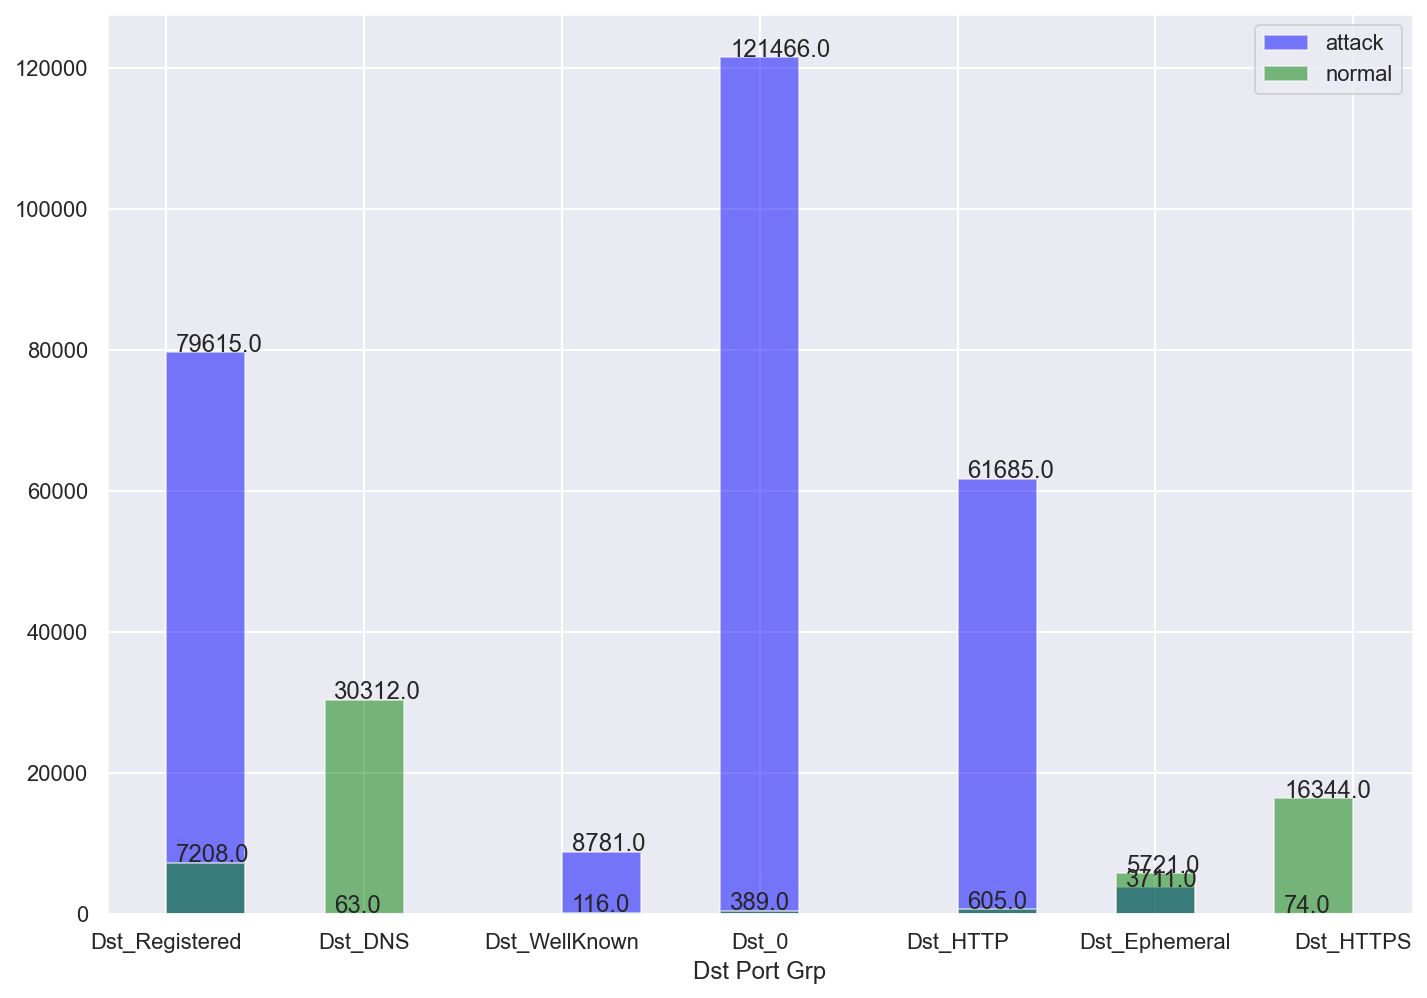

In [51]:
i='Dst Port Grp'

fig, ax = plt.subplots()

ax.hist(df[df["LabelA"]==1][i], bins=15, alpha=0.5, color="blue", label="attack")
ax.hist(df[df["LabelA"]==0][i], bins=15, alpha=0.5, color="green", label="normal")

ax.set_xlabel(i)
for p in ax.patches:
        if p.get_height()>0:
            ax.annotate((p.get_height()), (p.get_x()+0.05, p.get_height()+50))

ax.legend();

# Estudio del trafico que llega a los puertos de metasploitable
### En metasploitable hay corriendo:

##### FTP (20,21)
##### SSH (22)
##### Telnet (23)
##### Web Server (80/443)
##### Apache tomcat server (8080 default?)

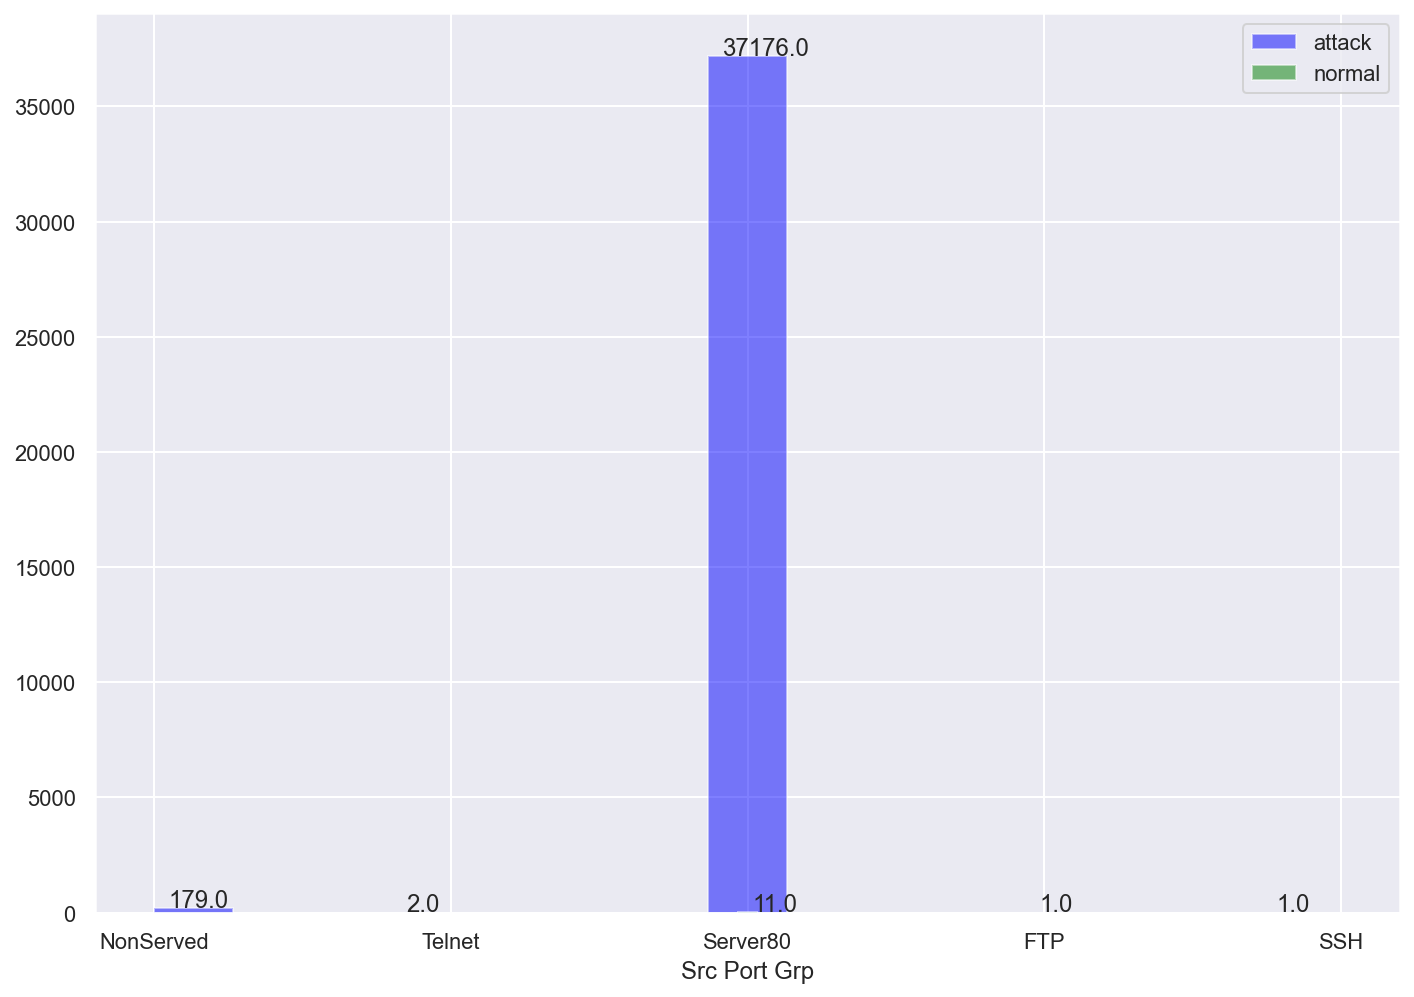

In [52]:
dfm=df[(df["Src Host"] == 'Src_Metasploitable')]

kwargs = {20: "FTP",21: "FTP",
          22: "SSH" ,
          23: "Telnet",
          80: "Server80",
          443: "Server443",
          8080: "Apache",
          0:"0"}

dfm['Src Port Grp'] = dfm['Src Port']
dfm['Src Port Grp'] = dfm['Src Port Grp'].map(kwargs).fillna("NonServed").astype(str)

i='Src Port Grp'

fig, ax = plt.subplots()

ax.hist(dfm[dfm["LabelA"]==1][i], bins=15, alpha=0.5, color="blue", label="attack")
ax.hist(dfm[dfm["LabelA"]==0][i], bins=15, alpha=0.5, color="green", label="normal")

ax.set_xlabel(i)
for p in ax.patches:
        if p.get_height()>0:
            ax.annotate((p.get_height()), (p.get_x()+0.05, p.get_height()+50))

ax.legend();

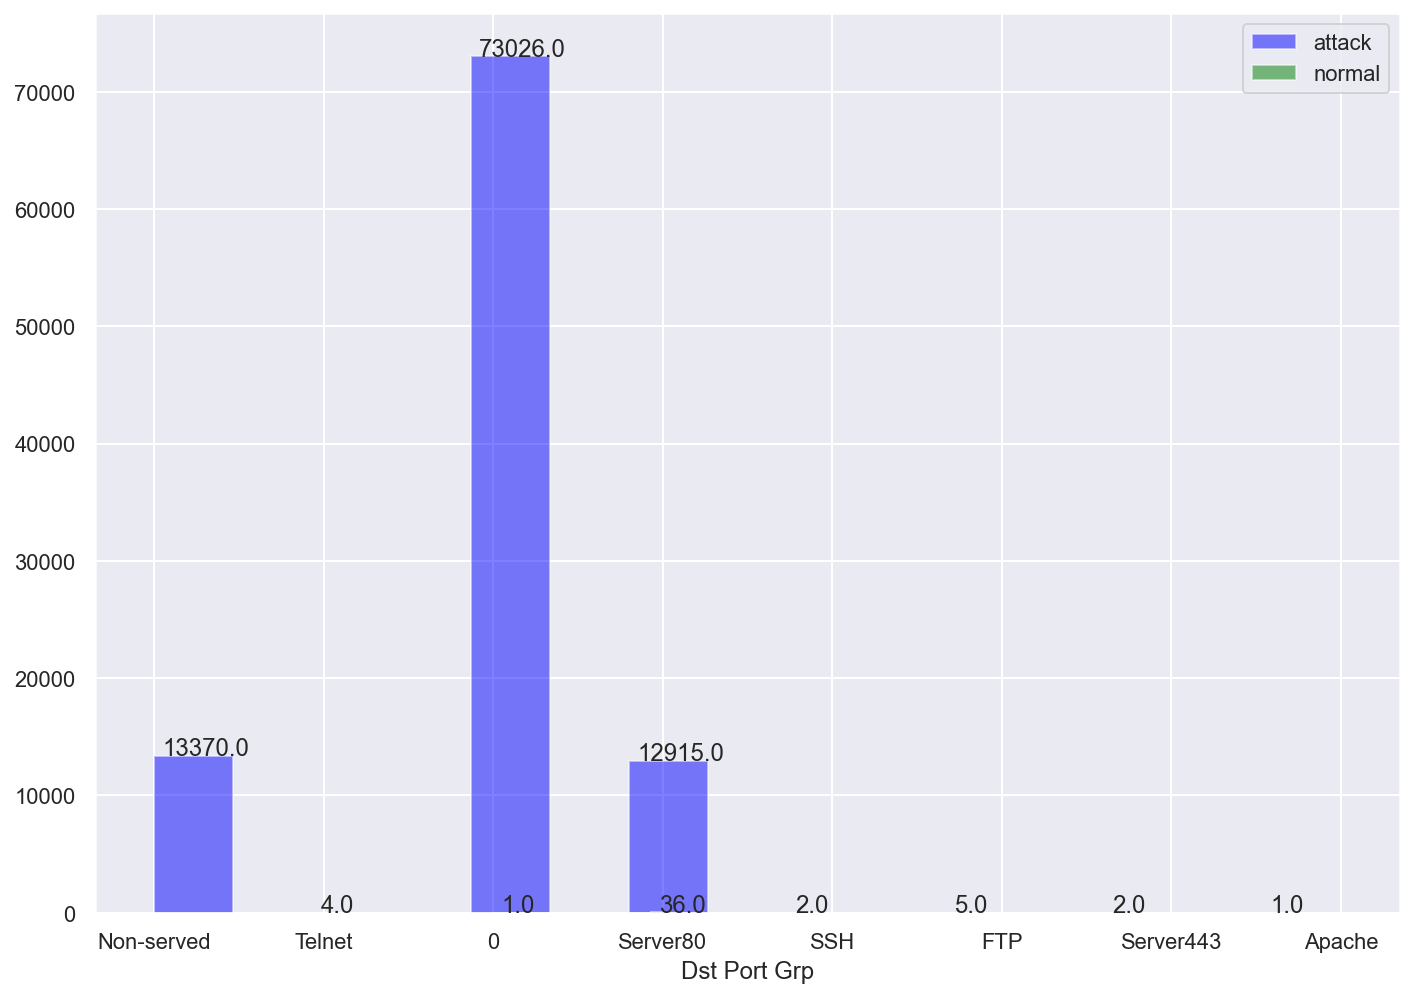

In [53]:
dfm=df[(df["Dst Host"] == 'Dst_Metasploitable')]

kwargs = {20: "FTP",21: "FTP",
          22: "SSH" ,
          23: "Telnet",
          80: "Server80",
          443: "Server443",
          8080: "Apache",
          0:"0"}

dfm['Dst Port Grp'] = dfm['Dst Port']
dfm['Dst Port Grp'] = dfm['Dst Port Grp'].map(kwargs).fillna("Non-served").astype(str)

i='Dst Port Grp'

fig, ax = plt.subplots()

ax.hist(dfm[dfm["LabelA"]==1][i], bins=15, alpha=0.5, color="blue", label="attack")
ax.hist(dfm[dfm["LabelA"]==0][i], bins=15, alpha=0.5, color="green", label="normal")

ax.set_xlabel(i)
for p in ax.patches:
        if p.get_height()>0:
            ax.annotate((p.get_height()), (p.get_x()+0.05, p.get_height()+50))

ax.legend();

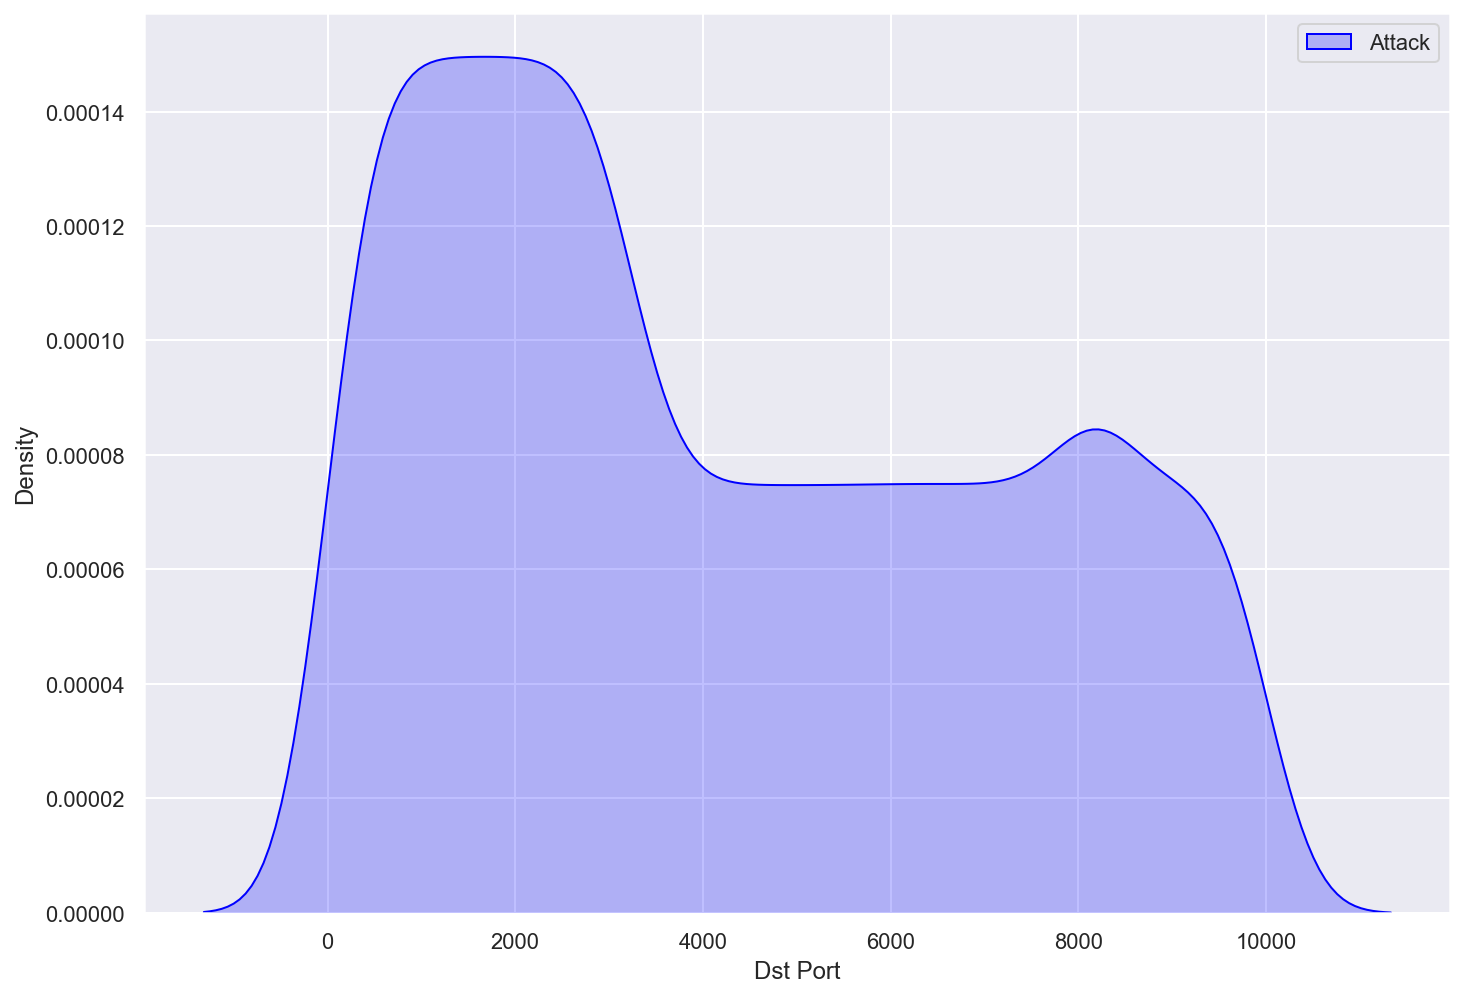

In [54]:
dfNS=dfm[dfm["Dst Port Grp"]=="Non-served"]

fig, ax = plt.subplots()

sns.kdeplot(dfNS[dfNS["LabelA"]==1]["Dst Port"], shade=True, color="blue", label="Attack", ax=ax)

ax.legend();

### Analisis del trafico en Mininet

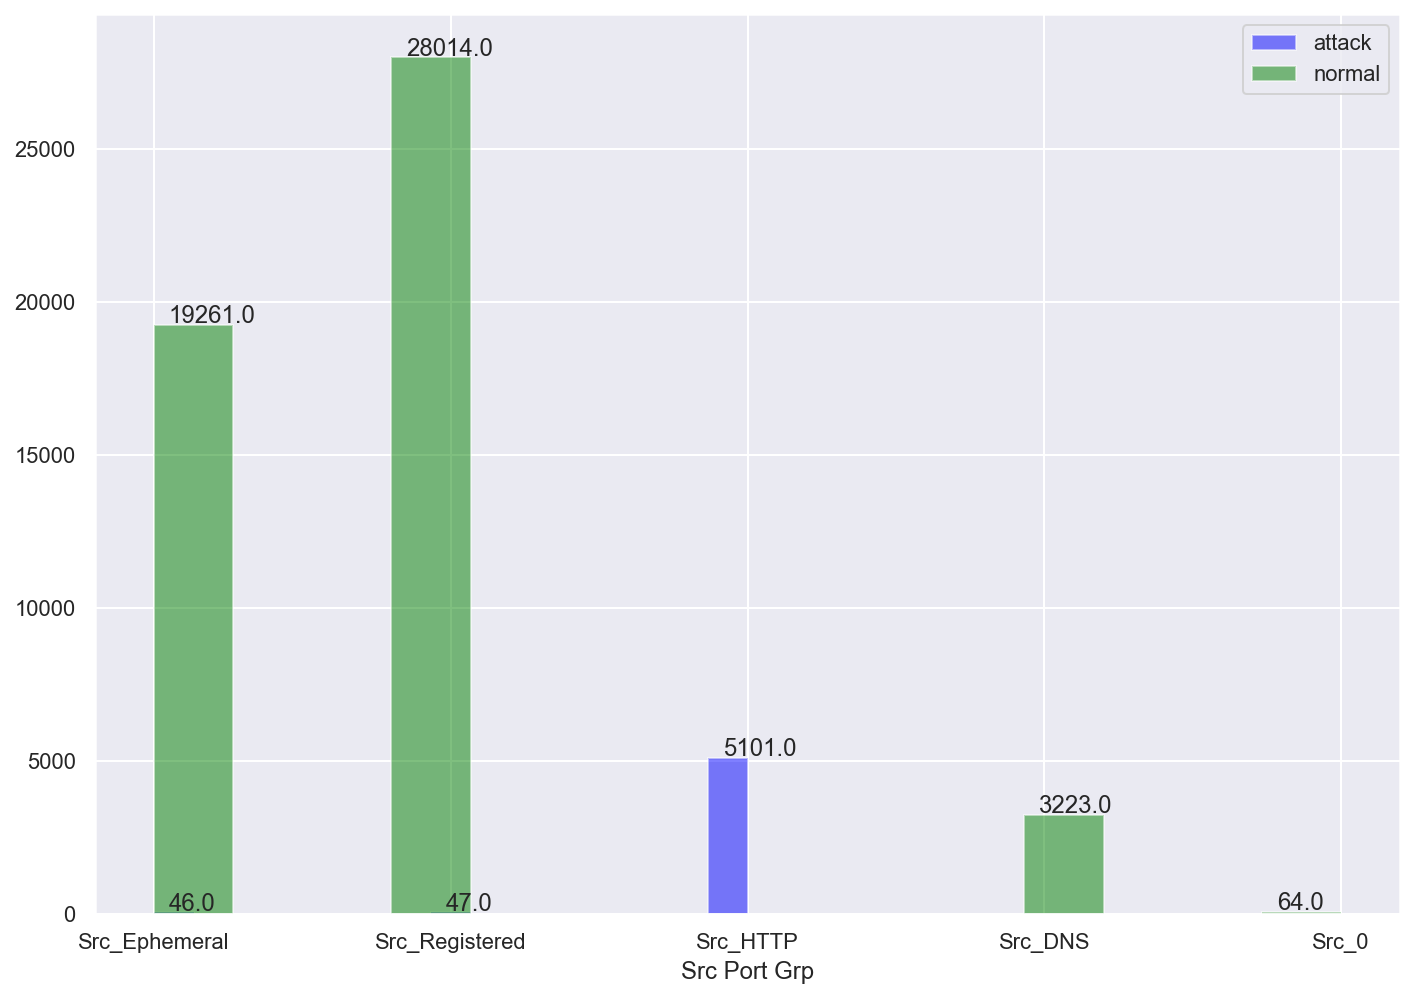

In [57]:
dfm=df[(df["Src Host"] == 'Src_Mininet')]

i='Src Port Grp'

fig, ax = plt.subplots()

ax.hist(dfm[dfm["LabelA"]==1][i], bins=15, alpha=0.5, color="blue", label="attack")
ax.hist(dfm[dfm["LabelA"]==0][i], bins=15, alpha=0.5, color="green", label="normal")

ax.set_xlabel(i)
for p in ax.patches:
        if p.get_height()>0:
            ax.annotate((p.get_height()), (p.get_x()+0.05, p.get_height()+50))

ax.legend();

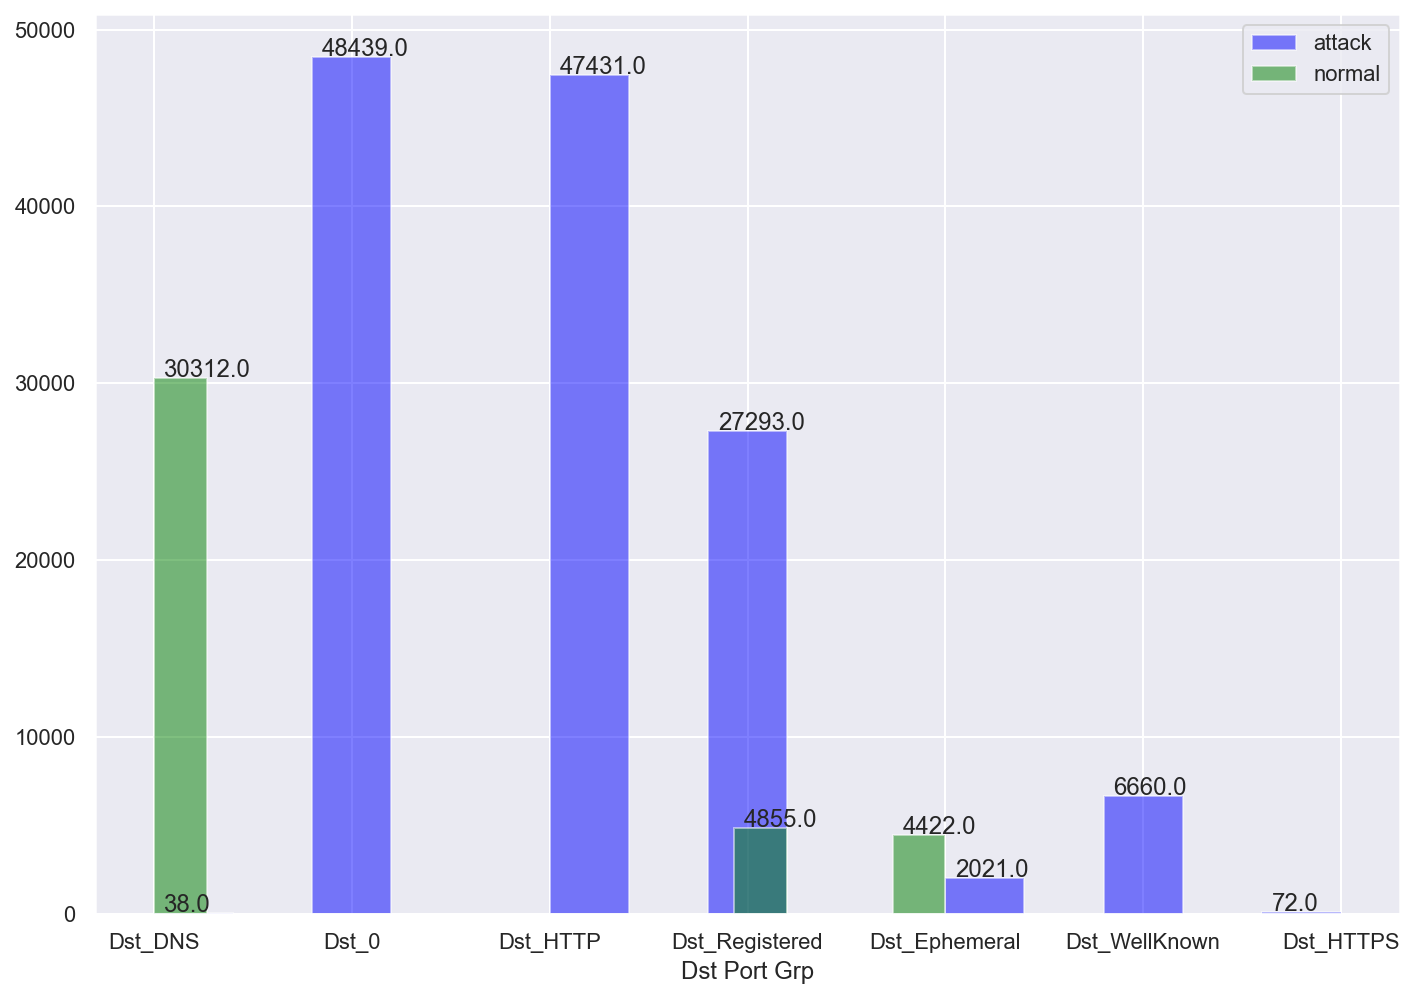

In [58]:
dfm=df[(df["Dst Host"] == 'Dst_Mininet')]

i='Dst Port Grp'

fig, ax = plt.subplots()

ax.hist(dfm[dfm["LabelA"]==1][i], bins=15, alpha=0.5, color="blue", label="attack")
ax.hist(dfm[dfm["LabelA"]==0][i], bins=15, alpha=0.5, color="green", label="normal")

ax.set_xlabel(i)
for p in ax.patches:
        if p.get_height()>0:
            ax.annotate((p.get_height()), (p.get_x()+0.05, p.get_height()+50))

ax.legend();

## Protocolo

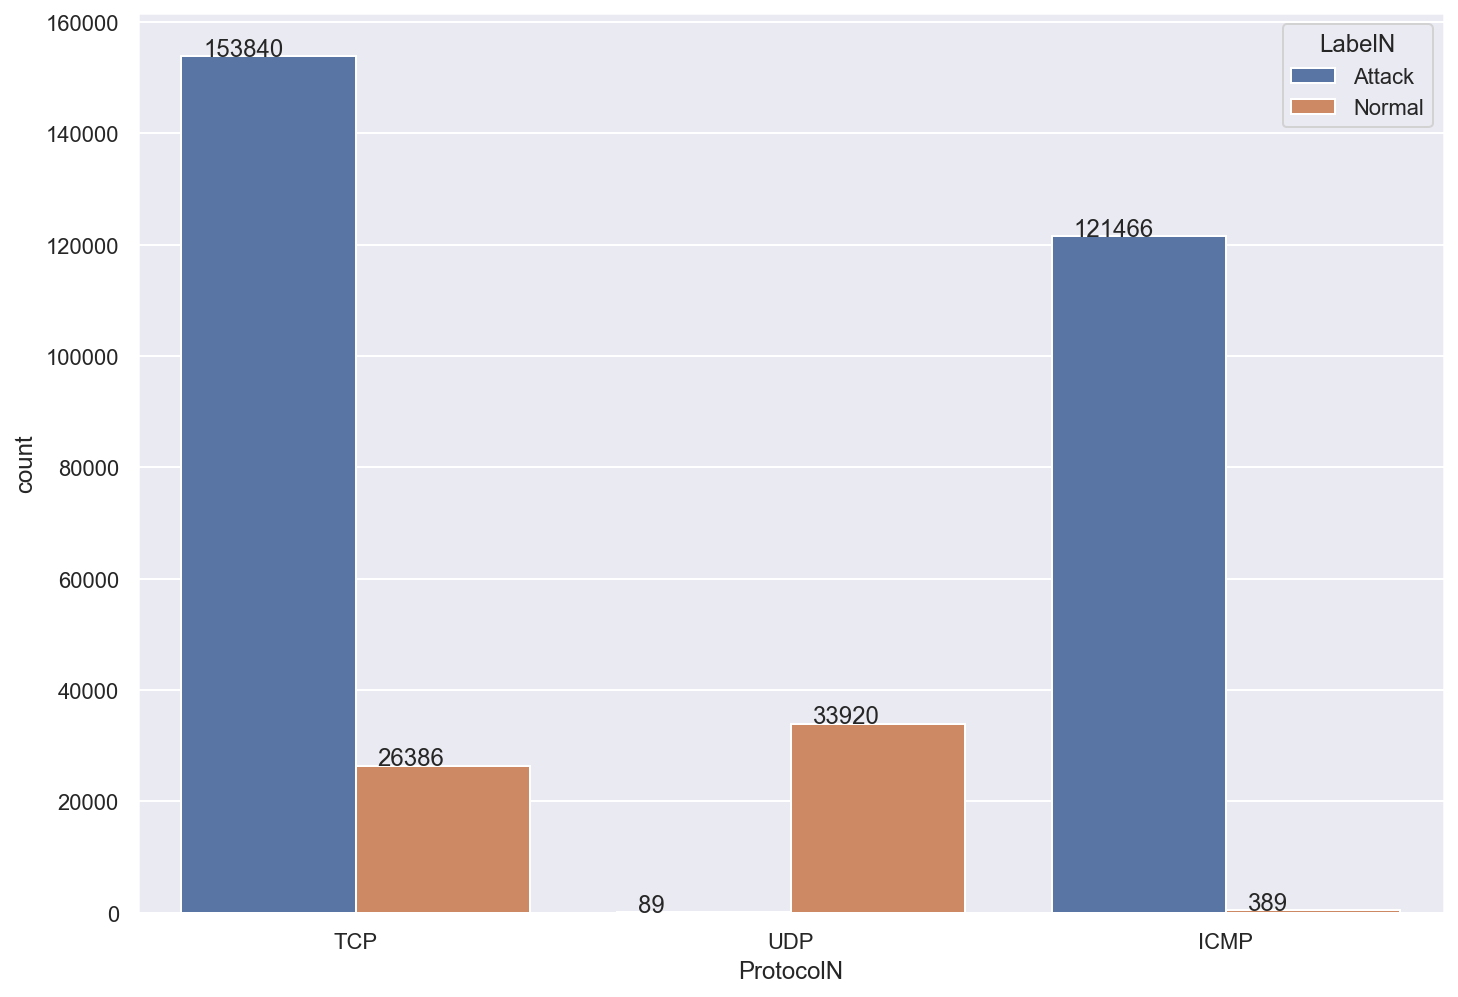

In [59]:
dct = {0: "ICMP",6: "TCP" ,17: "UDP"}

df['ProtocolN'] = df['Protocol']
df=df.replace({"ProtocolN": dct})

ax = sns.countplot(x='ProtocolN', hue="LabelN",data=df);
for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.05, p.get_height()+50))

In [60]:
#Comprobando que UDP no tenga flags
dfm=df[(df["ProtocolN"] == 'UDP')]

(dfm[["FIN Flag Cnt","SYN Flag Cnt","RST Flag Cnt","PSH Flag Cnt","ACK Flag Cnt","URG Flag Cnt"]]).nunique()

FIN Flag Cnt    1
SYN Flag Cnt    1
RST Flag Cnt    1
PSH Flag Cnt    1
ACK Flag Cnt    1
URG Flag Cnt    1
dtype: int64

# Analisis de los bytes en las headers


In [61]:
df1=df[(df["ProtocolN"] == 'ICMP')]
df2=df[(df["ProtocolN"] == 'TCP')]
df3=df[(df["ProtocolN"] == 'UDP')]

In [62]:
print("Total Bytes used for Header Size in ICMP flow")
print(df1["Bwd Header Len"].nunique())
print(df2["Bwd Header Len"].nunique())
print(df3["Bwd Header Len"].nunique())

Total Bytes used for Header Size in ICMP flow
1
387
6


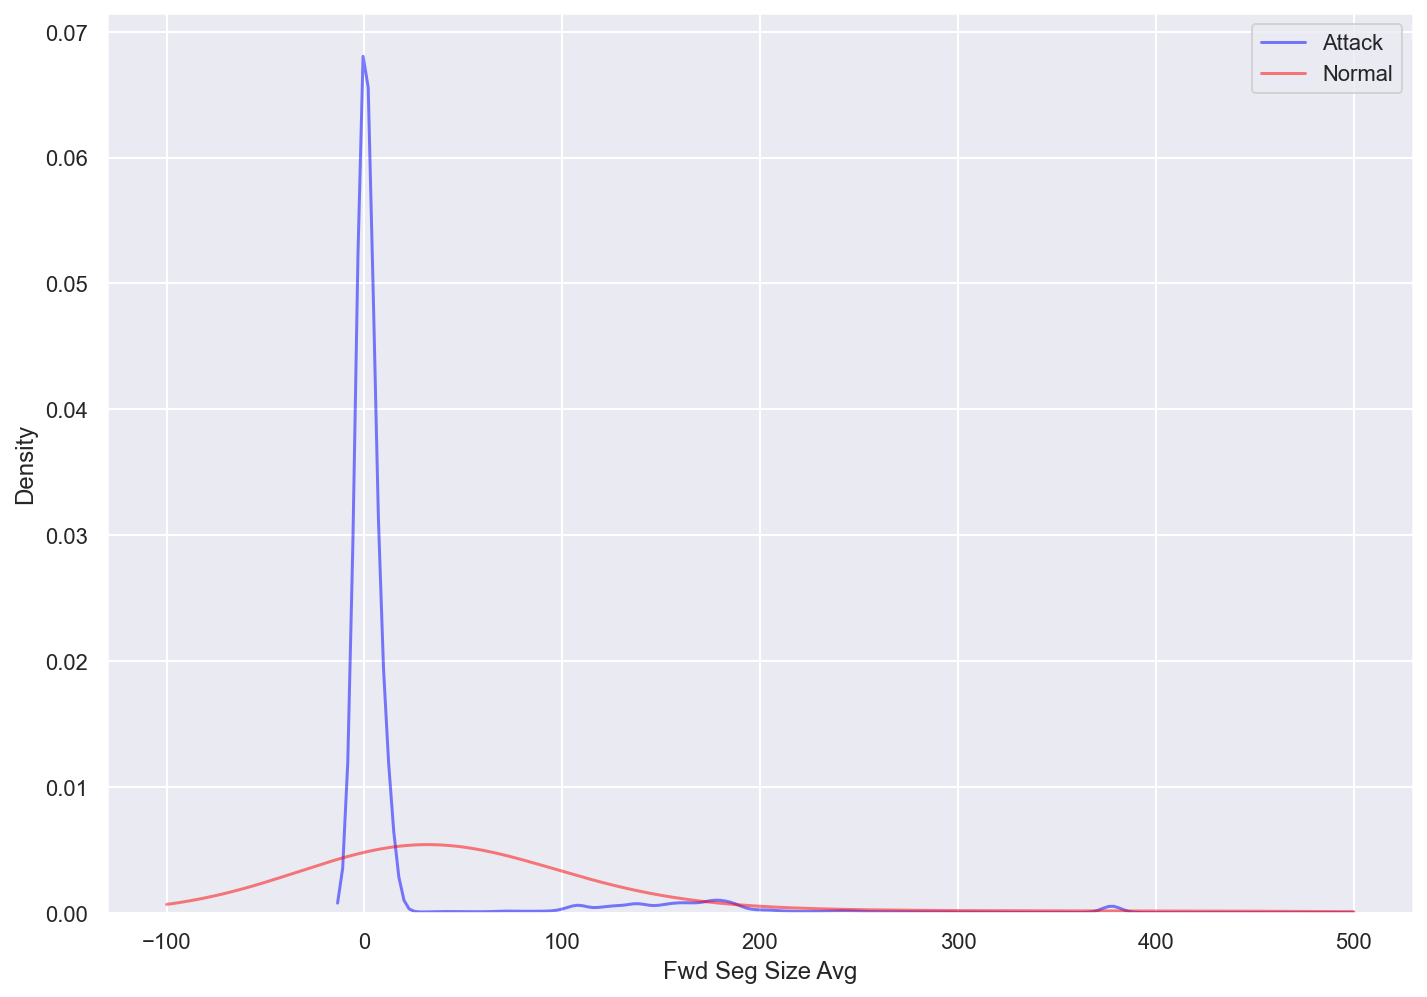

In [63]:
i="Fwd Seg Size Avg"
fig, ax = plt.subplots()

sns.kdeplot(df[df["LabelA"]==1][i], alpha=0.5, color="blue", label="Attack", ax=ax,clip=(-100,500))
sns.kdeplot(df[df["LabelA"]==0][i], alpha=0.5, color="red", label="Normal", ax=ax,clip=(-100,500))

for p in ax.patches:
        if p.get_height()>0:
            ax.annotate((p.get_height()), (p.get_x()+0.05, p.get_height()+50))
ax.legend();

# Analisis del tamaño de los paquetes

# Analisis de las flags en los flujos TCP

In [64]:
#Comprobando los flags de los flujos TCP
dfm=df[(df["ProtocolN"] == 'TCP')]
dfm.groupby(["FIN Flag Cnt","SYN Flag Cnt","RST Flag Cnt","PSH Flag Cnt","ACK Flag Cnt","URG Flag Cnt","LabelN"]).size().reset_index().rename(columns={0:'count'})


FIN Flag Cnt  SYN Flag Cnt  RST Flag Cnt  PSH Flag Cnt  ACK Flag Cnt  \
0              0             0             0             0             0   
1              0             0             0             0             1   
2              0             0             0             0             1   
3              0             0             0             1             1   
4              0             0             0             1             1   
5              0             0             1             0             0   
6              0             0             1             0             0   
7              0             0             1             0             1   
8              0             0             1             0             1   
9              0             1             0             0             0   
10             0             1             0             0             0   
11             0             1             0             0             1   
12             1             0             0             0             0   
13             1             0             0             0             1   
14             1             0             0             0             1   
15             1             0             0             1             0   
16             1             0             0             1             1   
17             1             0             0             1             1   

    URG Flag Cnt  LabelN  count  
0              0  Attack   3999  
1              0  Attack  29855  
2              0  Normal   9648  
3              0  Attack   6773  
4              0  Normal   6668  
5              0  Attack    213  
6              0  Normal     42  
7              0  Attack    108  
8              0  Normal      1  
9              0  Attack  67965  
10             0  Normal   7592  
11             0  Normal     16  
12             0  Attack   3999  
13             0  Attack  36798  
14             0  Normal   2317  
15             1  Attack   3999  
16             0  Attack    131  
17             0  Normal    102

- Todas las flags a 0: 100% ataques
- Flag de ACK : Triple de ataques que de trafico normal
- PSH+ACK: Misma cantidad de ataques que de trafico normal
- RST: Mayormente ataques, aunque un numero reducido de muestras
- RST+ACK: (Casi)Todo ataques (1 normal)
- SYN: 3 veces mas ataques que trafico normal
- SYN+ACK: Poco trafico, pero todo normal
- FIN: Todo ataques
- FIN+ACK: 14 veces mas ataques que trafico normal
- FIN+PSH+URG: Ataque
- FIN+PSH+ACK: Mismo ratio de ataque que de normal

In [65]:
#Comprobando que ICMP no tenga flags
dfm=df[(df["ProtocolN"] == 'ICMP')]

(dfm[["FIN Flag Cnt","SYN Flag Cnt","RST Flag Cnt","PSH Flag Cnt","ACK Flag Cnt","URG Flag Cnt"]]).nunique()

FIN Flag Cnt    1
SYN Flag Cnt    1
RST Flag Cnt    1
PSH Flag Cnt    1
ACK Flag Cnt    1
URG Flag Cnt    1
dtype: int64

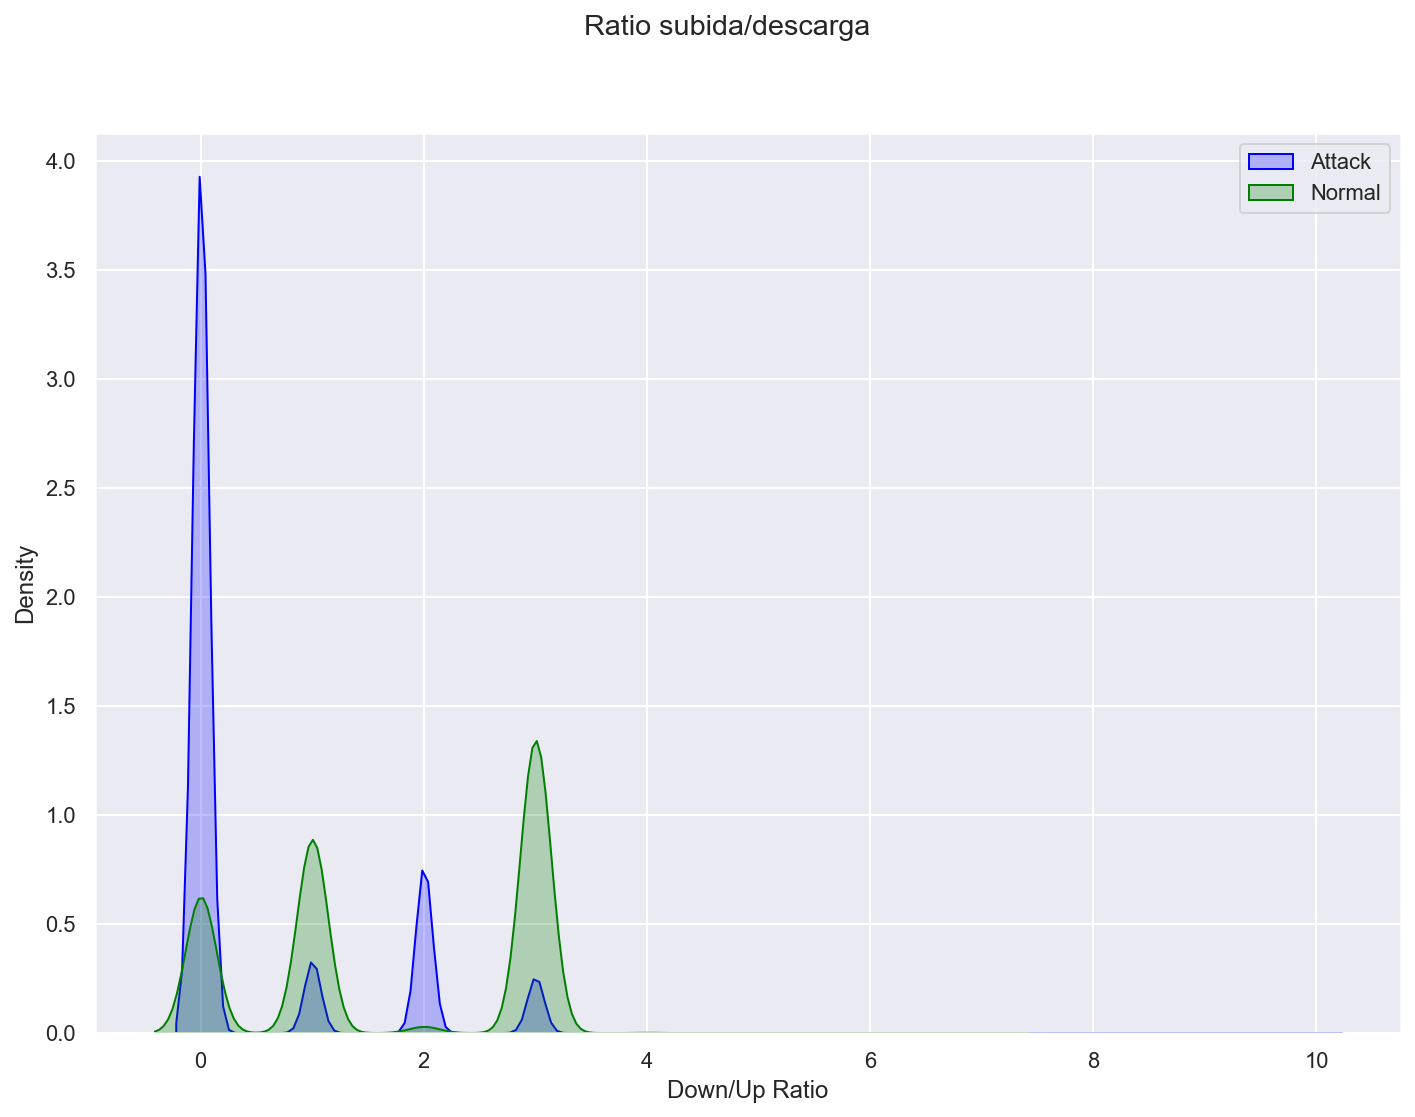

In [66]:
i='Down/Up Ratio'

fig, ax = plt.subplots()

sns.kdeplot(df[df["LabelA"]==1][i], shade=True, color="blue", label="Attack", ax=ax)
sns.kdeplot(df[df["LabelA"]==0][i], shade=True, color="green", label="Normal", ax=ax)

ax.set_xlabel("Down/Up Ratio")
ax.set_ylabel("Density")


fig.suptitle("Ratio subida/descarga");
ax.legend();

In [67]:
df.groupby(["Down/Up Ratio","Label"]).size().reset_index().rename(columns={0:'count'})


Down/Up Ratio       Label  count
0               0         BFA    554
1               0        DDoS  73517
2               0       DDoS   48407
3               0         DoS  20926
4               0      Normal  13133
5               0       Probe  62060
6               0         U2R      2
7               0  Web-Attack      8
8               1         BFA    310
9               1      BOTNET    164
10              1        DDoS      2
11              1       DDoS       1
12              1         DoS   4451
13              1      Normal  18671
14              1       Probe  12023
15              1         U2R     15
16              1  Web-Attack     98
17              2         BFA    540
18              2        DDoS      1
19              2         DoS  14932
20              2      Normal    600
21              2       Probe  24032
22              2  Web-Attack     86
23              3        DDoS      9
24              3       DDoS       4
25              3         DoS  13186
26              3      Normal  28260
27              3       Probe     11
28              4         DoS      8
29              4      Normal     30
30              5         DoS     14
31              6         DoS     14
32              7         DoS     10
33              7      Normal      1
34              8         DoS      7
35             10         DoS      3

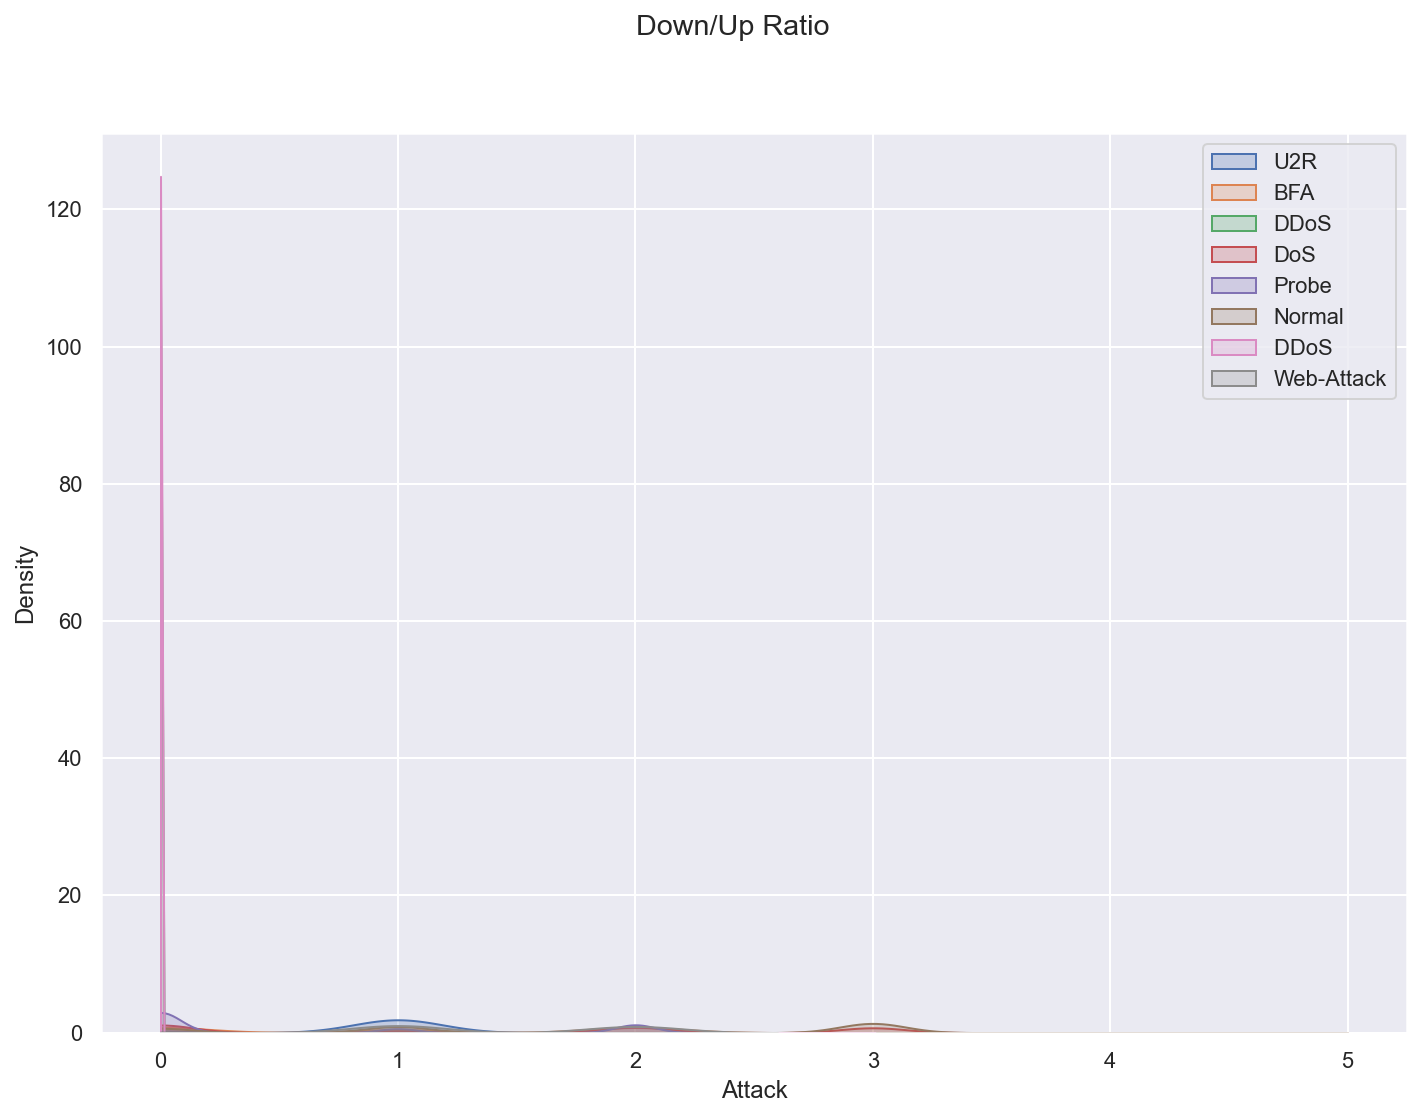

In [68]:
i='Down/Up Ratio'

fig, ax = plt.subplots()
for v in df["Label"].unique():
    vl=str(v)
    sns.kdeplot(df[df["Label"]==vl][i], shade=True, label=vl, ax=ax,clip=(0.0, 5.0))

ax.set_xlabel("Attack")
ax.set_ylabel("Density")


fig.suptitle(i);
ax.legend();

In [64]:
i='Fwd Seg Size Avg'
df.groupby(["Fwd Seg Size Avg","LabelN"]).size().reset_index(name="count").sort_values(['count'], ascending=False).rename(columns={0:'count'})


Fwd Seg Size Avg  LabelN   count
0             0.000000  Attack  211004
38           10.000000  Attack   24272
1             0.000000  Normal   12448
28            7.500000  Attack   11646
476          34.000000  Normal    4854
...                ...     ...     ...
3831        185.400000  Attack       1
3830        185.333333  Normal       1
473          33.695652  Normal       1
1700         78.363636  Normal       1
4179        213.428571  Attack       1

[7323 rows x 3 columns]

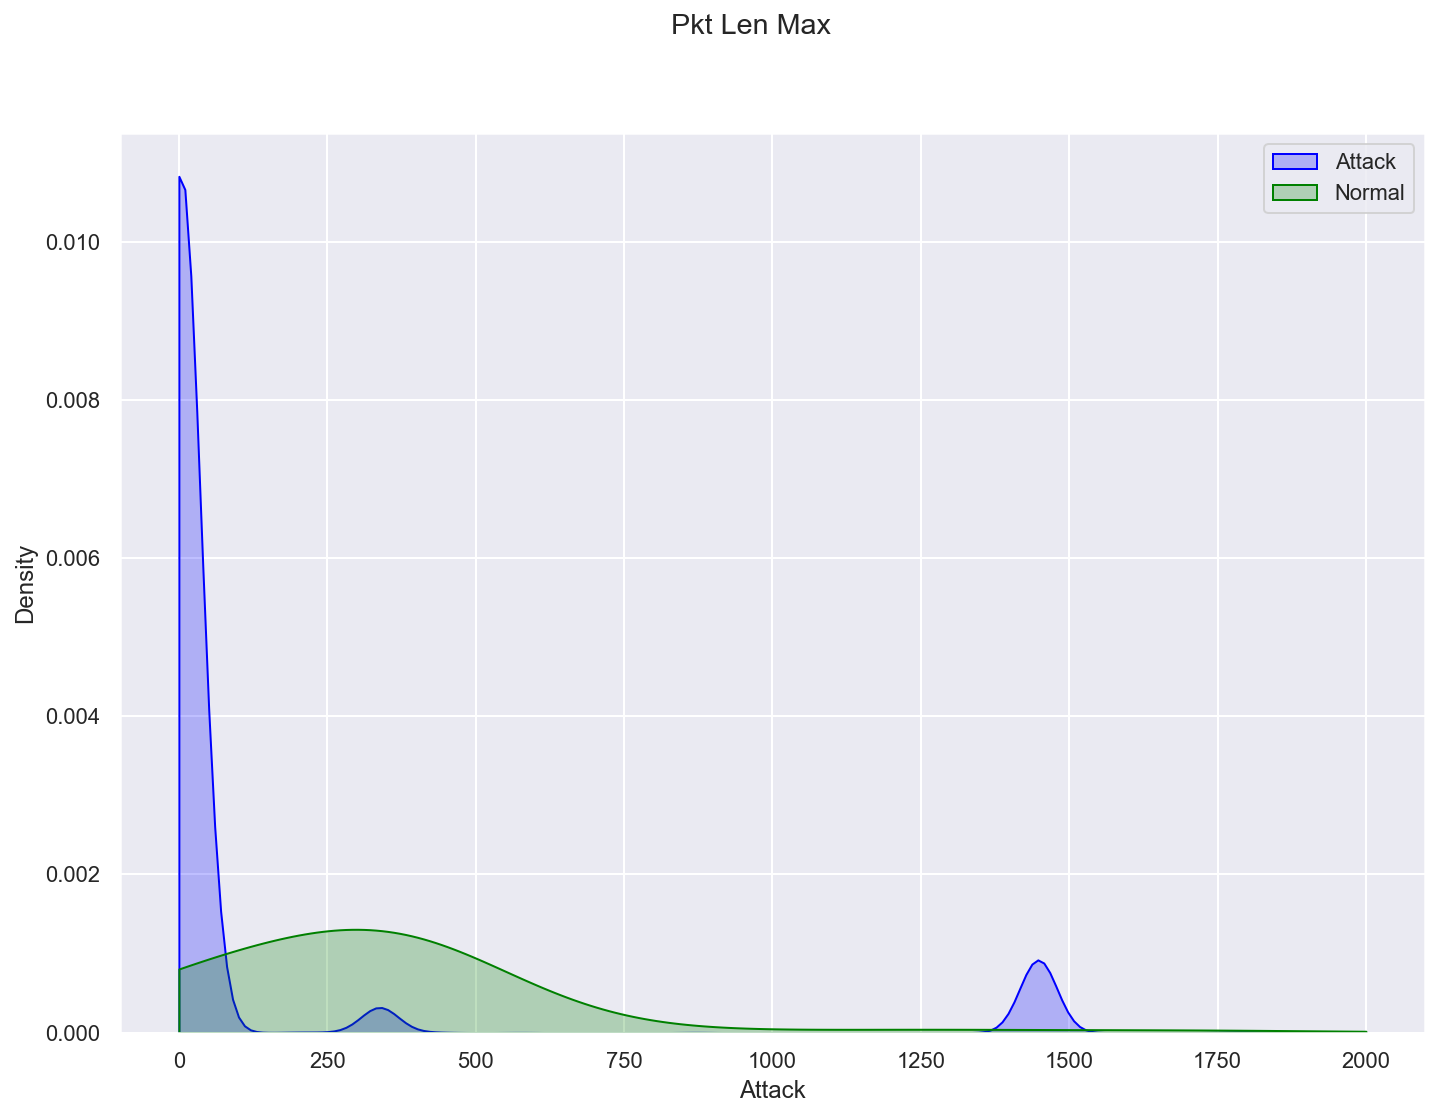

In [65]:
i='Pkt Len Max'

fig, ax = plt.subplots()

sns.kdeplot(df[df["LabelA"]==1][i], shade=True, color="blue", label="Attack", ax=ax,clip=(0.0, 2000.0))
sns.kdeplot(df[df["LabelA"]==0][i], shade=True, color="green", label="Normal", ax=ax,clip=(0.0, 2000.0))

ax.set_xlabel("Attack")
ax.set_ylabel("Density")


fig.suptitle(i);
ax.legend();

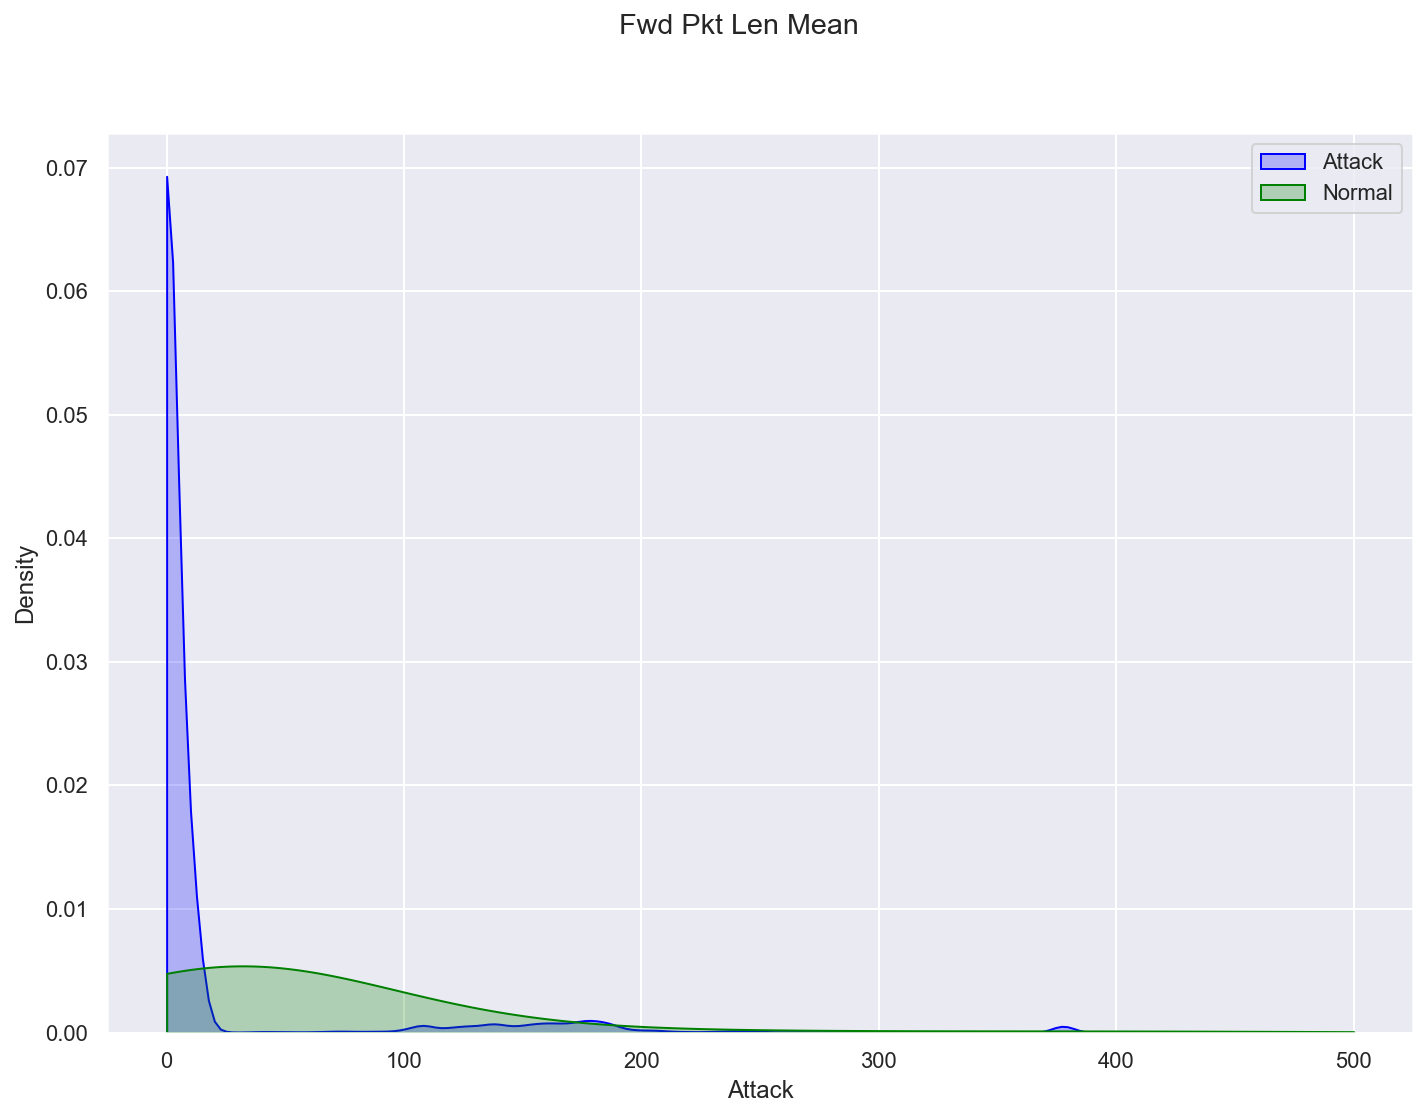

In [66]:
i='Fwd Pkt Len Mean'

fig, ax = plt.subplots()

sns.kdeplot(df[df["LabelA"]==1][i], shade=True, color="blue", label="Attack", ax=ax,clip=(0.0, 500.0))
sns.kdeplot(df[df["LabelA"]==0][i], shade=True, color="green", label="Normal", ax=ax,clip=(0.0, 500.0))

ax.set_xlabel("Attack")
ax.set_ylabel("Density")


fig.suptitle(i);
ax.legend();


#### Cortamos la grafica para quedarnos con el intervalo relevante. 

#### Un tamaño medio de 0, 10 y 7.5 en direccion forward son en su mayoria ataques.
####  Mientras que un tamaño de 0 es trafico normal


In [67]:
i='Bwd Seg Size Avg'
df.groupby([i,"LabelN"]).size().reset_index(name="count").sort_values(['count'], ascending=False).rename(columns={0:'count'})


Bwd Seg Size Avg  LabelN   count
0             0.000000  Attack  204618
62            4.285714  Attack   23960
1             0.000000  Normal   12216
78            7.500000  Attack   11646
1688         76.000000  Attack    6420
...                ...     ...     ...
3318        160.677419  Normal       1
691          40.500000  Normal       1
3315        160.653846  Normal       1
3314        160.642857  Normal       1
3572        177.777778  Normal       1

[7145 rows x 3 columns]

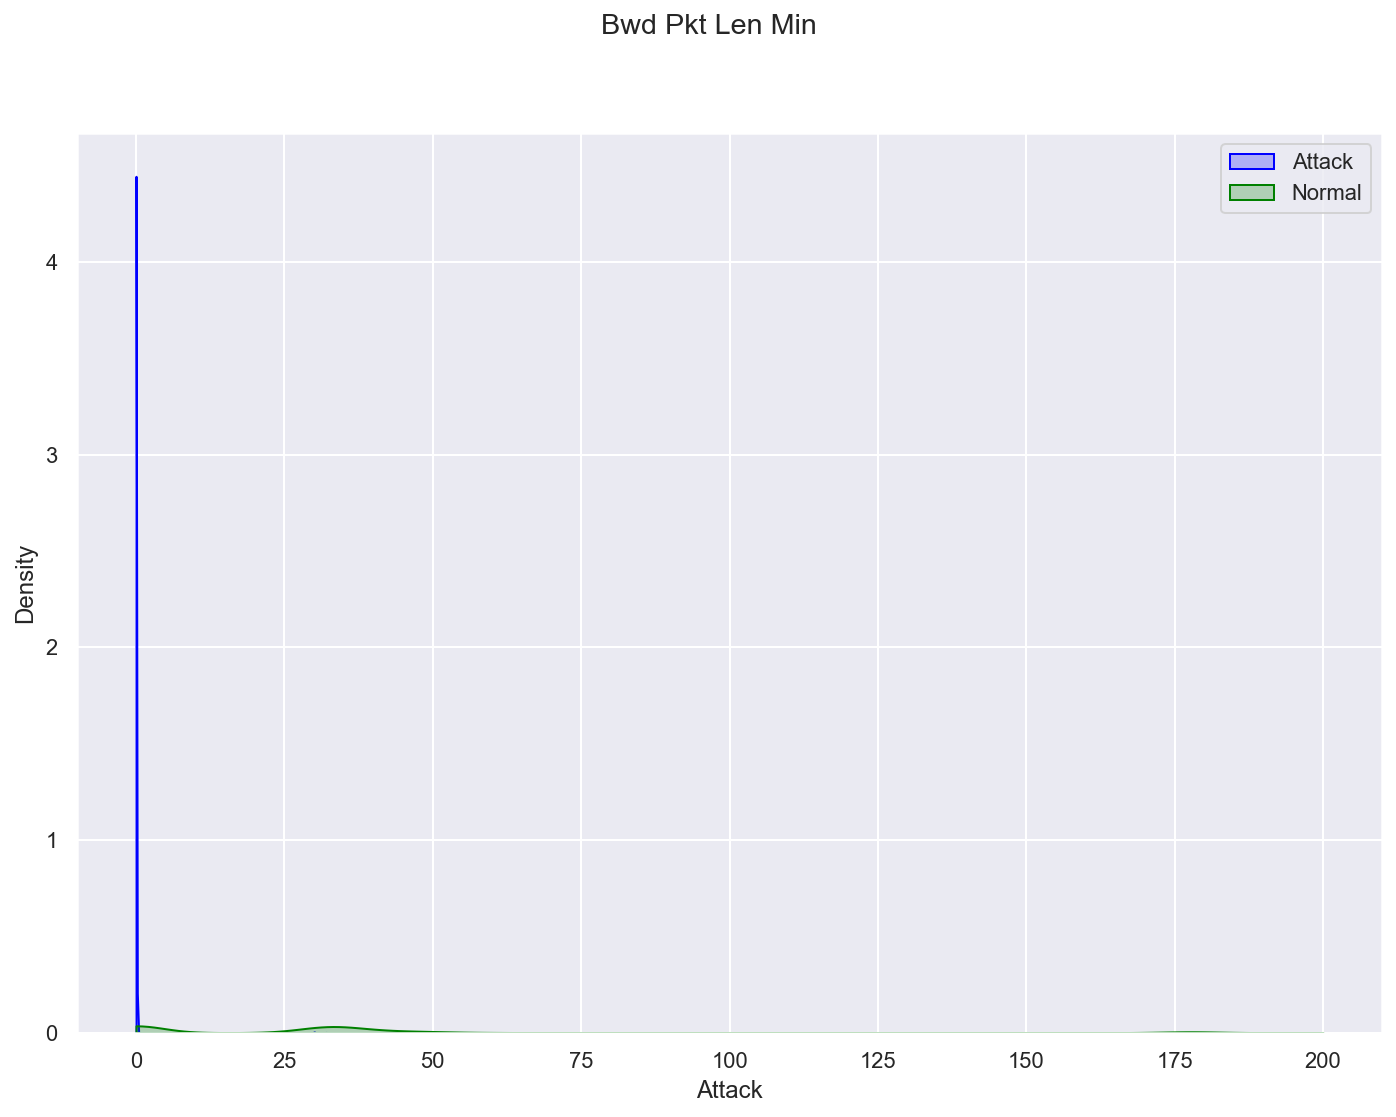

In [68]:
i='Bwd Pkt Len Min'

fig, ax = plt.subplots()

sns.kdeplot(df[df["LabelA"]==1][i], shade=True, color="blue", label="Attack", ax=ax,clip=(0.0, 200.0))
sns.kdeplot(df[df["LabelA"]==0][i], shade=True, color="green", label="Normal", ax=ax,clip=(0.0, 200.0))

ax.set_xlabel("Attack")
ax.set_ylabel("Density")


fig.suptitle(i);
ax.legend();

Analisis del tamaño de los paquetes

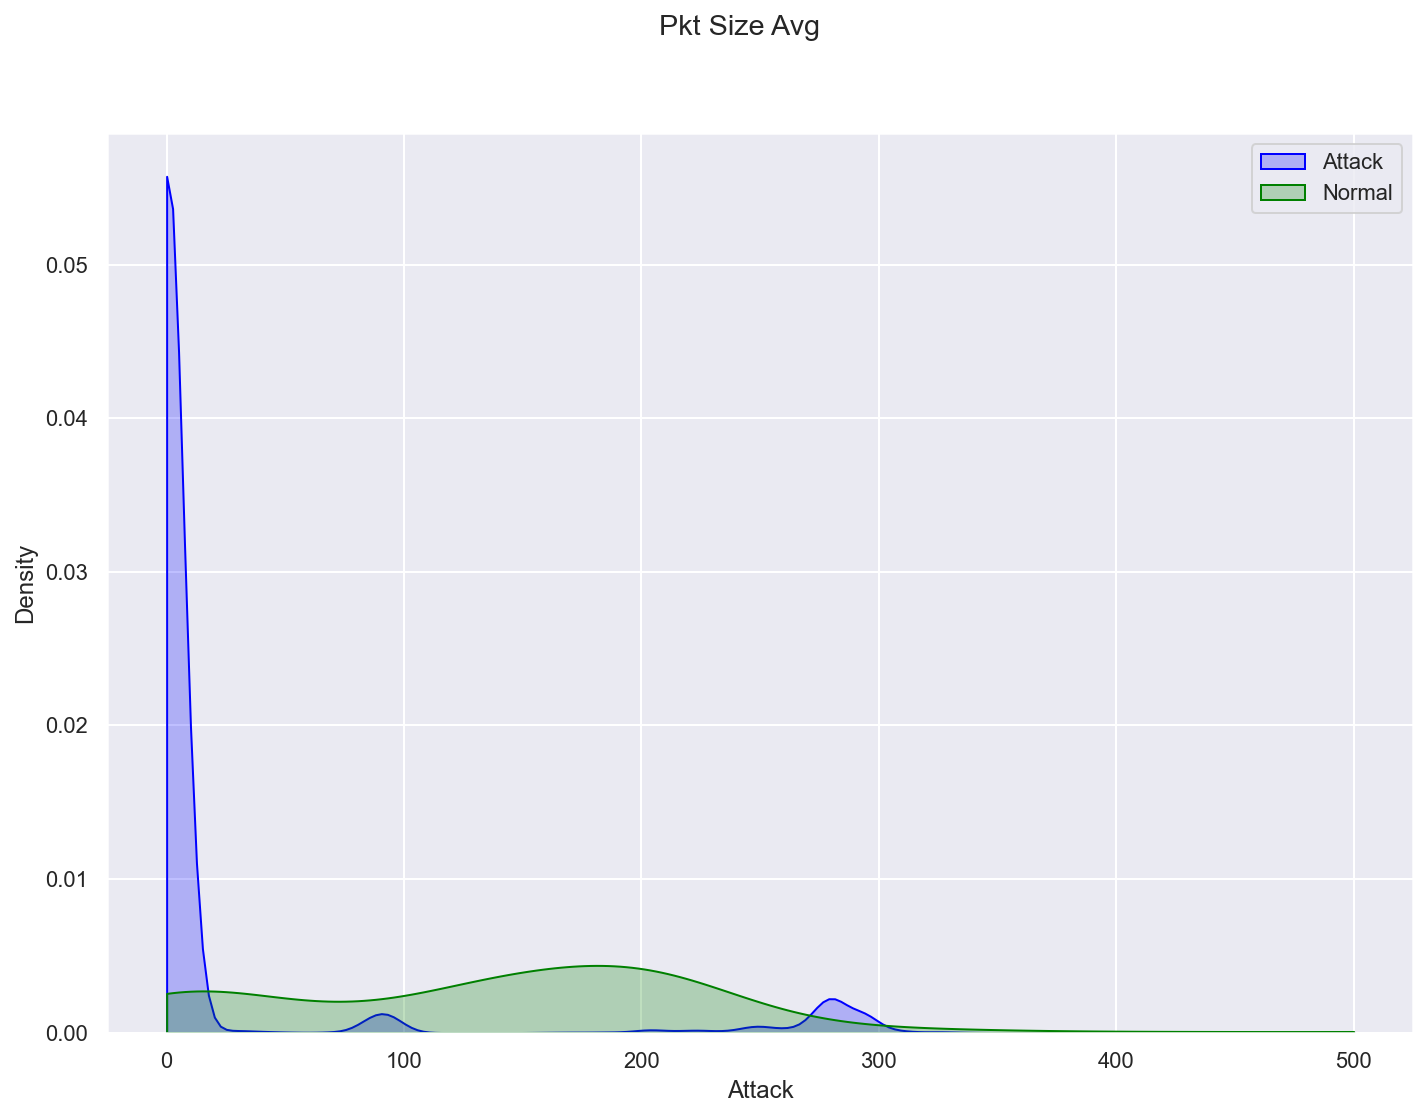

In [69]:
i='Pkt Size Avg'

fig, ax = plt.subplots()

sns.kdeplot(df[df["LabelA"]==1][i], shade=True, color="blue", label="Attack", ax=ax,clip=(0.0, 500.0))
sns.kdeplot(df[df["LabelA"]==0][i], shade=True, color="green", label="Normal", ax=ax,clip=(0.0, 500.0))

ax.set_xlabel("Attack")
ax.set_ylabel("Density")


fig.suptitle(i);
ax.legend();

# Calculando la correlacion con LabelA

In [74]:
# Use only training data
train_heads = df.loc[df['LabelA'].notnull(), :].copy()

pcorrs = pd.DataFrame(df.corr()['LabelA'].sort_values()).rename(columns = {'LabelA': 'pcorr'}).reset_index()
pcorrs = pcorrs.rename(columns = {'index': 'feature'})

print('Most negatively correlated variables:')
print(pcorrs.head(10))

print('\nMost positively correlated variables:')
print(pcorrs.dropna().tail(11))

Most negatively correlated variables:
            feature     pcorr
0           Weekend -0.777738
1          Protocol -0.684822
2       Pkt Len Min -0.621198
3   Bwd Pkt Len Min -0.527818
4     Down/Up Ratio -0.434483
5  Bwd Seg Size Avg -0.378883
6  Bwd Pkt Len Mean -0.378883
7      Pkt Size Avg -0.367369
8      Pkt Len Mean -0.351608
9   Fwd Pkt Len Min -0.315084

Most positively correlated variables:
          feature     pcorr
64  Bwd URG Flags  0.051516
65   SYN Flag Cnt  0.111899
66             hx  0.113959
67   FIN Flag Cnt  0.136318
68         Minute  0.155832
69    Flow Pkts/s  0.198458
70     Bwd Pkts/s  0.202078
71            day  0.237014
72             hy  0.324731
73          Month  0.482519
74         LabelA  1.000000


The general guidelines for correlation values are below, but these will change depending on who you ask (source for these):
.00-.19 “muy debil”
.20-.39 “debil”
.40-.59 “moderada”
.60-.79 “fuerte”
.80-1.0 “muy fuerte”
What these correlations show is that there are some weak relationships that hopefully our model will be able to use to learn a mapping from the features to the Target.

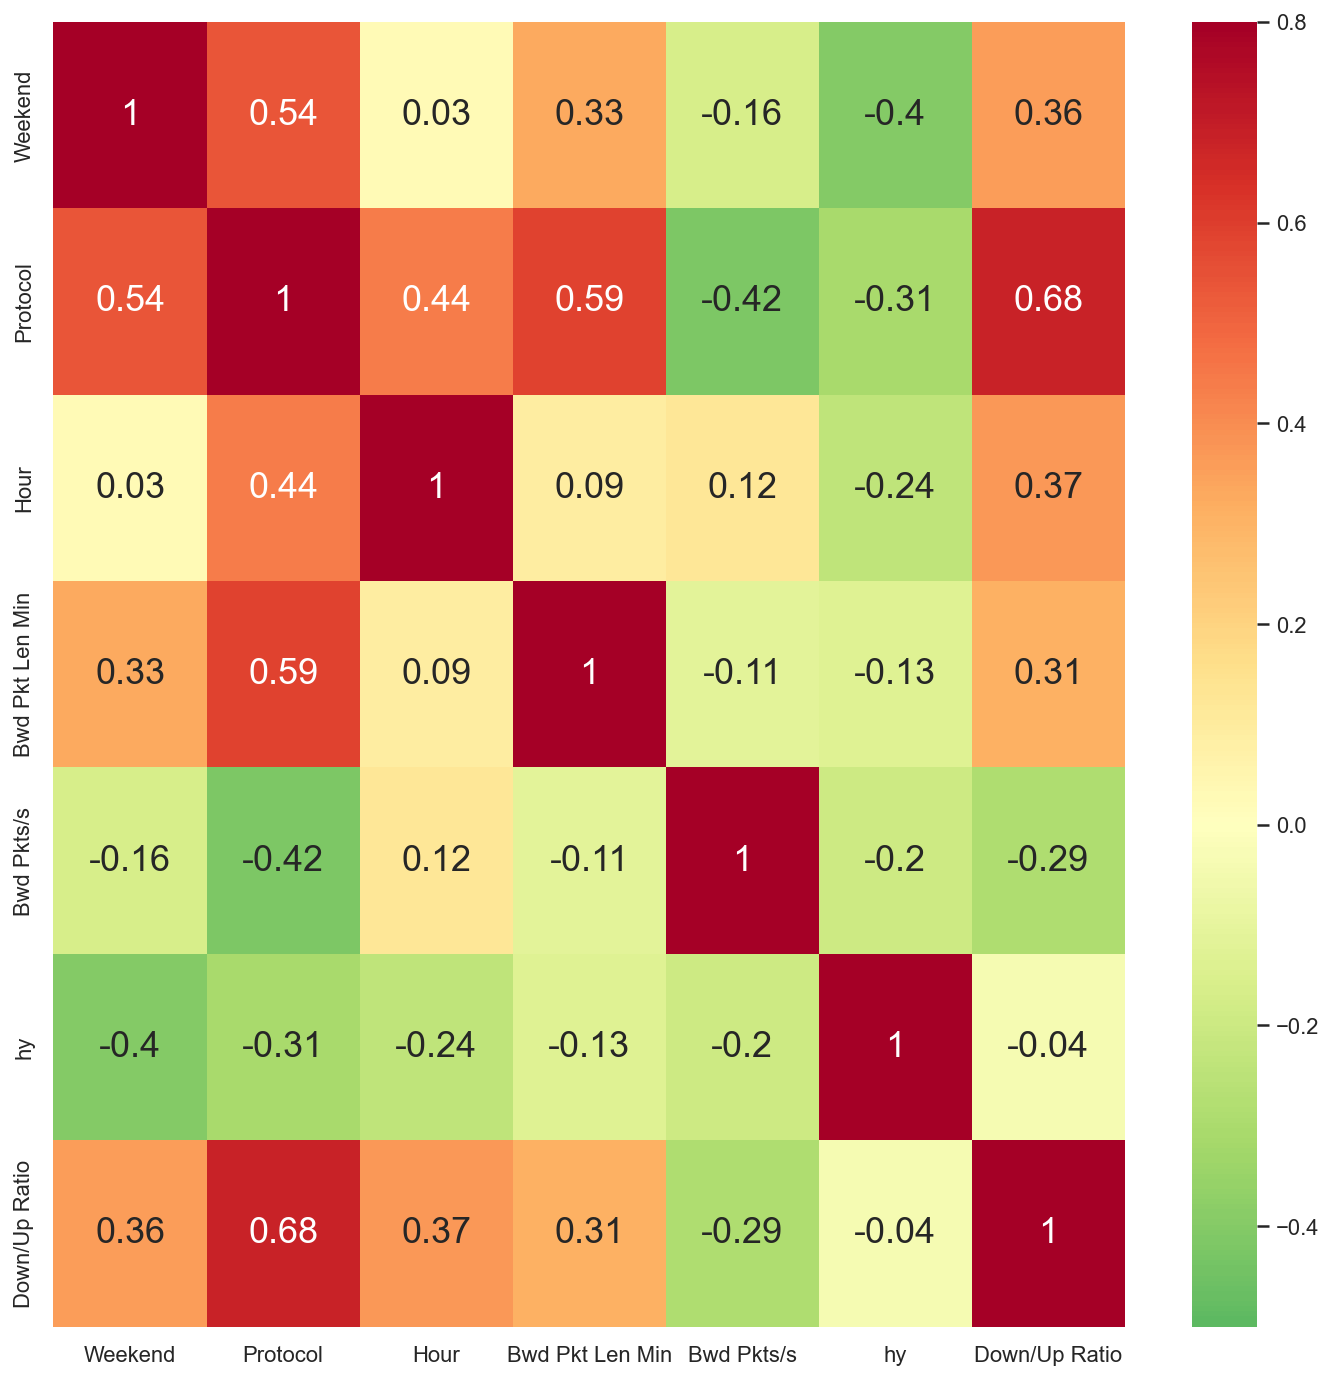

In [71]:
variables = ['Weekend', 'Protocol', 'Hour', 'Bwd Pkt Len Min',
             'Bwd Pkts/s', 'hy',"Down/Up Ratio"]

corr_mat = df[variables].corr().round(2)

# Draw a correlation heatmap
plt.rcParams['font.size'] = 18
plt.figure(figsize = (12, 12))
sns.heatmap(corr_mat, vmin = -0.5, vmax = 0.8, center = 0, 
            cmap = plt.cm.RdYlGn_r, annot = True);

# One hot encoding y Arbol para importancia de las features

In [51]:
dft=df.copy()

In [52]:
dft = dft.drop_duplicates()


Vamos a prescindir de unas cuantas features.
- Las ips concretas. Analizaremos cada una de las redes por separado.
- El timestamp. Tenemos si es dia de la semana o no y tenemos un flujo esta proximo a otro, (en el tiempo)
    (Deberiamos pasarle tambien la fecha? Dia, mes y año para que le sirva de algo tener la hora?)
- El tipo de ataque concreto. Estamos buscando tan solo si es un ataque o no.
- El protocolo. Haremos one hot encoding.

In [74]:
print(dft.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336090 entries, 0 to 343888
Data columns (total 89 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Src IP             336090 non-null  object        
 1   Src Port           336090 non-null  int64         
 2   Dst IP             336090 non-null  object        
 3   Dst Port           336090 non-null  int64         
 4   Protocol           336090 non-null  int64         
 5   Timestamp          336090 non-null  object        
 6   Flow Duration      336090 non-null  int64         
 7   Tot Fwd Pkts       336090 non-null  int64         
 8   Tot Bwd Pkts       336090 non-null  int64         
 9   TotLen Fwd Pkts    336090 non-null  float64       
 10  TotLen Bwd Pkts    336090 non-null  float64       
 11  Fwd Pkt Len Max    336090 non-null  int64         
 12  Fwd Pkt Len Min    336090 non-null  int64         
 13  Fwd Pkt Len Mean   336090 non-null  float64 

In [75]:
dft = dft.drop(["FIN Flag Cnt","SYN Flag Cnt","RST Flag Cnt","PSH Flag Cnt","ACK Flag Cnt","URG Flag Cnt"],axis=1)
dft =dft.drop(["Src IP"], axis=1)
dft =dft.drop(["Dst IP"], axis=1)
dft =dft.drop(["Minute"], axis=1)
dft =dft.drop(["hourfloat"], axis=1)
dft =dft.drop(["Label"], axis=1)
dft =dft.drop(["LabelN"], axis=1)
dft =dft.drop(["Protocol"], axis=1)
dft =dft.drop(["Timestamp"], axis=1)
dft =dft.drop(["DayName"], axis=1)
dft=dft.drop(["Src Port"], axis=1)
dft=dft.drop(["Dst Port"], axis=1)


For machine learning, you almost definitely want to use sklearn.OneHotEncoder. For other tasks like simple analyses, you might be able to use pd.get_dummies, which is a bit more convenient.

The crux of it is that the sklearn encoder creates a function which persists and can then be applied to new data sets which use the same categorical variables, with consistent results.



In [76]:
from sklearn.preprocessing import OneHotEncoder
lst=["Src Port Grp","Dst Port Grp","ProtocolN","Src Host","Dst Host"]

for i in lst:
    onehot = OneHotEncoder()
    onehot.fit([dft[i]])
    encoded = onehot.fit_transform(dft[[i]])
    dft[onehot.categories_[0]] = encoded.toarray()
    #Y ahora hacemos drop de la categoria a la que le acabamos de hacer el onehotencoding y de una de las onehotencodings
    #porque se puede derivar del resto
    dft =dft.drop([i], axis=1)
    dft =dft.drop([onehot.categories_[0][0]], axis=1)

In [77]:
dft =dft.drop(["Datetime"], axis=1)
dft =dft.drop(["day"], axis=1)
dft =dft.drop(["Dst HostM"], axis=1)
dft =dft.drop(["Src HostM"], axis=1)
dft =dft.drop(["Hour"], axis=1)

In [78]:
dft =dft.drop(["Month"], axis=1)

In [79]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336090 entries, 0 to 343888
Data columns (total 82 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Flow Duration       336090 non-null  int64  
 1   Tot Fwd Pkts        336090 non-null  int64  
 2   Tot Bwd Pkts        336090 non-null  int64  
 3   TotLen Fwd Pkts     336090 non-null  float64
 4   TotLen Bwd Pkts     336090 non-null  float64
 5   Fwd Pkt Len Max     336090 non-null  int64  
 6   Fwd Pkt Len Min     336090 non-null  int64  
 7   Fwd Pkt Len Mean    336090 non-null  float64
 8   Fwd Pkt Len Std     336090 non-null  float64
 9   Bwd Pkt Len Max     336090 non-null  int64  
 10  Bwd Pkt Len Min     336090 non-null  int64  
 11  Bwd Pkt Len Mean    336090 non-null  float64
 12  Bwd Pkt Len Std     336090 non-null  float64
 13  Flow Byts/s         336090 non-null  float64
 14  Flow Pkts/s         336090 non-null  float64
 15  Flow IAT Mean       336090 non-nul

# Mapa de correlaciones inicial

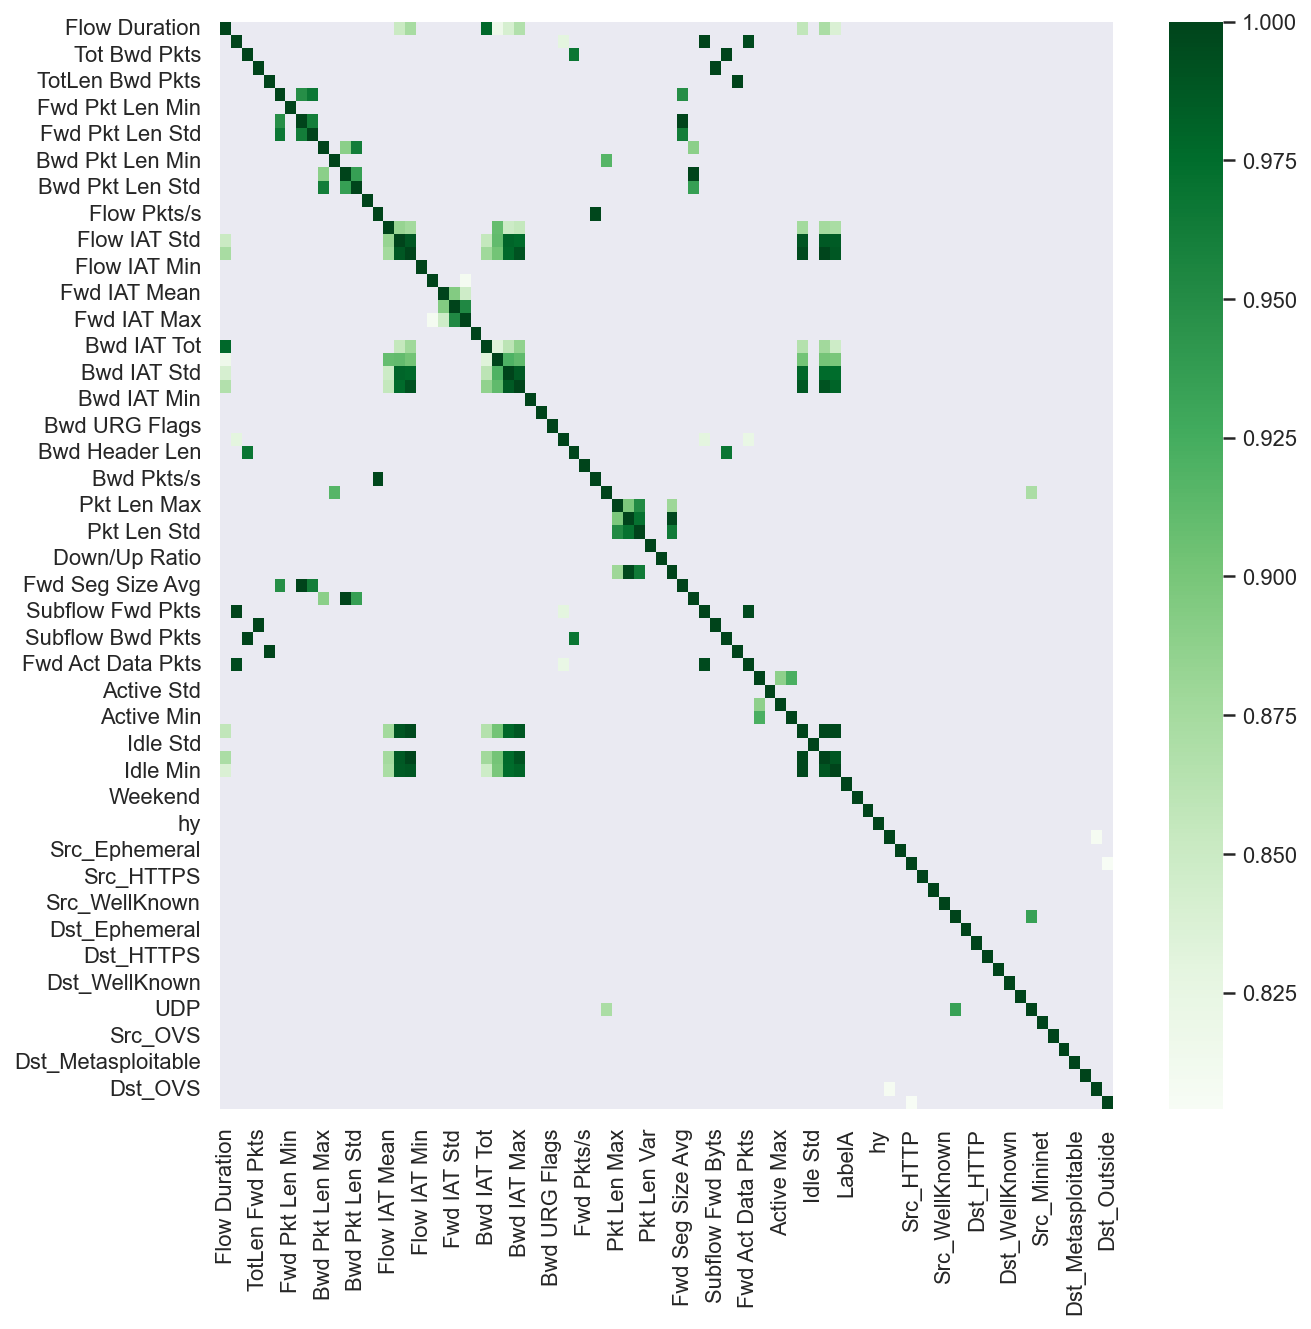

In [80]:
corr = dft.corr()
cor = dft.corr().abs()
c1 = cor.where(np.triu(np.ones(cor.shape), k=1).astype(bool))
high_cor = c1.stack().sort_values(ascending=False).drop_duplicates()
###################################################################################
st=(high_cor[high_cor>0.8]).size
################Drawing the map##########################################################
plt.figure(figsize=(10, 10)) 
sns.heatmap(cor[corr>0.8],cmap="Greens")
plt.show()

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


X = dft.copy()
y = X.pop("LabelA")

#X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    #random_state=42)


feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X, y)



RandomForestClassifier(random_state=0)

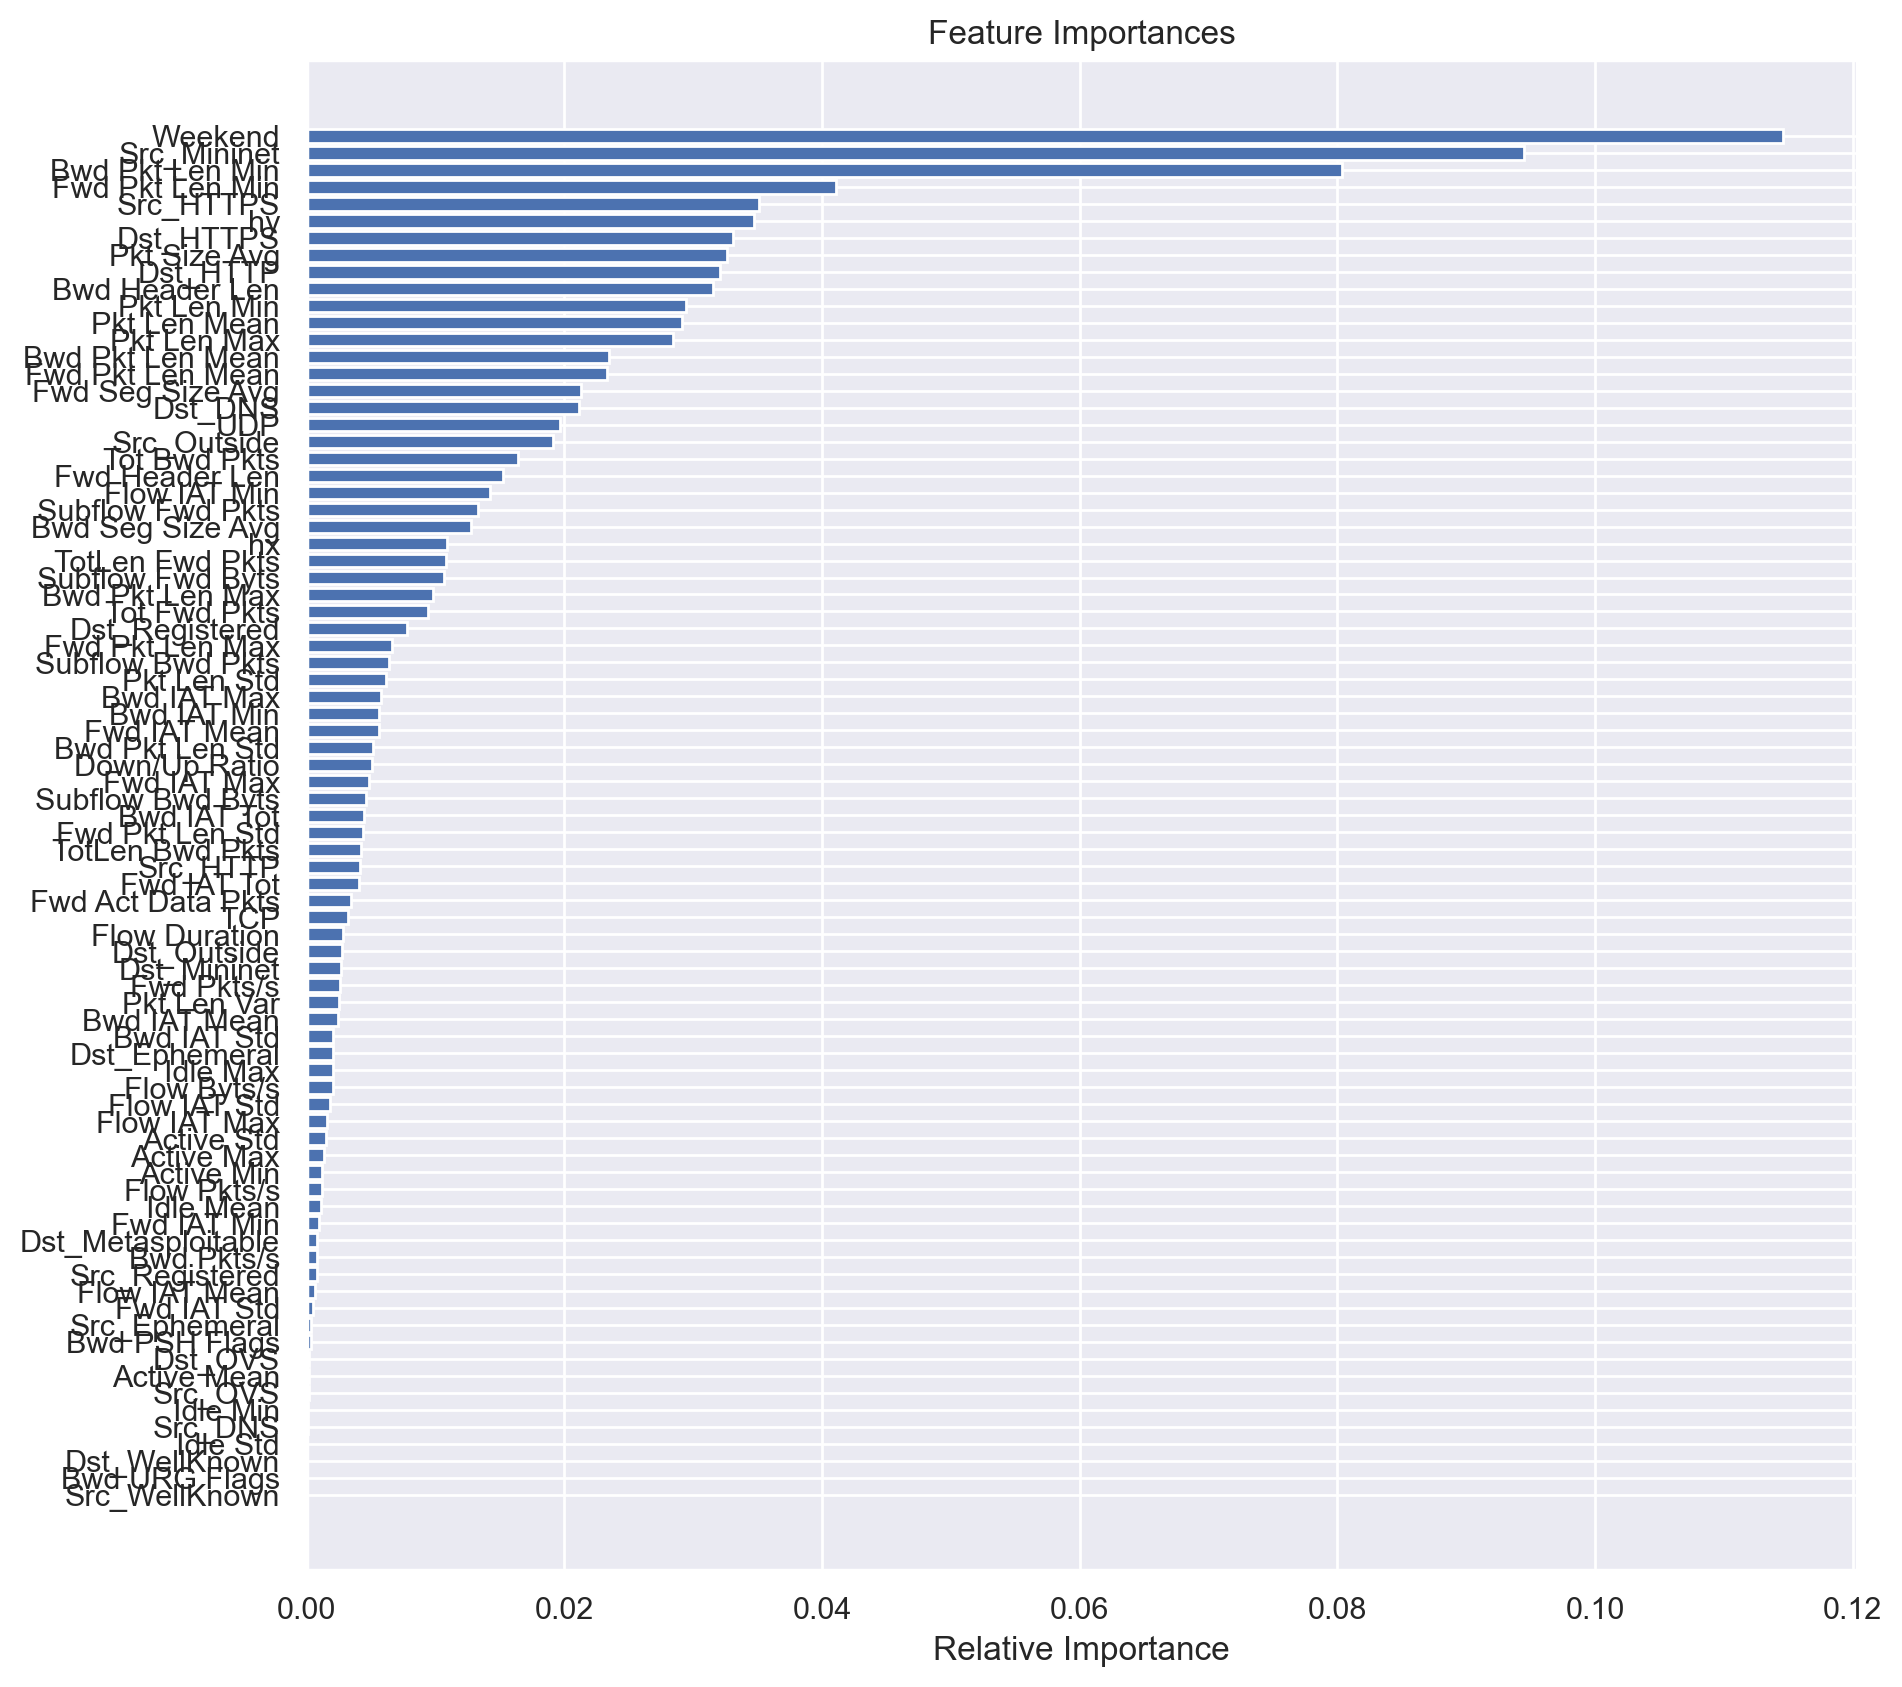

In [113]:
features = X.columns
importances = forest.feature_importances_
indices = np.argsort(importances)
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=100)


plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


<AxesSubplot:>

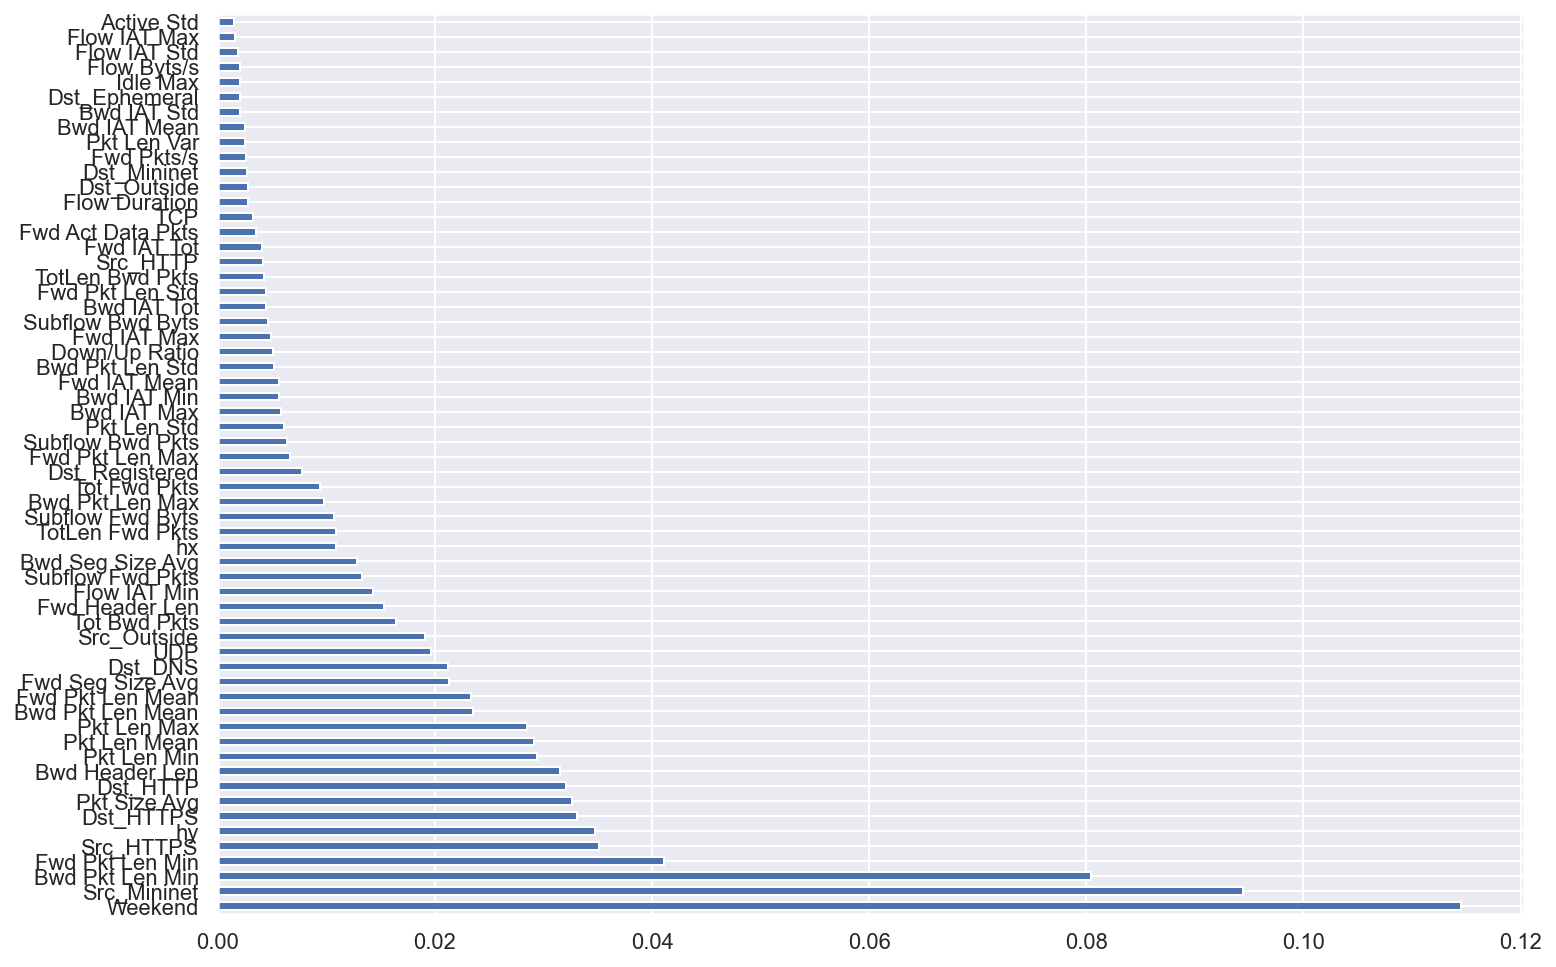

In [105]:
feat_importances = pd.Series(forest.feature_importances_, index=X.columns)
feat_importances.nlargest(60).plot(kind='barh')


# Correlaciones

In [114]:
cor = dft.corr()
c1 = cor.where(np.triu(np.ones(cor.shape), k=1).astype(bool))
high_cor = c1.stack().sort_values(ascending=False).drop_duplicates()
print("max corr:",high_cor.max(), ", min corr: ", high_cor.min())

## El valor de corte de las correlaciones
# No se han tratado los valores negativos porque podemos ver que ninguno supera el -0.85
thresh = 0.95
display(high_cor[high_cor>thresh])


max corr: 1.0 , min corr:  -0.8419702067364203


Tot Fwd Pkts      Subflow Fwd Pkts     1.000000
Flow IAT Max      Idle Max             0.999002
Flow Pkts/s       Bwd Pkts/s           0.998156
Idle Mean         Idle Min             0.997444
Pkt Len Mean      Pkt Size Avg         0.997205
Idle Mean         Idle Max             0.996978
Flow IAT Max      Idle Mean            0.995991
Tot Fwd Pkts      Fwd Act Data Pkts    0.995734
Flow IAT Max      Bwd IAT Max          0.991329
Bwd IAT Max       Idle Max             0.990457
Flow IAT Std      Idle Mean            0.989405
Idle Max          Idle Min             0.989192
Flow IAT Max      Idle Min             0.988220
Flow IAT Std      Flow IAT Max         0.988049
Bwd IAT Max       Idle Mean            0.988016
Flow IAT Std      Idle Max             0.987575
Bwd IAT Std       Bwd IAT Max          0.986331
Flow IAT Std      Idle Min             0.985805
Bwd IAT Max       Idle Min             0.980778
Flow IAT Std      Bwd IAT Std          0.979343
Bwd IAT Std       Idle Mean            0

# Features ordenadas por importancia (segun randomforest)

In [115]:
import operator

important_features_dict = {}
for idx, val in enumerate(forest.feature_importances_):
    important_features_dict[idx] = val

important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)
sortedlist = sorted(important_features_dict.items(), key=operator.itemgetter(1),reverse=True)

im_names_list=X.columns.values.tolist()
ifd={}
for i,j in sortedlist :
    print(im_names_list[(i)],":",j)
    ifd[im_names_list[(i)]]=j

Weekend : 0.11455264031776202
Src_Mininet : 0.0944452188279935
Bwd Pkt Len Min : 0.08038718093236275
Fwd Pkt Len Min : 0.041071022798769584
Src_HTTPS : 0.03512515828302468
hy : 0.034718247801576785
Dst_HTTPS : 0.03309426523292414
Pkt Size Avg : 0.03265983380735786
Dst_HTTP : 0.032079701564217654
Bwd Header Len : 0.03152577420593308
Pkt Len Min : 0.029424785372029385
Pkt Len Mean : 0.029101541025551694
Pkt Len Max : 0.0284464562092527
Bwd Pkt Len Mean : 0.023470417980371906
Fwd Pkt Len Mean : 0.023316710784191966
Fwd Seg Size Avg : 0.021315488904419852
Dst_DNS : 0.021169674829102893
UDP : 0.01964367337375669
Src_Outside : 0.019094829310052124
Tot Bwd Pkts : 0.016447760214652427
Fwd Header Len : 0.015261023180106477
Flow IAT Min : 0.014251245642204478
Subflow Fwd Pkts : 0.013281578625297545
Bwd Seg Size Avg : 0.012802238219582594
hx : 0.010887894139873056
TotLen Fwd Pkts : 0.010860124702516485
Subflow Fwd Byts : 0.010664085841760061
Bwd Pkt Len Max : 0.009789010871076509
Tot Fwd Pkts : 0

In [116]:
thresh = 0.95
st=(high_cor[high_cor>thresh]).size

In [117]:
corr = dft.corr() 

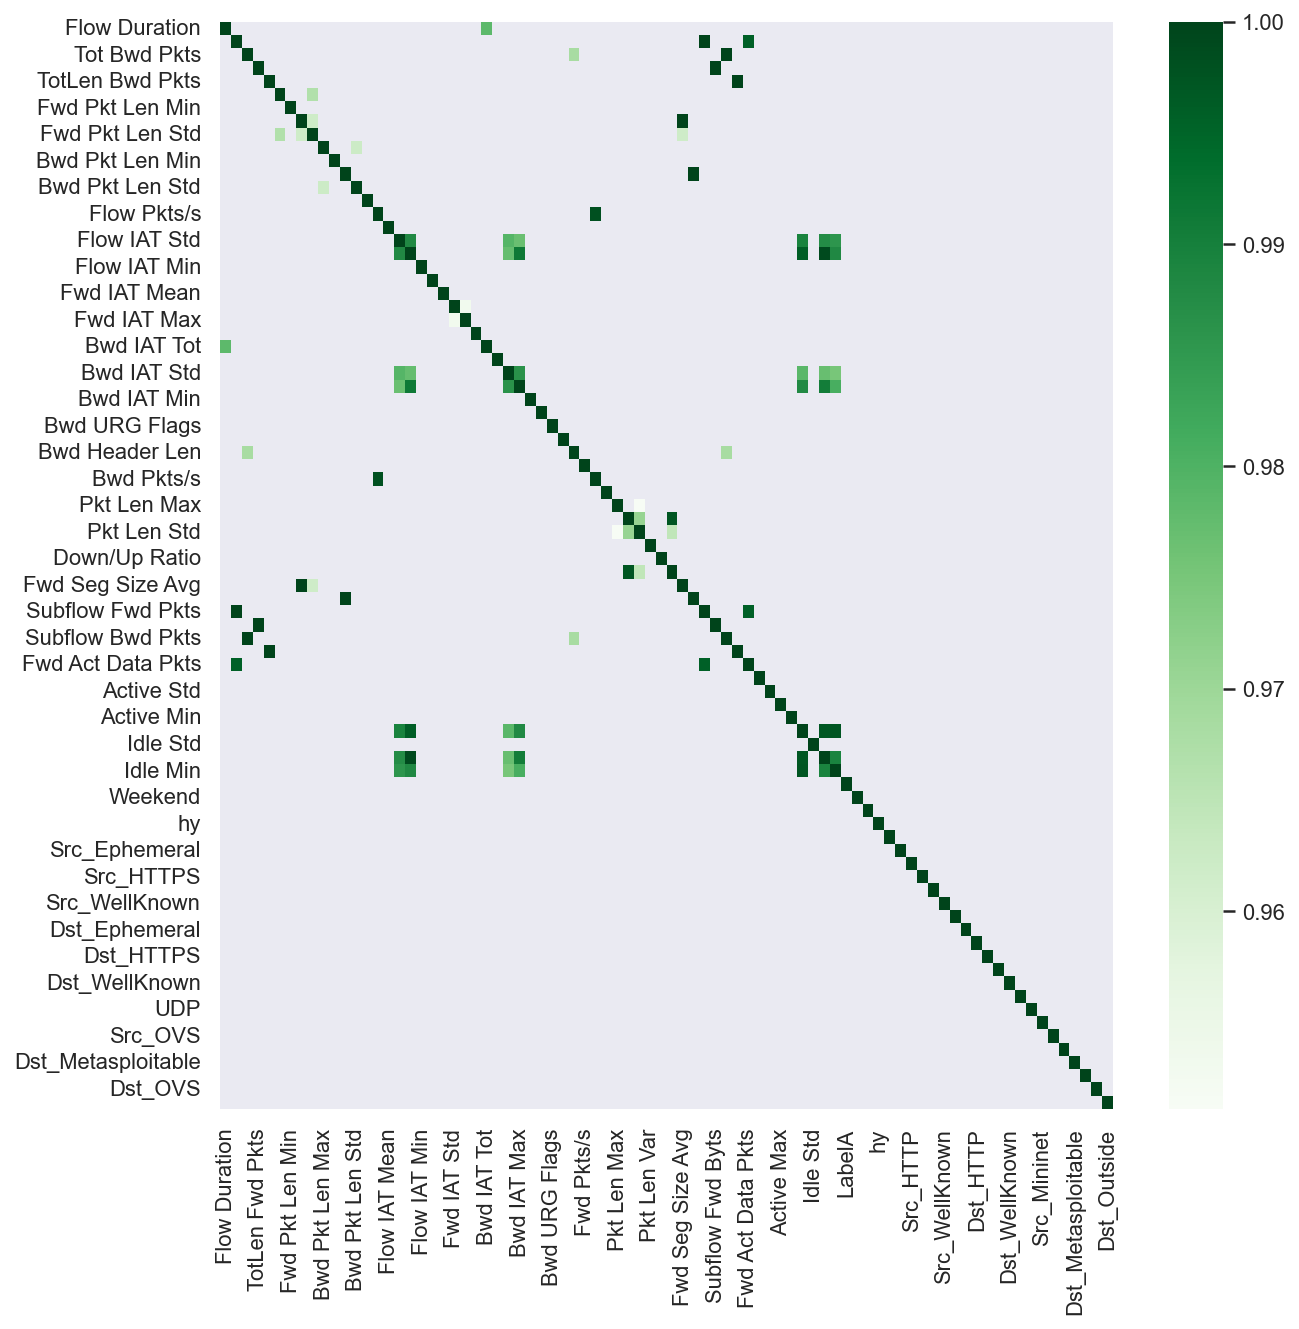

Tot Bwd Pkts      Subflow Bwd Pkts     1.000000
Flow IAT Max      Idle Max             0.999002
Flow Pkts/s       Bwd Pkts/s           0.998156
Idle Mean         Idle Min             0.997444
Pkt Len Mean      Pkt Size Avg         0.997205
Idle Mean         Idle Max             0.996978
Flow IAT Max      Idle Mean            0.995991
Subflow Fwd Pkts  Fwd Act Data Pkts    0.995734
Flow IAT Max      Bwd IAT Max          0.991329
Bwd IAT Max       Idle Max             0.990457
Flow IAT Std      Idle Mean            0.989405
Idle Max          Idle Min             0.989192
Flow IAT Max      Idle Min             0.988220
Flow IAT Std      Flow IAT Max         0.988049
Bwd IAT Max       Idle Mean            0.988016
Flow IAT Std      Idle Max             0.987575
Bwd IAT Std       Bwd IAT Max          0.986331
Flow IAT Std      Idle Min             0.985805
Bwd IAT Max       Idle Min             0.980778
Flow IAT Std      Bwd IAT Std          0.979343
Bwd IAT Std       Idle Mean            0

Still have  34 high correlations left
-------------------------------------------------------------
Correlation value is: 1.0
Tot Bwd Pkts  f0 has value: 0.016447760214652427
Subflow Bwd Pkts  f1 has value: 0.006376206390540892
drop Subflow Bwd Pkts
########################################################################


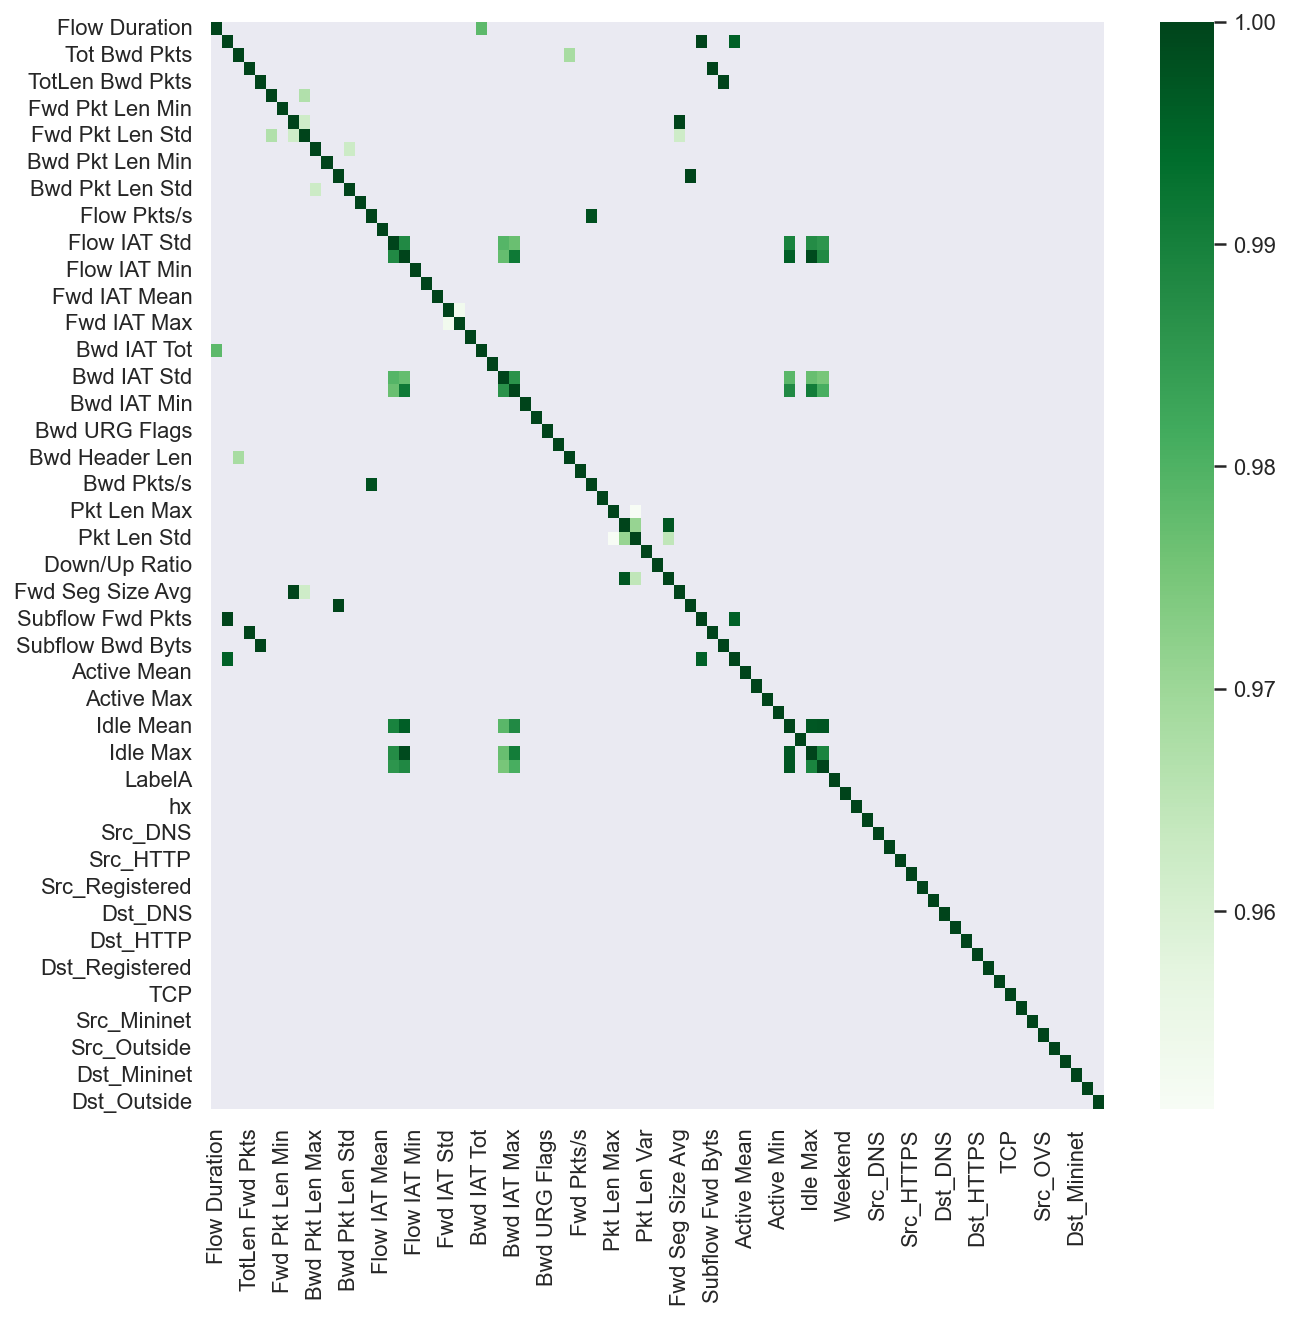

TotLen Fwd Pkts   Subflow Fwd Byts     1.000000
Flow IAT Max      Idle Max             0.999002
Flow Pkts/s       Bwd Pkts/s           0.998156
Idle Mean         Idle Min             0.997444
Pkt Len Mean      Pkt Size Avg         0.997205
Idle Mean         Idle Max             0.996978
Flow IAT Max      Idle Mean            0.995991
Subflow Fwd Pkts  Fwd Act Data Pkts    0.995734
Flow IAT Max      Bwd IAT Max          0.991329
Bwd IAT Max       Idle Max             0.990457
Flow IAT Std      Idle Mean            0.989405
Idle Max          Idle Min             0.989192
Flow IAT Max      Idle Min             0.988220
Flow IAT Std      Flow IAT Max         0.988049
Bwd IAT Max       Idle Mean            0.988016
Flow IAT Std      Idle Max             0.987575
Bwd IAT Std       Bwd IAT Max          0.986331
Flow IAT Std      Idle Min             0.985805
Bwd IAT Max       Idle Min             0.980778
Flow IAT Std      Bwd IAT Std          0.979343
Bwd IAT Std       Idle Mean            0

Still have  34 high correlations left
-------------------------------------------------------------
Correlation value is: 1.0
TotLen Fwd Pkts  f0 has value: 0.010103687991353317
Subflow Fwd Byts  f1 has value: 0.010605799277884197
drop TotLen Fwd Pkts
########################################################################


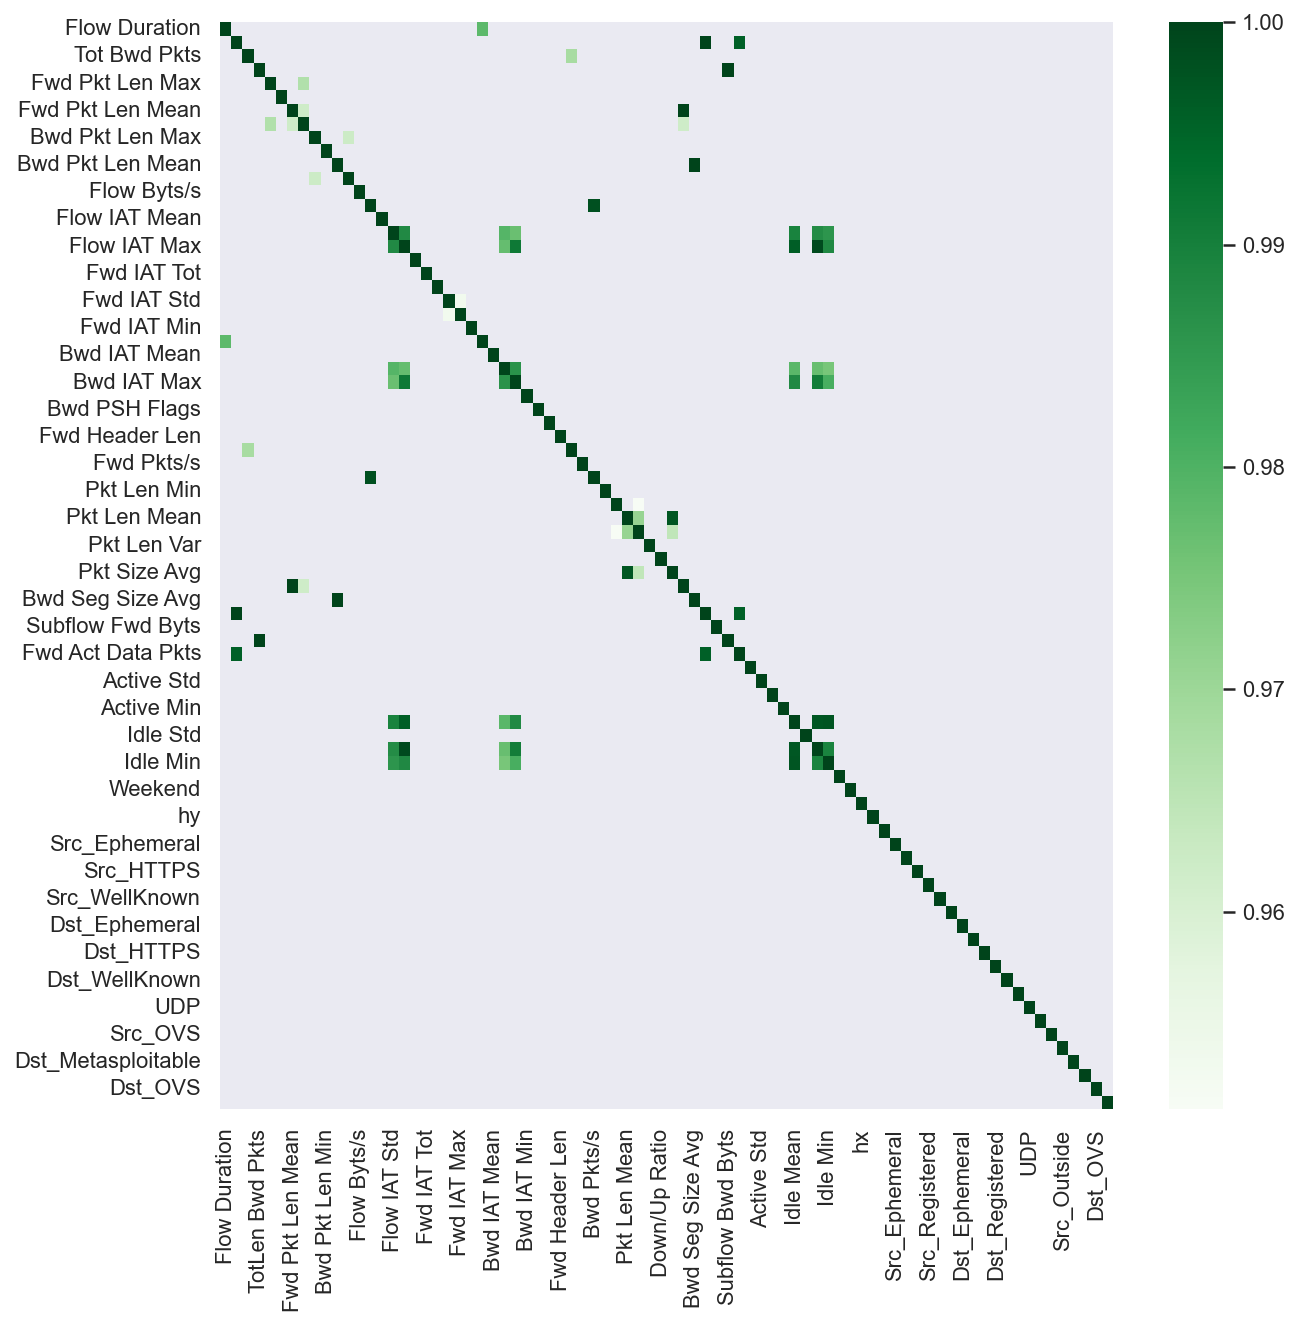

Tot Fwd Pkts      Subflow Fwd Pkts     1.000000
Flow IAT Max      Idle Max             0.999002
Flow Pkts/s       Bwd Pkts/s           0.998156
Idle Mean         Idle Min             0.997444
Pkt Len Mean      Pkt Size Avg         0.997205
Idle Mean         Idle Max             0.996978
Flow IAT Max      Idle Mean            0.995991
Subflow Fwd Pkts  Fwd Act Data Pkts    0.995734
Flow IAT Max      Bwd IAT Max          0.991329
Bwd IAT Max       Idle Max             0.990457
Flow IAT Std      Idle Mean            0.989405
Idle Max          Idle Min             0.989192
Flow IAT Max      Idle Min             0.988220
Flow IAT Std      Flow IAT Max         0.988049
Bwd IAT Max       Idle Mean            0.988016
Flow IAT Std      Idle Max             0.987575
Bwd IAT Std       Bwd IAT Max          0.986331
Flow IAT Std      Idle Min             0.985805
Bwd IAT Max       Idle Min             0.980778
Flow IAT Std      Bwd IAT Std          0.979343
Bwd IAT Std       Idle Mean            0

Still have  34 high correlations left
-------------------------------------------------------------
Correlation value is: 1.0
Tot Fwd Pkts  f0 has value: 0.010689926127872194
Subflow Fwd Pkts  f1 has value: 0.005709291224388665
drop Subflow Fwd Pkts
########################################################################


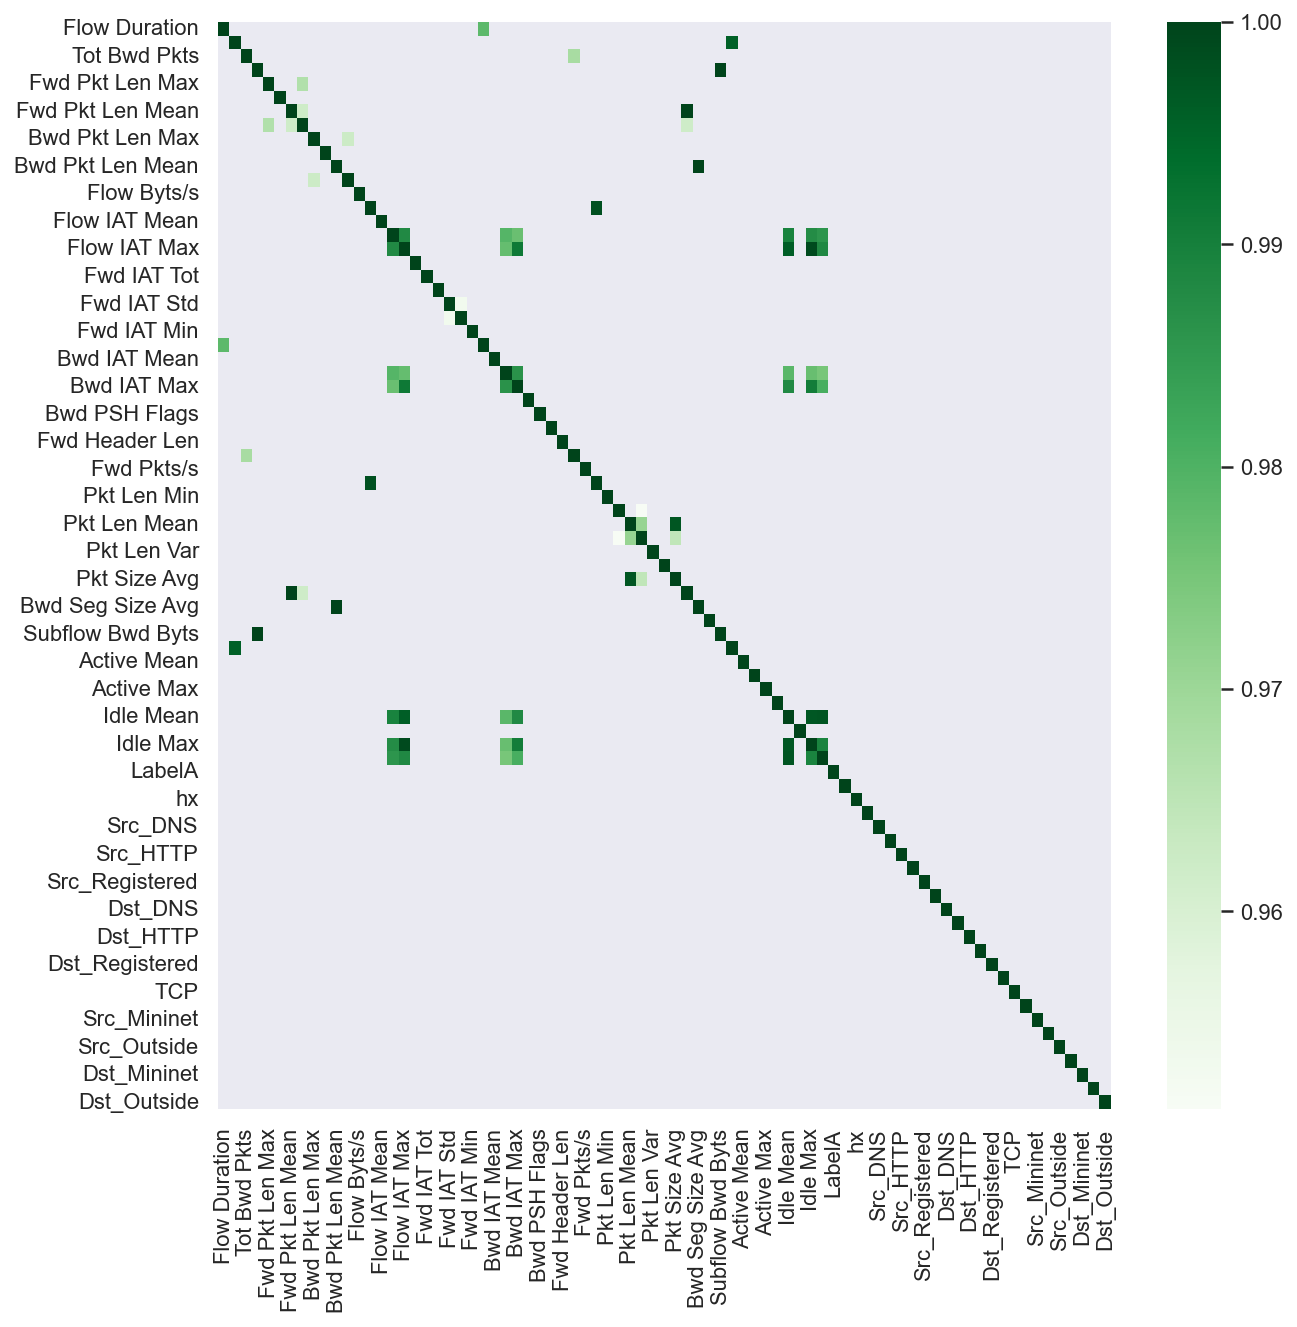

Fwd Pkt Len Mean  Fwd Seg Size Avg     1.000000
Flow IAT Max      Idle Max             0.999002
Flow Pkts/s       Bwd Pkts/s           0.998156
Idle Mean         Idle Min             0.997444
Pkt Len Mean      Pkt Size Avg         0.997205
Idle Mean         Idle Max             0.996978
Flow IAT Max      Idle Mean            0.995991
Tot Fwd Pkts      Fwd Act Data Pkts    0.995734
Flow IAT Max      Bwd IAT Max          0.991329
Bwd IAT Max       Idle Max             0.990457
Flow IAT Std      Idle Mean            0.989405
Idle Max          Idle Min             0.989192
Flow IAT Max      Idle Min             0.988220
Flow IAT Std      Flow IAT Max         0.988049
Bwd IAT Max       Idle Mean            0.988016
Flow IAT Std      Idle Max             0.987575
Bwd IAT Std       Bwd IAT Max          0.986331
Flow IAT Std      Idle Min             0.985805
Bwd IAT Max       Idle Min             0.980778
Flow IAT Std      Bwd IAT Std          0.979343
Bwd IAT Std       Idle Mean            0

Still have  34 high correlations left
-------------------------------------------------------------
Correlation value is: 1.0
Fwd Pkt Len Mean  f0 has value: 0.021944828811108045
Fwd Seg Size Avg  f1 has value: 0.012790913042977534
drop Fwd Seg Size Avg
########################################################################


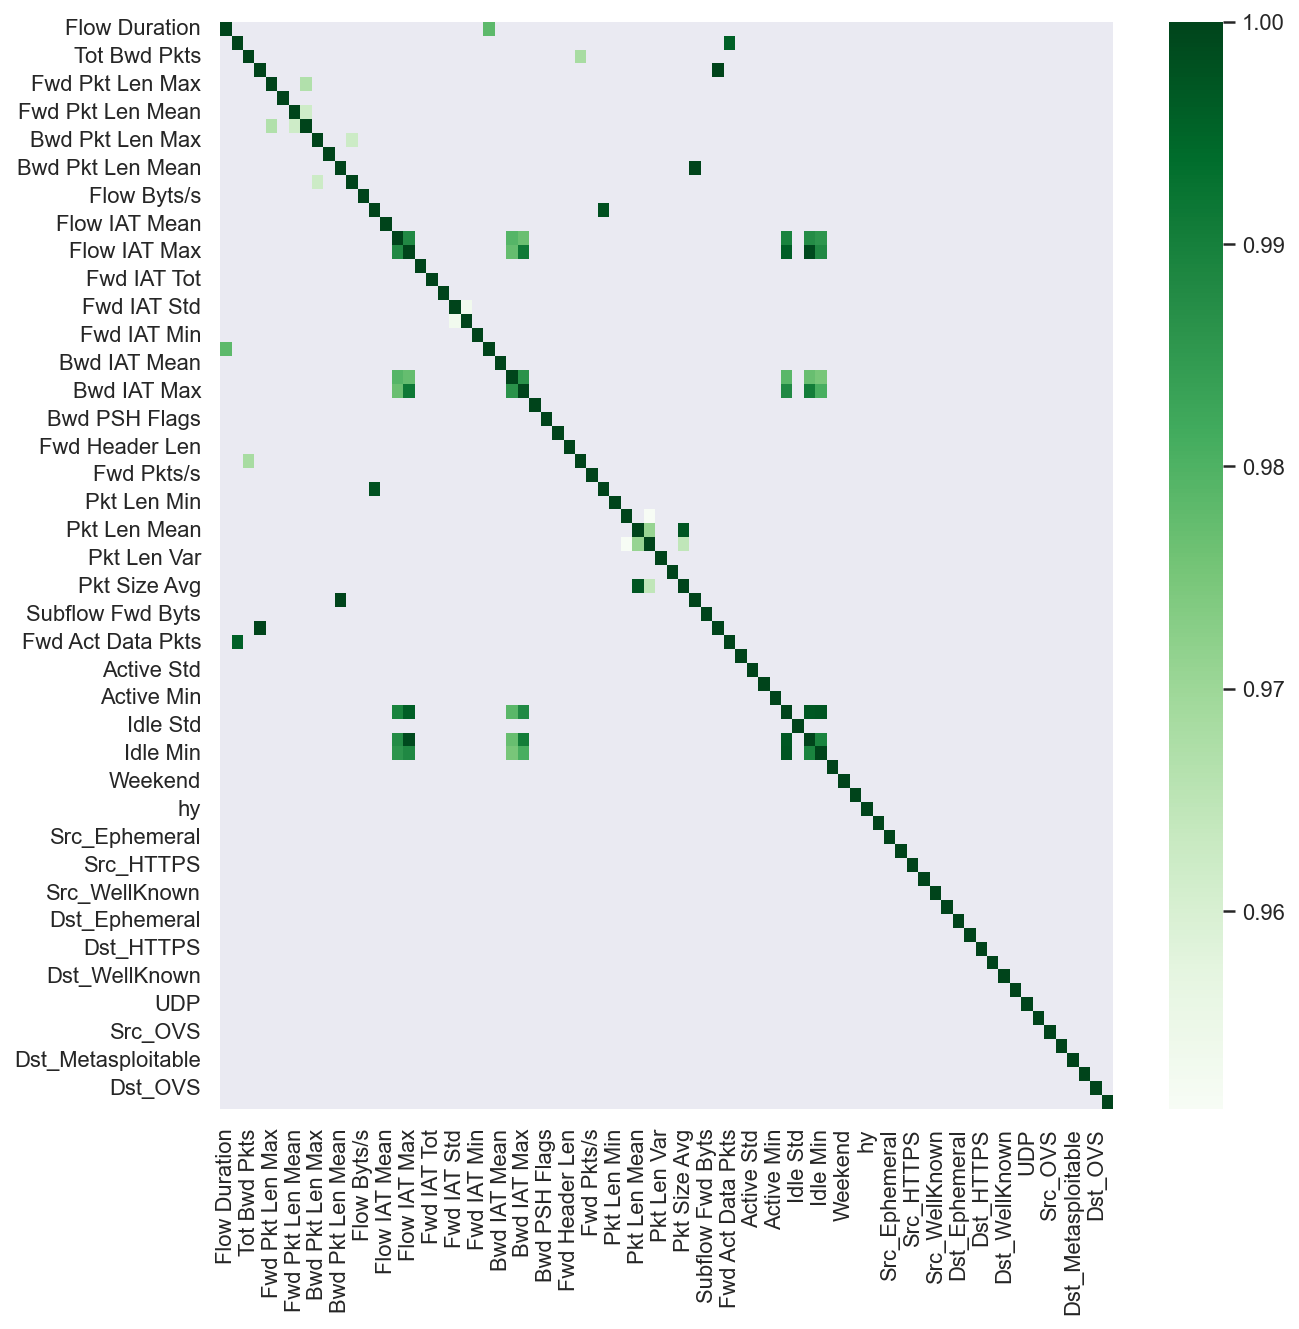

Bwd Pkt Len Mean  Bwd Seg Size Avg     1.000000
Flow IAT Max      Idle Max             0.999002
Flow Pkts/s       Bwd Pkts/s           0.998156
Idle Mean         Idle Min             0.997444
Pkt Len Mean      Pkt Size Avg         0.997205
Idle Mean         Idle Max             0.996978
Flow IAT Max      Idle Mean            0.995991
Tot Fwd Pkts      Fwd Act Data Pkts    0.995734
Flow IAT Max      Bwd IAT Max          0.991329
Bwd IAT Max       Idle Max             0.990457
Flow IAT Std      Idle Mean            0.989405
Idle Max          Idle Min             0.989192
Flow IAT Max      Idle Min             0.988220
Flow IAT Std      Flow IAT Max         0.988049
Bwd IAT Max       Idle Mean            0.988016
Flow IAT Std      Idle Max             0.987575
Bwd IAT Std       Bwd IAT Max          0.986331
Flow IAT Std      Idle Min             0.985805
Bwd IAT Max       Idle Min             0.980778
Flow IAT Std      Bwd IAT Std          0.979343
Bwd IAT Std       Idle Mean            0

Still have  34 high correlations left
-------------------------------------------------------------
Correlation value is: 1.0
Bwd Pkt Len Mean  f0 has value: 0.018601078173150626
Bwd Seg Size Avg  f1 has value: 0.019039088168185468
drop Bwd Pkt Len Mean
########################################################################


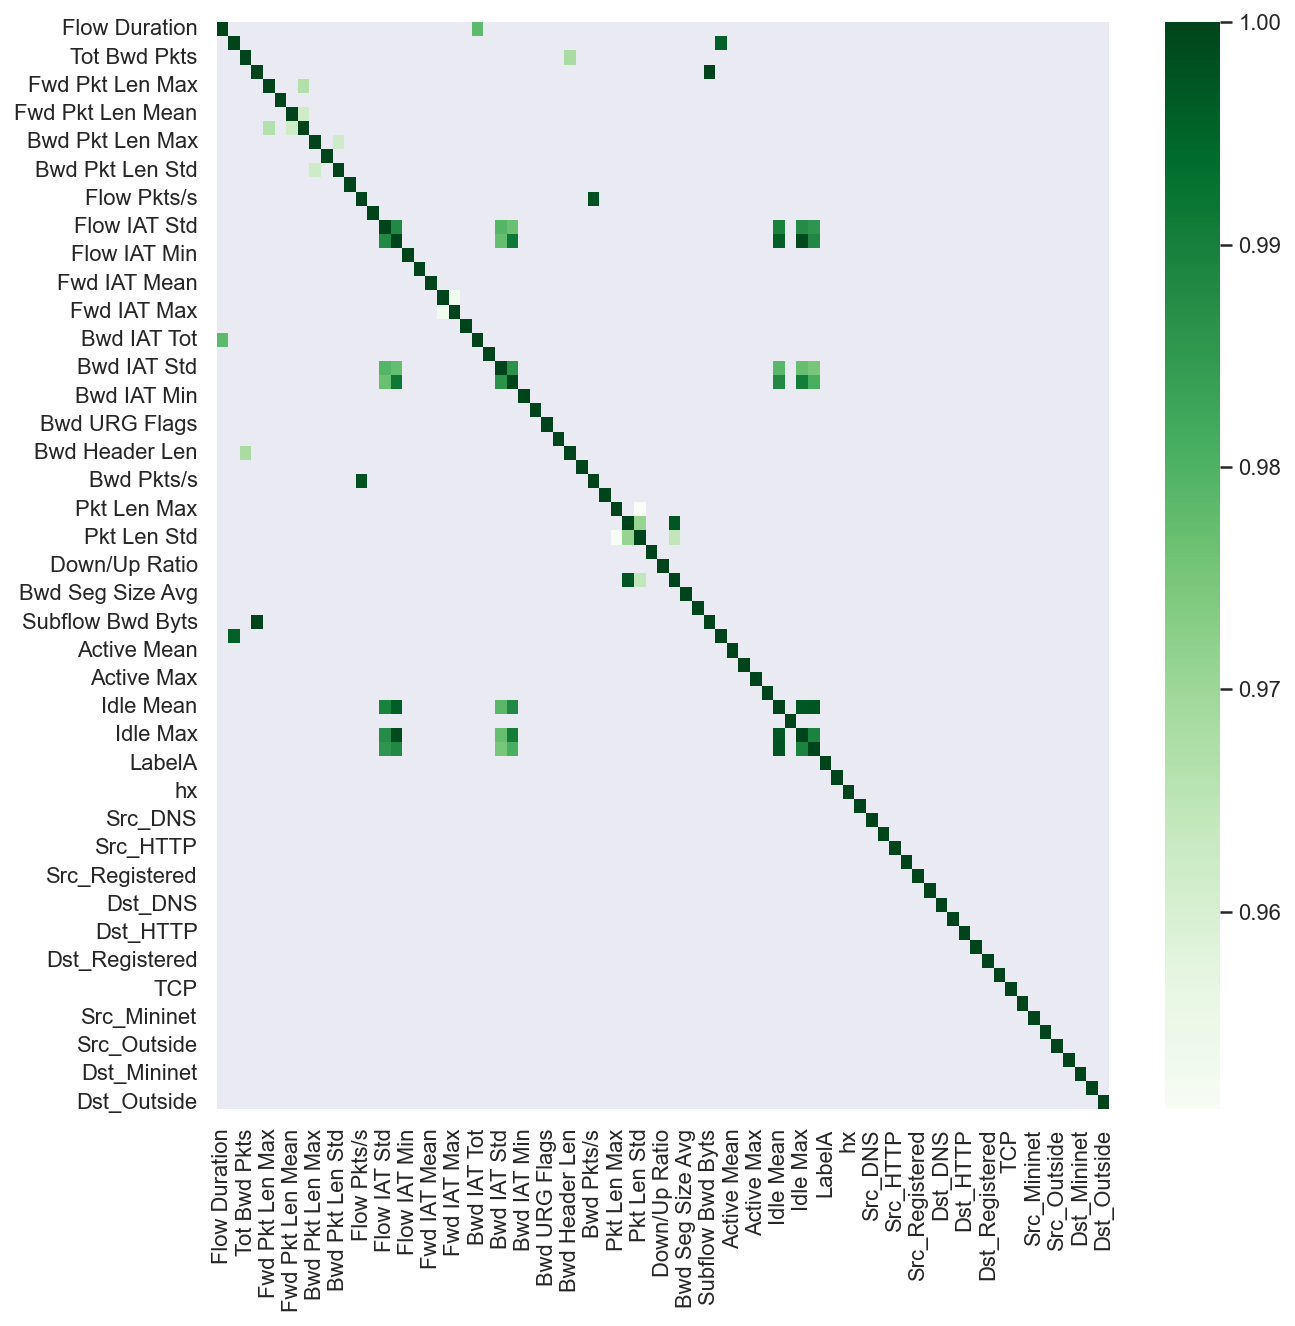

TotLen Bwd Pkts   Subflow Bwd Byts     1.000000
Flow IAT Max      Idle Max             0.999002
Flow Pkts/s       Bwd Pkts/s           0.998156
Idle Mean         Idle Min             0.997444
Pkt Len Mean      Pkt Size Avg         0.997205
Idle Mean         Idle Max             0.996978
Flow IAT Max      Idle Mean            0.995991
Tot Fwd Pkts      Fwd Act Data Pkts    0.995734
Flow IAT Max      Bwd IAT Max          0.991329
Bwd IAT Max       Idle Max             0.990457
Flow IAT Std      Idle Mean            0.989405
Idle Max          Idle Min             0.989192
Flow IAT Max      Idle Min             0.988220
Flow IAT Std      Flow IAT Max         0.988049
Bwd IAT Max       Idle Mean            0.988016
Flow IAT Std      Idle Max             0.987575
Bwd IAT Std       Bwd IAT Max          0.986331
Flow IAT Std      Idle Min             0.985805
Bwd IAT Max       Idle Min             0.980778
Flow IAT Std      Bwd IAT Std          0.979343
Bwd IAT Std       Idle Mean            0

Still have  34 high correlations left
-------------------------------------------------------------
Correlation value is: 1.0
TotLen Bwd Pkts  f0 has value: 0.013673567453955154
Subflow Bwd Byts  f1 has value: 0.010003457131289598
drop Subflow Bwd Byts
########################################################################


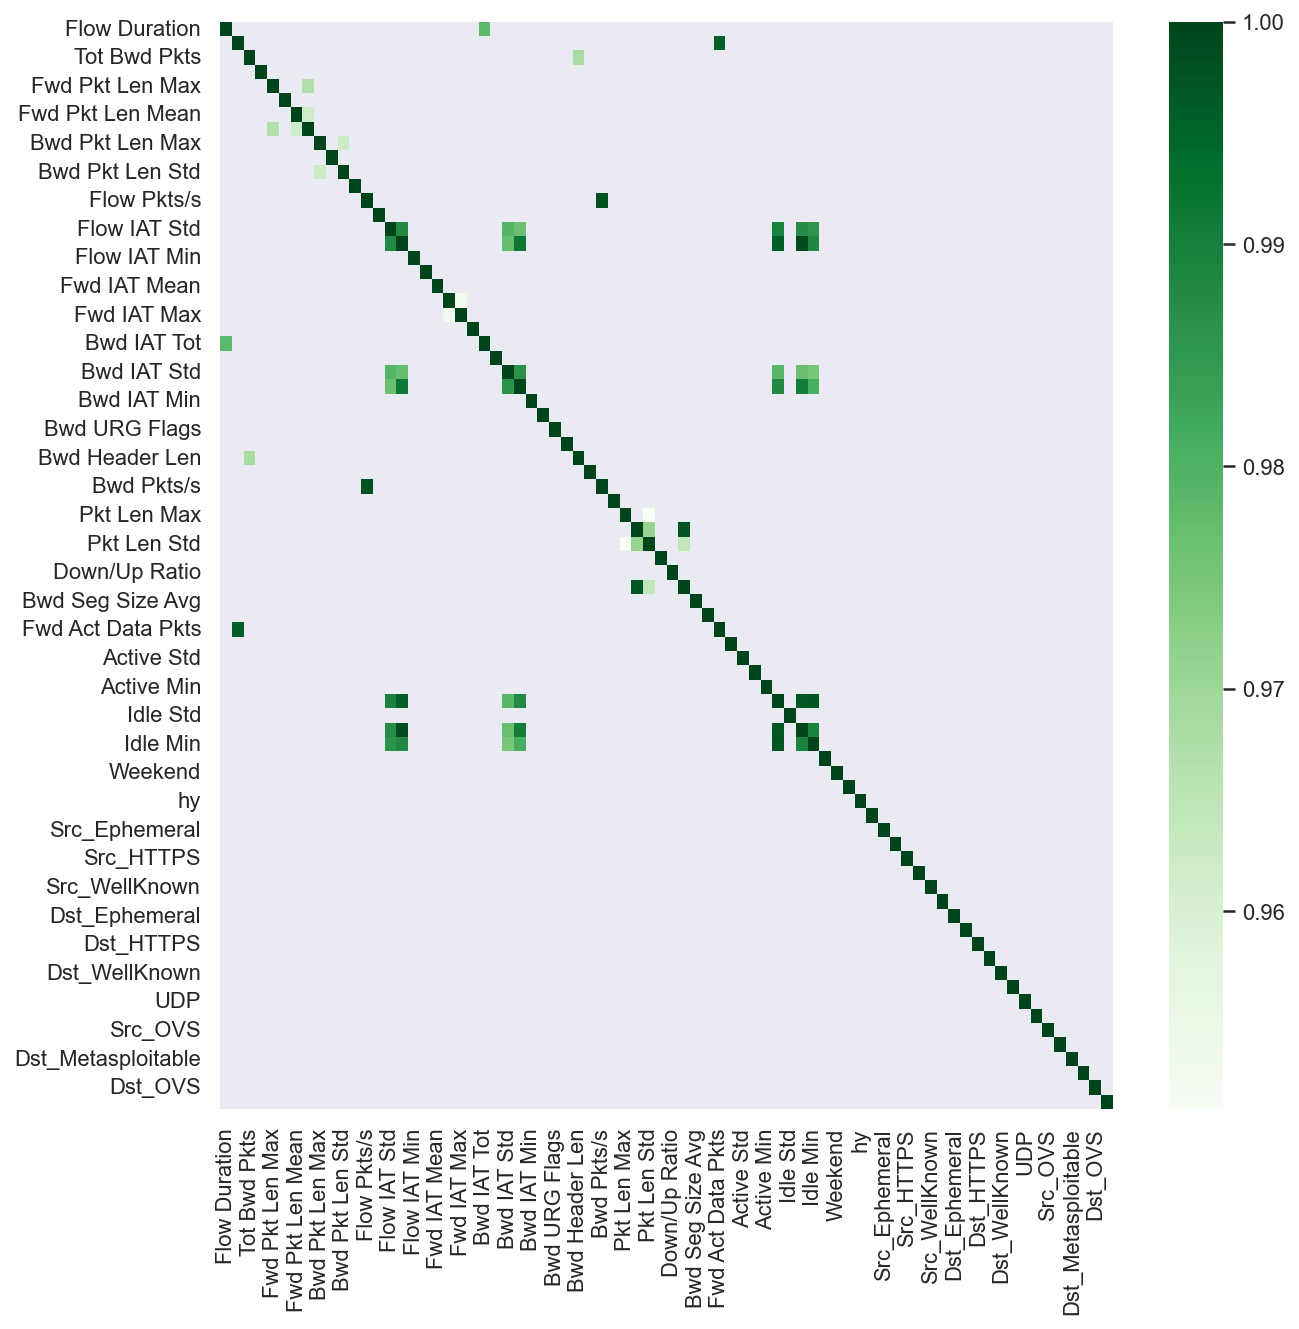

Flow IAT Max      Idle Max             0.999002
Flow Pkts/s       Bwd Pkts/s           0.998156
Idle Mean         Idle Min             0.997444
Pkt Len Mean      Pkt Size Avg         0.997205
Idle Mean         Idle Max             0.996978
Flow IAT Max      Idle Mean            0.995991
Tot Fwd Pkts      Fwd Act Data Pkts    0.995734
Flow IAT Max      Bwd IAT Max          0.991329
Bwd IAT Max       Idle Max             0.990457
Flow IAT Std      Idle Mean            0.989405
Idle Max          Idle Min             0.989192
Flow IAT Max      Idle Min             0.988220
Flow IAT Std      Flow IAT Max         0.988049
Bwd IAT Max       Idle Mean            0.988016
Flow IAT Std      Idle Max             0.987575
Bwd IAT Std       Bwd IAT Max          0.986331
Flow IAT Std      Idle Min             0.985805
Bwd IAT Max       Idle Min             0.980778
Flow IAT Std      Bwd IAT Std          0.979343
Bwd IAT Std       Idle Mean            0.978693
Flow Duration     Bwd IAT Tot          0

Still have  33 high correlations left
-------------------------------------------------------------
Correlation value is: 0.9990020458376121
Flow IAT Max  f0 has value: 0.0032515643724046715
Idle Max  f1 has value: 0.0013723933097320807
drop Idle Max
########################################################################


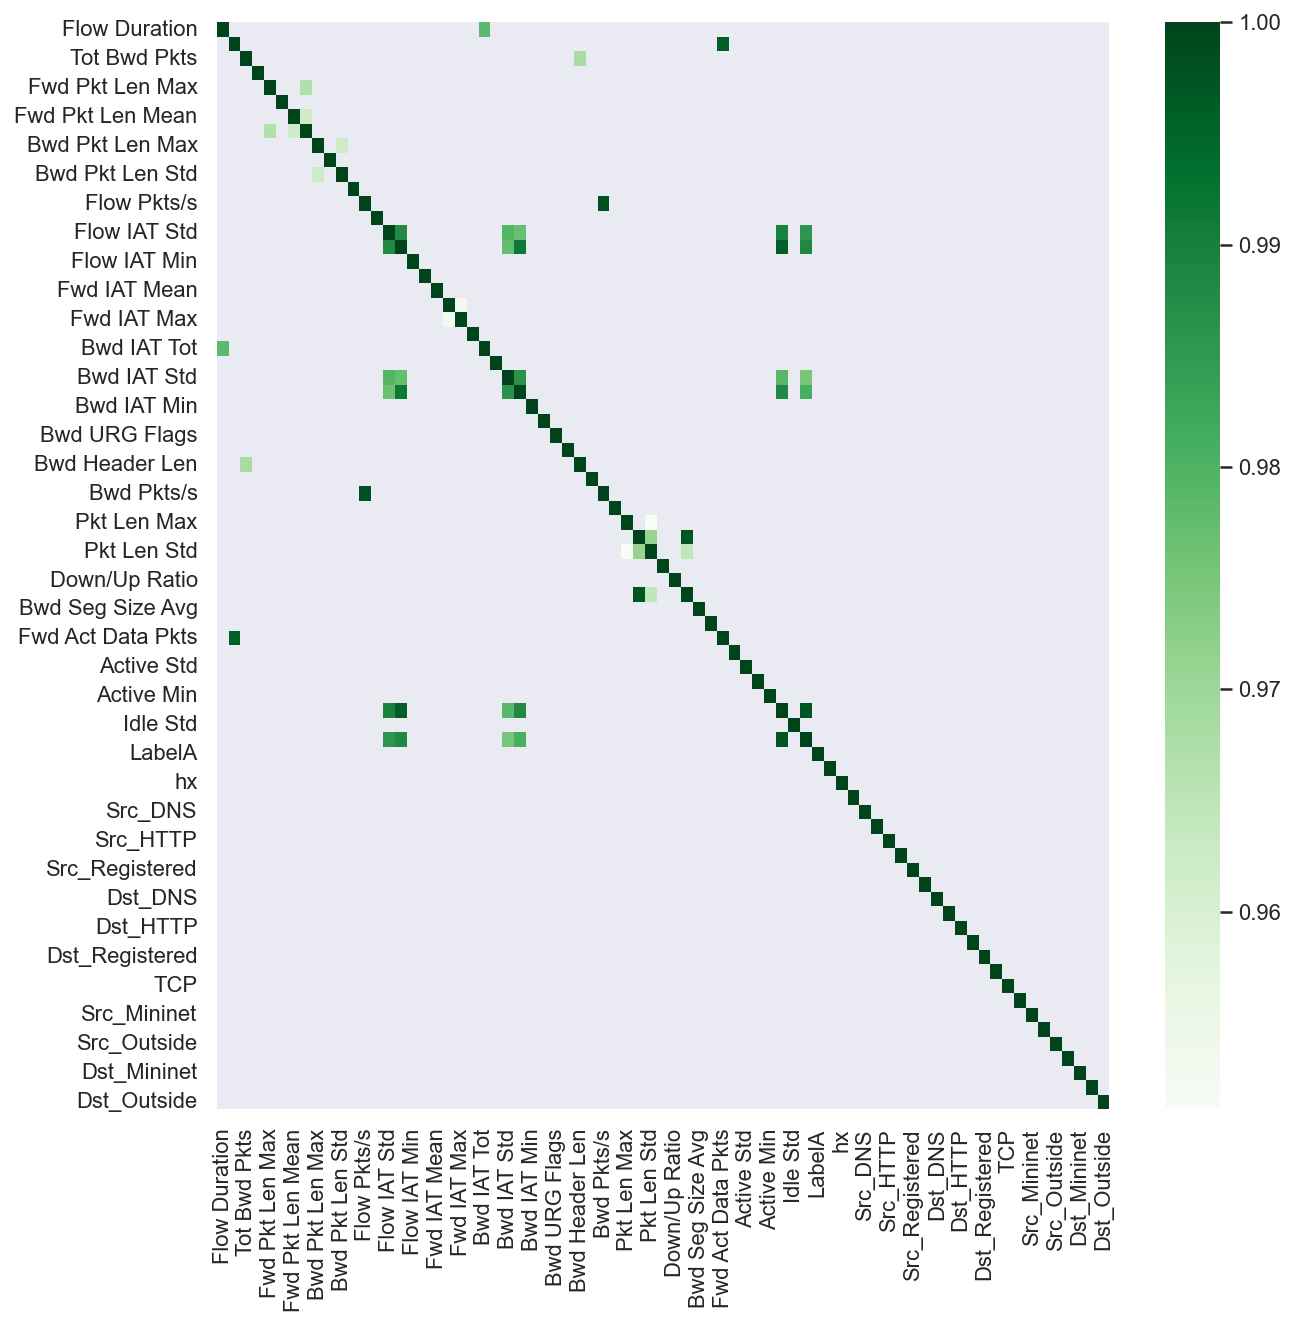

Flow Pkts/s       Bwd Pkts/s           0.998156
Idle Mean         Idle Min             0.997444
Pkt Len Mean      Pkt Size Avg         0.997205
Flow IAT Max      Idle Mean            0.995991
Tot Fwd Pkts      Fwd Act Data Pkts    0.995734
Flow IAT Max      Bwd IAT Max          0.991329
Flow IAT Std      Idle Mean            0.989405
Flow IAT Max      Idle Min             0.988220
Flow IAT Std      Flow IAT Max         0.988049
Bwd IAT Max       Idle Mean            0.988016
Bwd IAT Std       Bwd IAT Max          0.986331
Flow IAT Std      Idle Min             0.985805
Bwd IAT Max       Idle Min             0.980778
Flow IAT Std      Bwd IAT Std          0.979343
Bwd IAT Std       Idle Mean            0.978693
Flow Duration     Bwd IAT Tot          0.978404
Flow IAT Max      Bwd IAT Std          0.977452
Flow IAT Std      Bwd IAT Max          0.976821
Bwd IAT Std       Idle Min             0.975012
Pkt Len Mean      Pkt Len Std          0.970948
Tot Bwd Pkts      Bwd Header Len       0

Still have  27 high correlations left
-------------------------------------------------------------
Correlation value is: 0.9981557250485367
Flow Pkts/s  f0 has value: 0.0012237658000272727
Bwd Pkts/s  f1 has value: 0.0018097861071182013
drop Flow Pkts/s
########################################################################


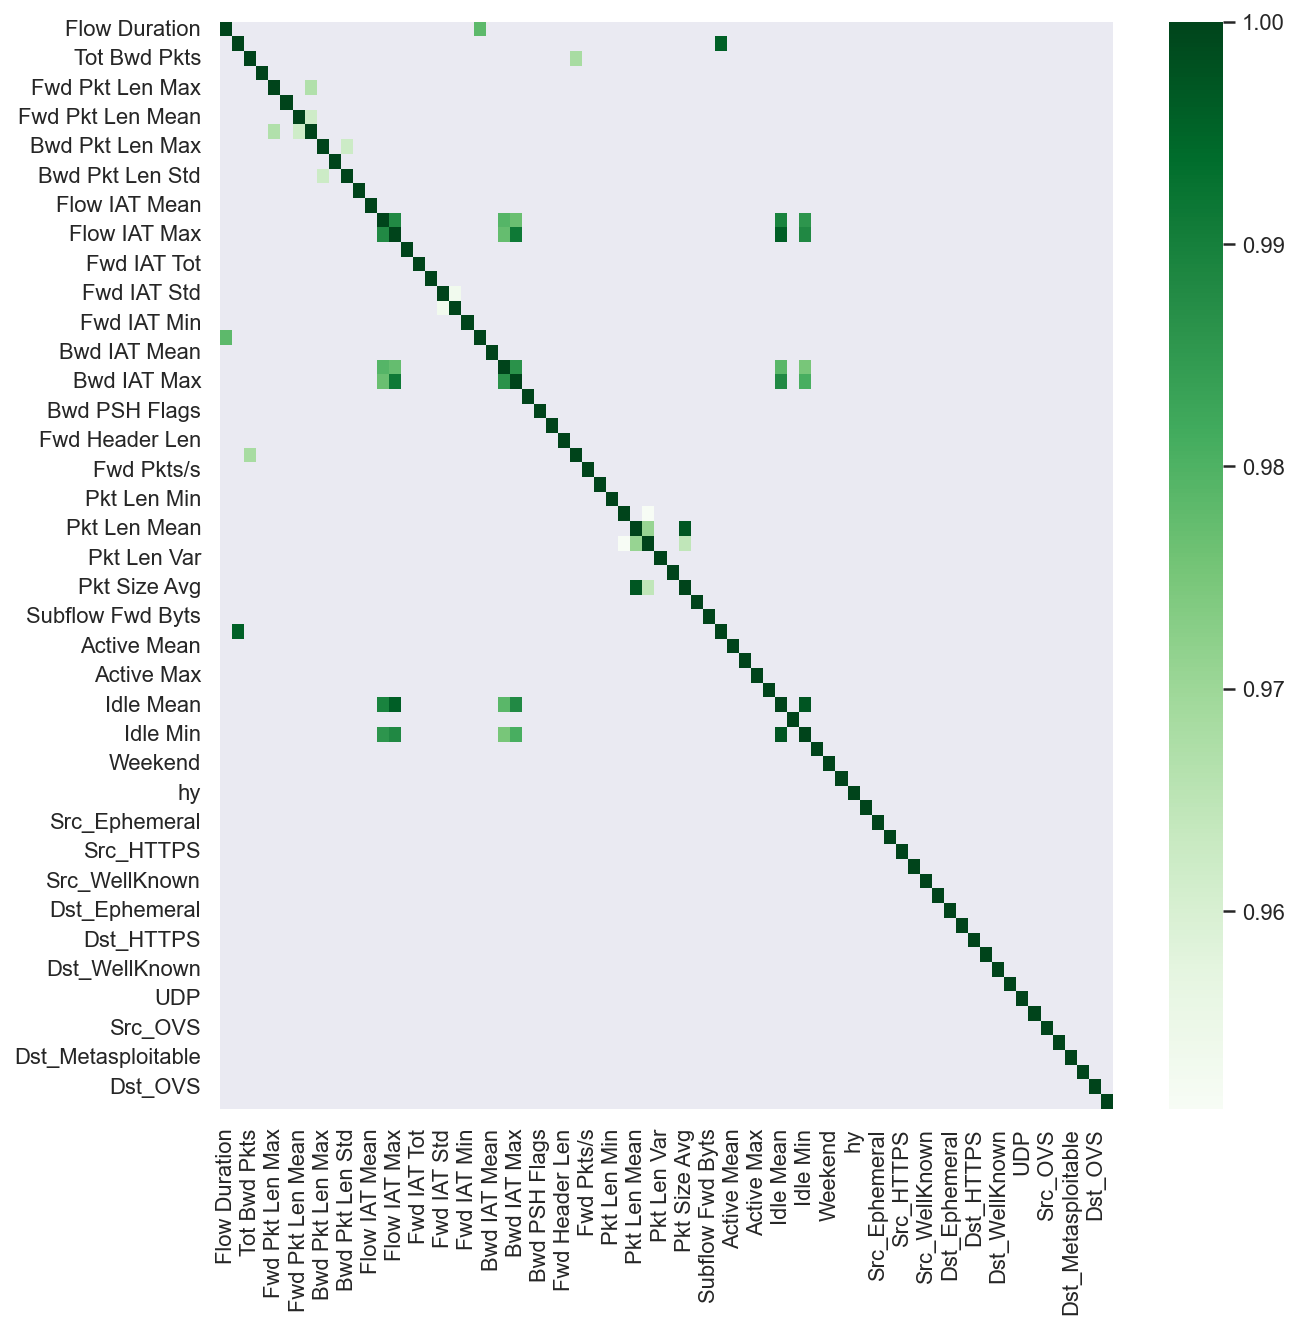

Idle Mean         Idle Min             0.997444
Pkt Len Mean      Pkt Size Avg         0.997205
Flow IAT Max      Idle Mean            0.995991
Tot Fwd Pkts      Fwd Act Data Pkts    0.995734
Flow IAT Max      Bwd IAT Max          0.991329
Flow IAT Std      Idle Mean            0.989405
Flow IAT Max      Idle Min             0.988220
Flow IAT Std      Flow IAT Max         0.988049
Bwd IAT Max       Idle Mean            0.988016
Bwd IAT Std       Bwd IAT Max          0.986331
Flow IAT Std      Idle Min             0.985805
Bwd IAT Max       Idle Min             0.980778
Flow IAT Std      Bwd IAT Std          0.979343
Bwd IAT Std       Idle Mean            0.978693
Flow Duration     Bwd IAT Tot          0.978404
Flow IAT Max      Bwd IAT Std          0.977452
Flow IAT Std      Bwd IAT Max          0.976821
Bwd IAT Std       Idle Min             0.975012
Pkt Len Mean      Pkt Len Std          0.970948
Tot Bwd Pkts      Bwd Header Len       0.968349
Fwd Pkt Len Max   Fwd Pkt Len Std      0

Still have  26 high correlations left
-------------------------------------------------------------
Correlation value is: 0.99744413446331
Idle Mean  f0 has value: 0.001552122300637768
Idle Min  f1 has value: 0.0021239406461832336
drop Idle Mean
########################################################################


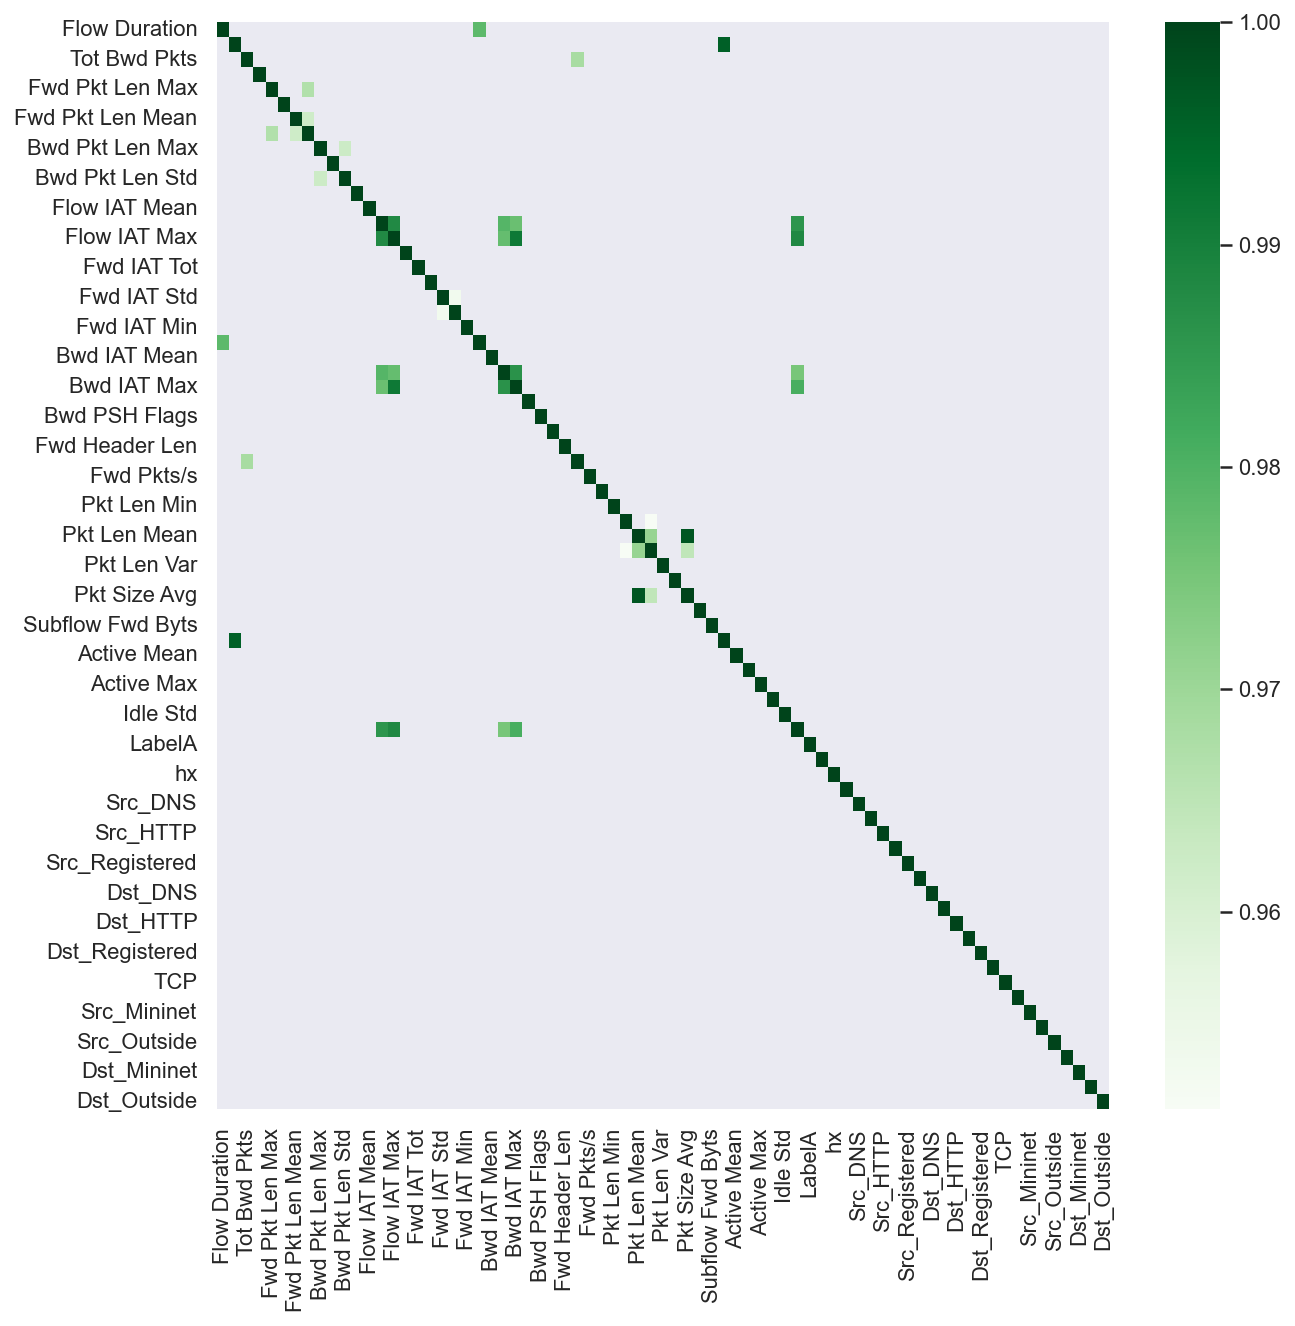

Pkt Len Mean      Pkt Size Avg         0.997205
Tot Fwd Pkts      Fwd Act Data Pkts    0.995734
Flow IAT Max      Bwd IAT Max          0.991329
                  Idle Min             0.988220
Flow IAT Std      Flow IAT Max         0.988049
Bwd IAT Std       Bwd IAT Max          0.986331
Flow IAT Std      Idle Min             0.985805
Bwd IAT Max       Idle Min             0.980778
Flow IAT Std      Bwd IAT Std          0.979343
Flow Duration     Bwd IAT Tot          0.978404
Flow IAT Max      Bwd IAT Std          0.977452
Flow IAT Std      Bwd IAT Max          0.976821
Bwd IAT Std       Idle Min             0.975012
Pkt Len Mean      Pkt Len Std          0.970948
Tot Bwd Pkts      Bwd Header Len       0.968349
Fwd Pkt Len Max   Fwd Pkt Len Std      0.966866
Pkt Len Std       Pkt Size Avg         0.964483
Bwd Pkt Len Max   Bwd Pkt Len Std      0.962197
Fwd Pkt Len Mean  Fwd Pkt Len Std      0.961831
Fwd IAT Std       Fwd IAT Max          0.953052
Pkt Len Max       Pkt Len Std          0

Still have  21 high correlations left
-------------------------------------------------------------
Correlation value is: 0.9972051999607302
Pkt Len Mean  f0 has value: 0.009126213499528328
Pkt Size Avg  f1 has value: 0.01851900939541671
drop Pkt Len Mean
########################################################################


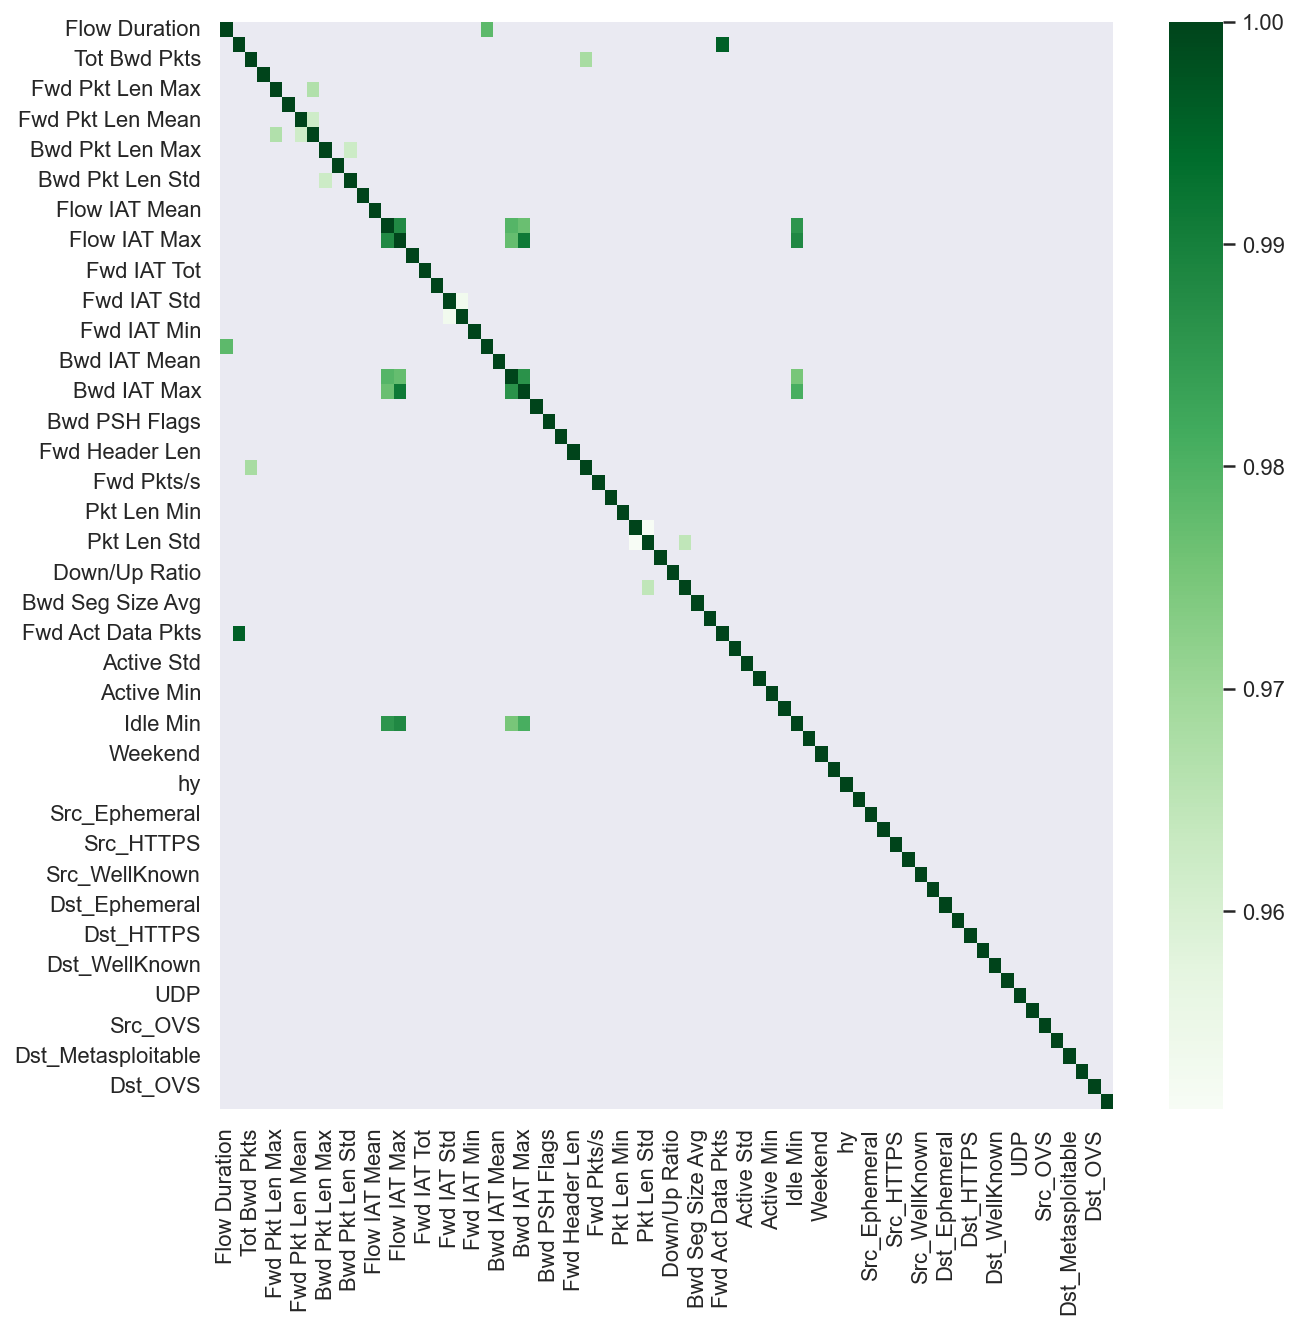

Tot Fwd Pkts      Fwd Act Data Pkts    0.995734
Flow IAT Max      Bwd IAT Max          0.991329
                  Idle Min             0.988220
Flow IAT Std      Flow IAT Max         0.988049
Bwd IAT Std       Bwd IAT Max          0.986331
Flow IAT Std      Idle Min             0.985805
Bwd IAT Max       Idle Min             0.980778
Flow IAT Std      Bwd IAT Std          0.979343
Flow Duration     Bwd IAT Tot          0.978404
Flow IAT Max      Bwd IAT Std          0.977452
Flow IAT Std      Bwd IAT Max          0.976821
Bwd IAT Std       Idle Min             0.975012
Tot Bwd Pkts      Bwd Header Len       0.968349
Fwd Pkt Len Max   Fwd Pkt Len Std      0.966866
Pkt Len Std       Pkt Size Avg         0.964483
Bwd Pkt Len Max   Bwd Pkt Len Std      0.962197
Fwd Pkt Len Mean  Fwd Pkt Len Std      0.961831
Fwd IAT Std       Fwd IAT Max          0.953052
Pkt Len Max       Pkt Len Std          0.951108
dtype: float64

Still have  19 high correlations left
-------------------------------------------------------------
Correlation value is: 0.9957341837891649
Tot Fwd Pkts  f0 has value: 0.010275218615933184
Fwd Act Data Pkts  f1 has value: 0.0047611086385810596
drop Fwd Act Data Pkts
########################################################################


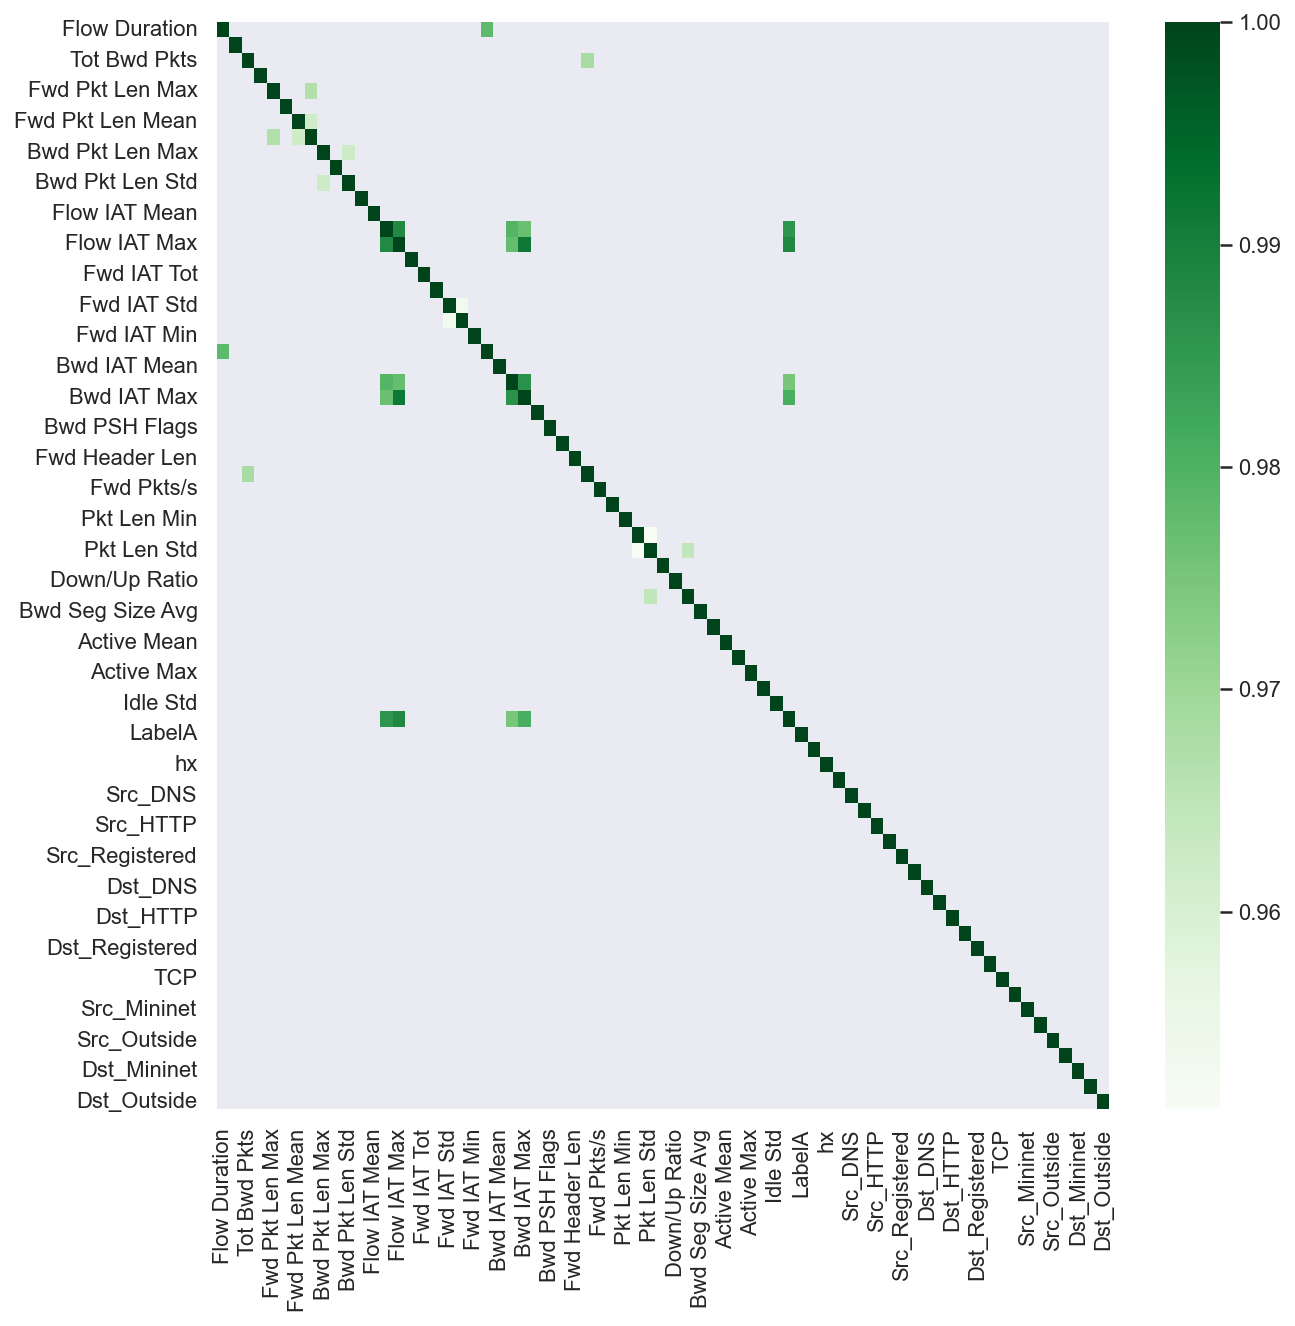

Flow IAT Max      Bwd IAT Max        0.991329
                  Idle Min           0.988220
Flow IAT Std      Flow IAT Max       0.988049
Bwd IAT Std       Bwd IAT Max        0.986331
Flow IAT Std      Idle Min           0.985805
Bwd IAT Max       Idle Min           0.980778
Flow IAT Std      Bwd IAT Std        0.979343
Flow Duration     Bwd IAT Tot        0.978404
Flow IAT Max      Bwd IAT Std        0.977452
Flow IAT Std      Bwd IAT Max        0.976821
Bwd IAT Std       Idle Min           0.975012
Tot Bwd Pkts      Bwd Header Len     0.968349
Fwd Pkt Len Max   Fwd Pkt Len Std    0.966866
Pkt Len Std       Pkt Size Avg       0.964483
Bwd Pkt Len Max   Bwd Pkt Len Std    0.962197
Fwd Pkt Len Mean  Fwd Pkt Len Std    0.961831
Fwd IAT Std       Fwd IAT Max        0.953052
Pkt Len Max       Pkt Len Std        0.951108
dtype: float64

Still have  18 high correlations left
-------------------------------------------------------------
Correlation value is: 0.9913288062176896
Flow IAT Max  f0 has value: 0.0010903854647210576
Bwd IAT Max  f1 has value: 0.0044164296942457
drop Flow IAT Max
########################################################################


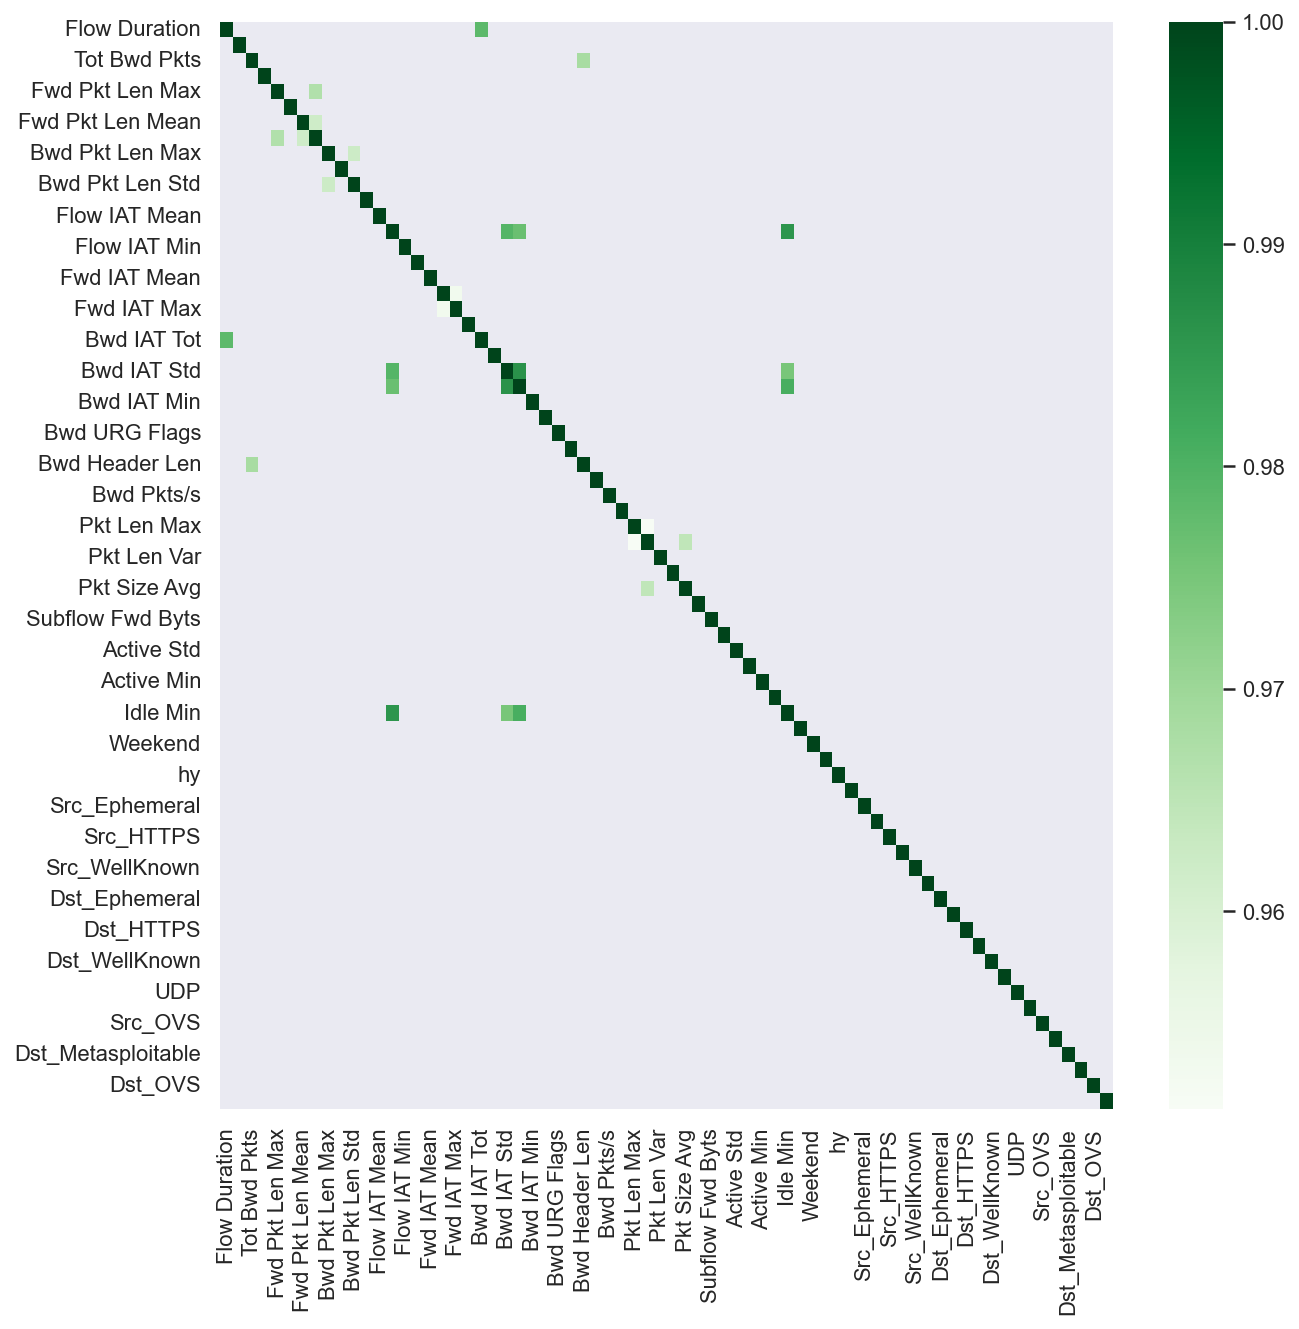

Bwd IAT Std       Bwd IAT Max        0.986331
Flow IAT Std      Idle Min           0.985805
Bwd IAT Max       Idle Min           0.980778
Flow IAT Std      Bwd IAT Std        0.979343
Flow Duration     Bwd IAT Tot        0.978404
Flow IAT Std      Bwd IAT Max        0.976821
Bwd IAT Std       Idle Min           0.975012
Tot Bwd Pkts      Bwd Header Len     0.968349
Fwd Pkt Len Max   Fwd Pkt Len Std    0.966866
Pkt Len Std       Pkt Size Avg       0.964483
Bwd Pkt Len Max   Bwd Pkt Len Std    0.962197
Fwd Pkt Len Mean  Fwd Pkt Len Std    0.961831
Fwd IAT Std       Fwd IAT Max        0.953052
Pkt Len Max       Pkt Len Std        0.951108
dtype: float64

Still have  14 high correlations left
-------------------------------------------------------------
Correlation value is: 0.9863310816183438
Bwd IAT Std  f0 has value: 0.0022353853229739274
Bwd IAT Max  f1 has value: 0.005163604368303448
drop Bwd IAT Std
########################################################################


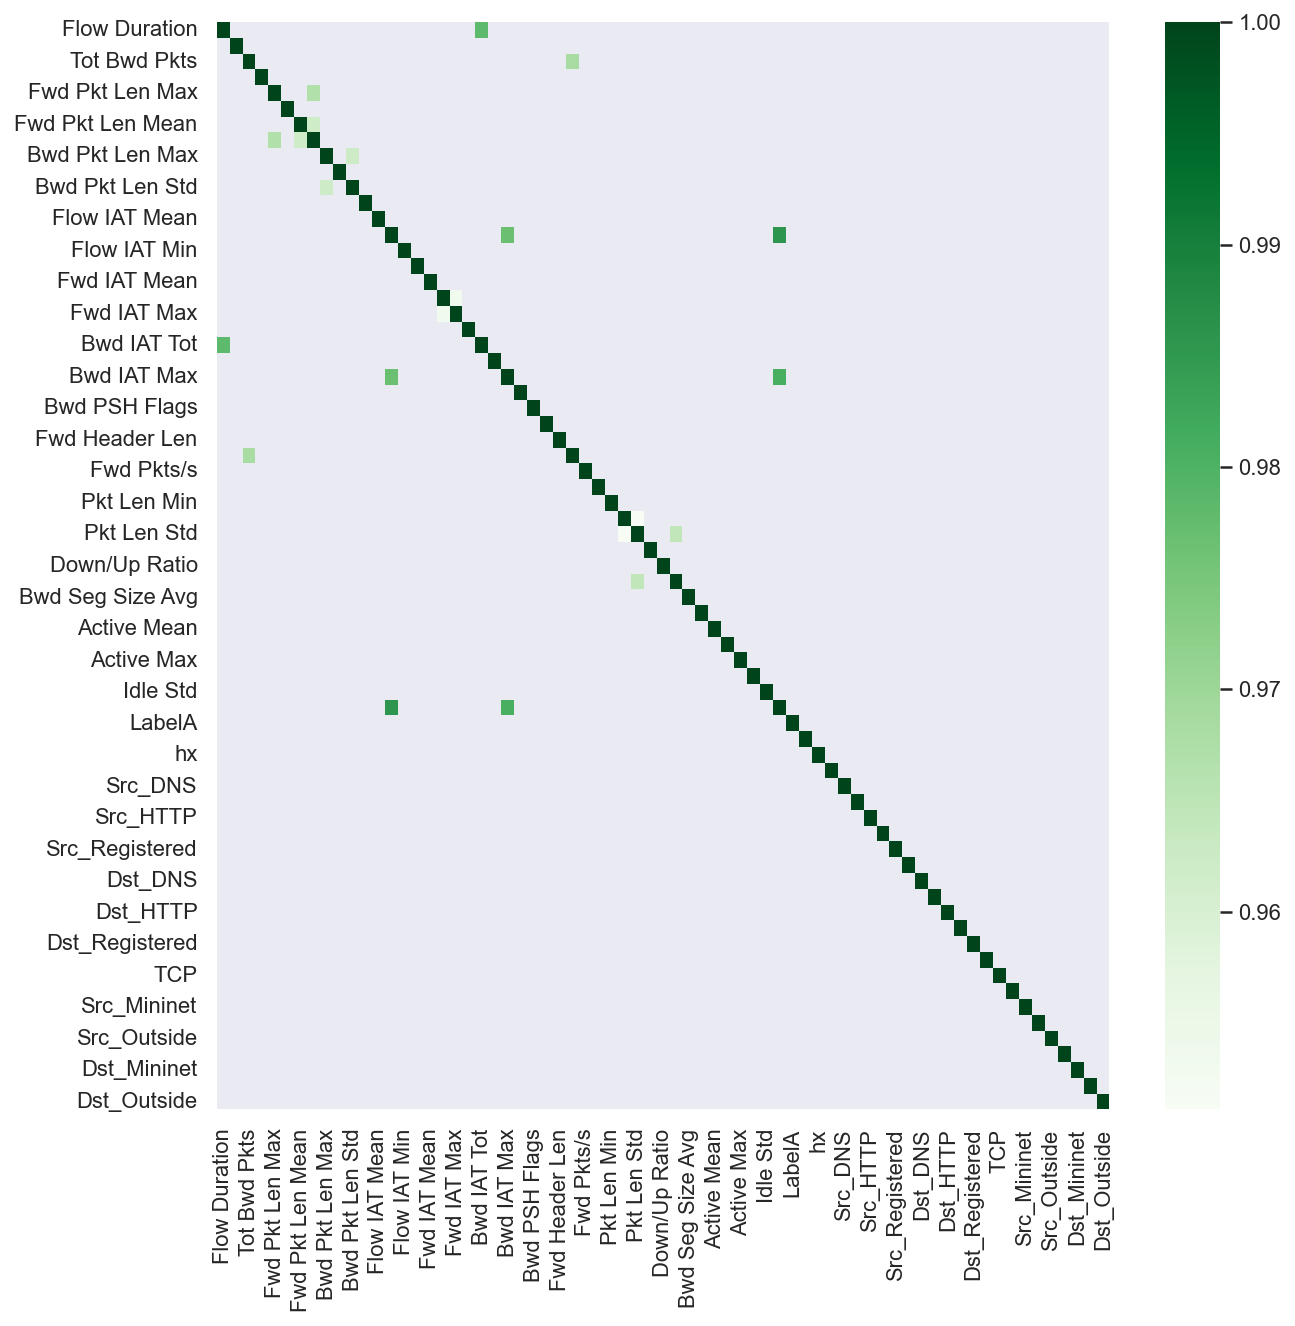

Flow IAT Std      Idle Min           0.985805
Bwd IAT Max       Idle Min           0.980778
Flow Duration     Bwd IAT Tot        0.978404
Flow IAT Std      Bwd IAT Max        0.976821
Tot Bwd Pkts      Bwd Header Len     0.968349
Fwd Pkt Len Max   Fwd Pkt Len Std    0.966866
Pkt Len Std       Pkt Size Avg       0.964483
Bwd Pkt Len Max   Bwd Pkt Len Std    0.962197
Fwd Pkt Len Mean  Fwd Pkt Len Std    0.961831
Fwd IAT Std       Fwd IAT Max        0.953052
Pkt Len Max       Pkt Len Std        0.951108
dtype: float64

Still have  11 high correlations left
-------------------------------------------------------------
Correlation value is: 0.9858054588369058
Flow IAT Std  f0 has value: 0.002620304132054094
Idle Min  f1 has value: 0.0014644793746282883
drop Idle Min
########################################################################


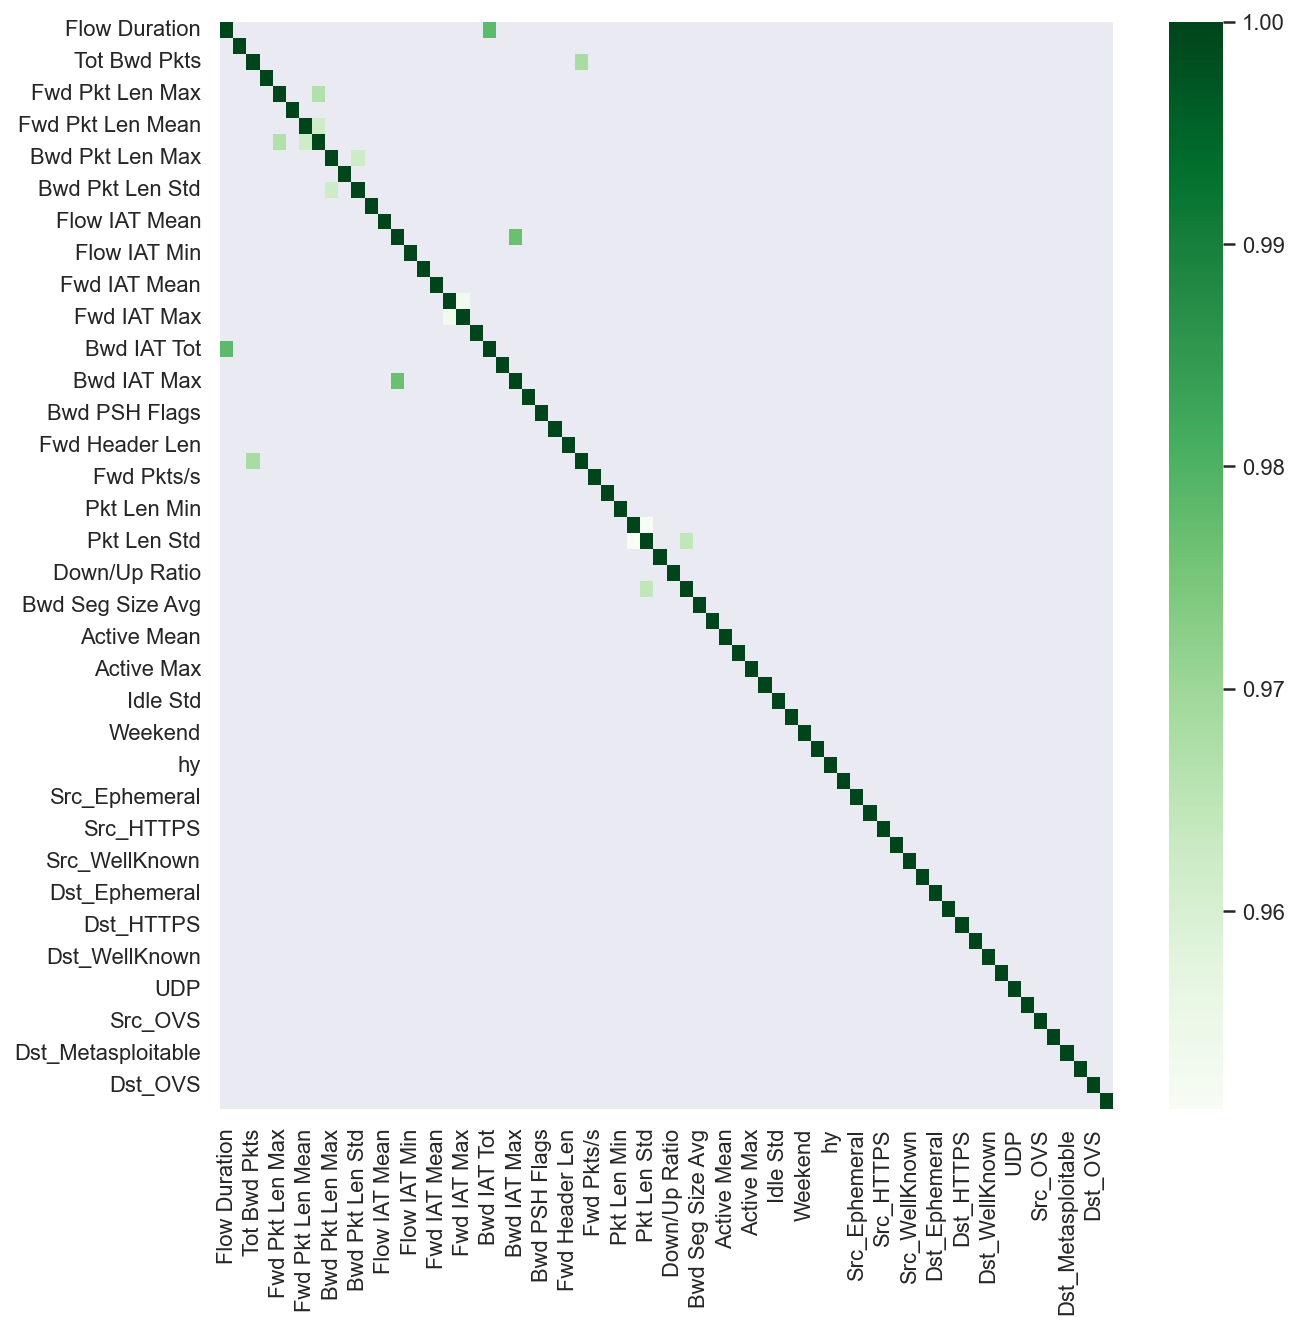

Flow Duration     Bwd IAT Tot        0.978404
Flow IAT Std      Bwd IAT Max        0.976821
Tot Bwd Pkts      Bwd Header Len     0.968349
Fwd Pkt Len Max   Fwd Pkt Len Std    0.966866
Pkt Len Std       Pkt Size Avg       0.964483
Bwd Pkt Len Max   Bwd Pkt Len Std    0.962197
Fwd Pkt Len Mean  Fwd Pkt Len Std    0.961831
Fwd IAT Std       Fwd IAT Max        0.953052
Pkt Len Max       Pkt Len Std        0.951108
dtype: float64

Still have  9 high correlations left
-------------------------------------------------------------
Correlation value is: 0.9784037330213151
Flow Duration  f0 has value: 0.0021342522280120976
Bwd IAT Tot  f1 has value: 0.005210377261069979
drop Flow Duration
########################################################################


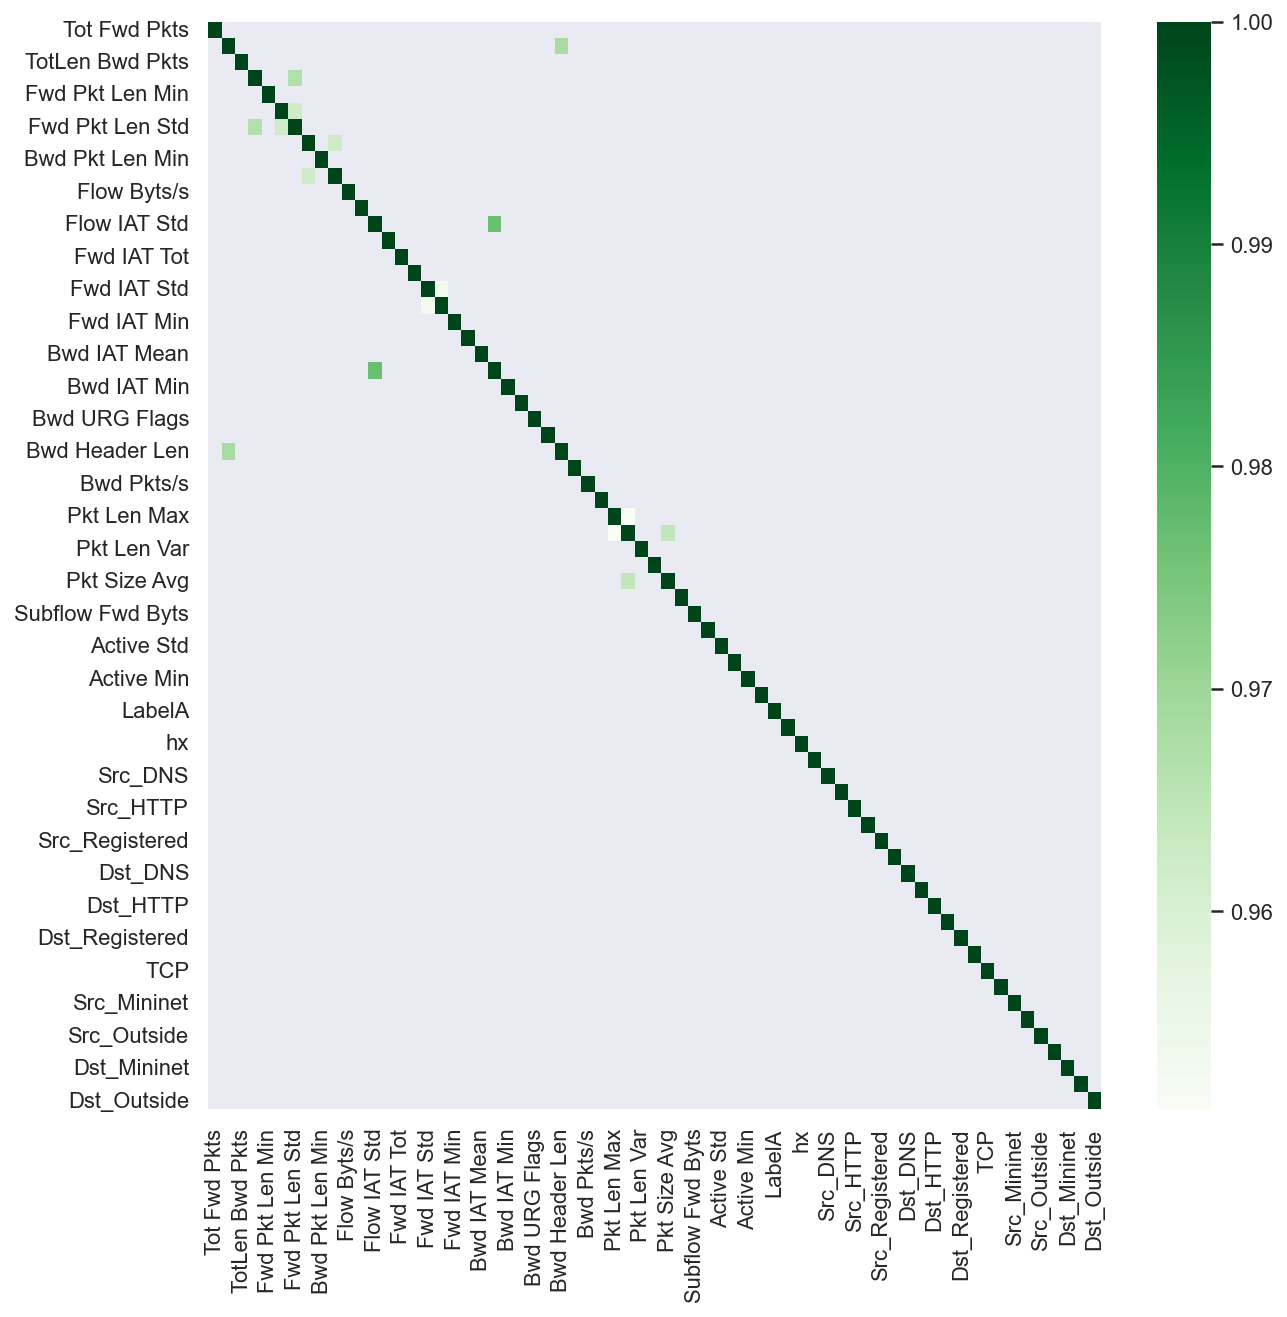

Flow IAT Std      Bwd IAT Max        0.976821
Tot Bwd Pkts      Bwd Header Len     0.968349
Fwd Pkt Len Max   Fwd Pkt Len Std    0.966866
Pkt Len Std       Pkt Size Avg       0.964483
Bwd Pkt Len Max   Bwd Pkt Len Std    0.962197
Fwd Pkt Len Mean  Fwd Pkt Len Std    0.961831
Fwd IAT Std       Fwd IAT Max        0.953052
Pkt Len Max       Pkt Len Std        0.951108
dtype: float64

Still have  8 high correlations left
-------------------------------------------------------------
Correlation value is: 0.9768214338603199
Flow IAT Std  f0 has value: 0.002689686837180062
Bwd IAT Max  f1 has value: 0.0057743652789362465
drop Flow IAT Std
########################################################################


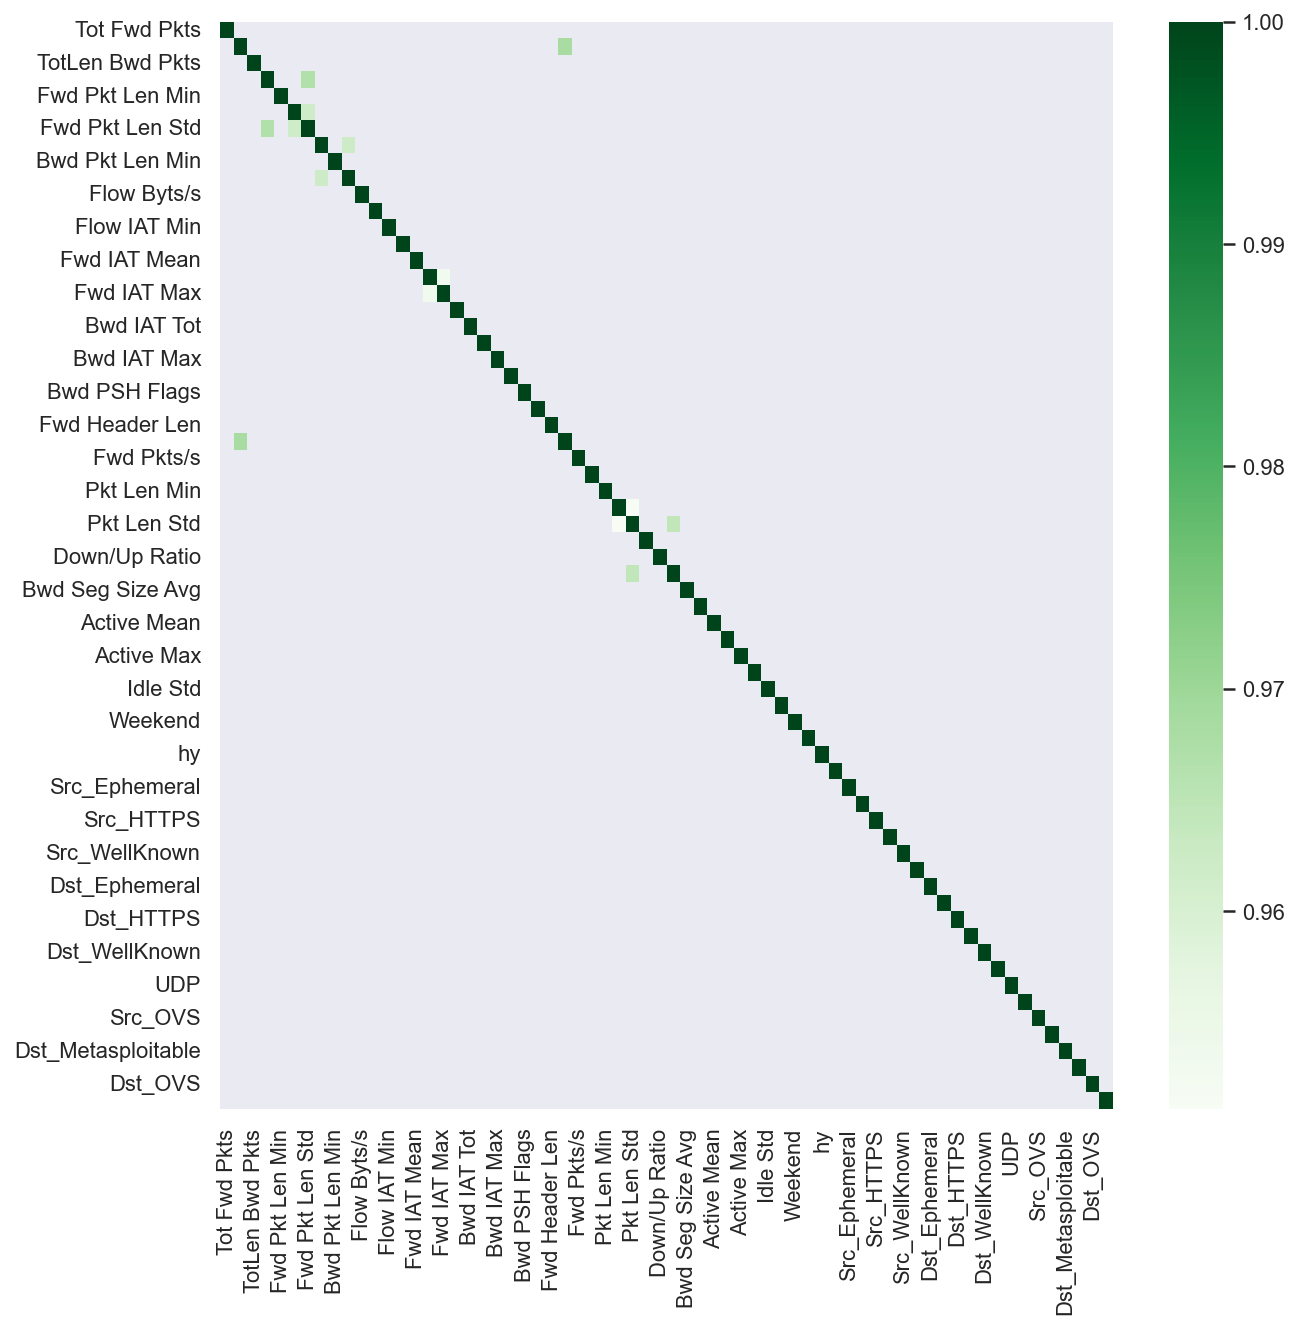

Tot Bwd Pkts      Bwd Header Len     0.968349
Fwd Pkt Len Max   Fwd Pkt Len Std    0.966866
Pkt Len Std       Pkt Size Avg       0.964483
Bwd Pkt Len Max   Bwd Pkt Len Std    0.962197
Fwd Pkt Len Mean  Fwd Pkt Len Std    0.961831
Fwd IAT Std       Fwd IAT Max        0.953052
Pkt Len Max       Pkt Len Std        0.951108
dtype: float64

Still have  7 high correlations left
-------------------------------------------------------------
Correlation value is: 0.9683485025761392
Tot Bwd Pkts  f0 has value: 0.014259753315927097
Bwd Header Len  f1 has value: 0.03049291779089193
drop Tot Bwd Pkts
########################################################################


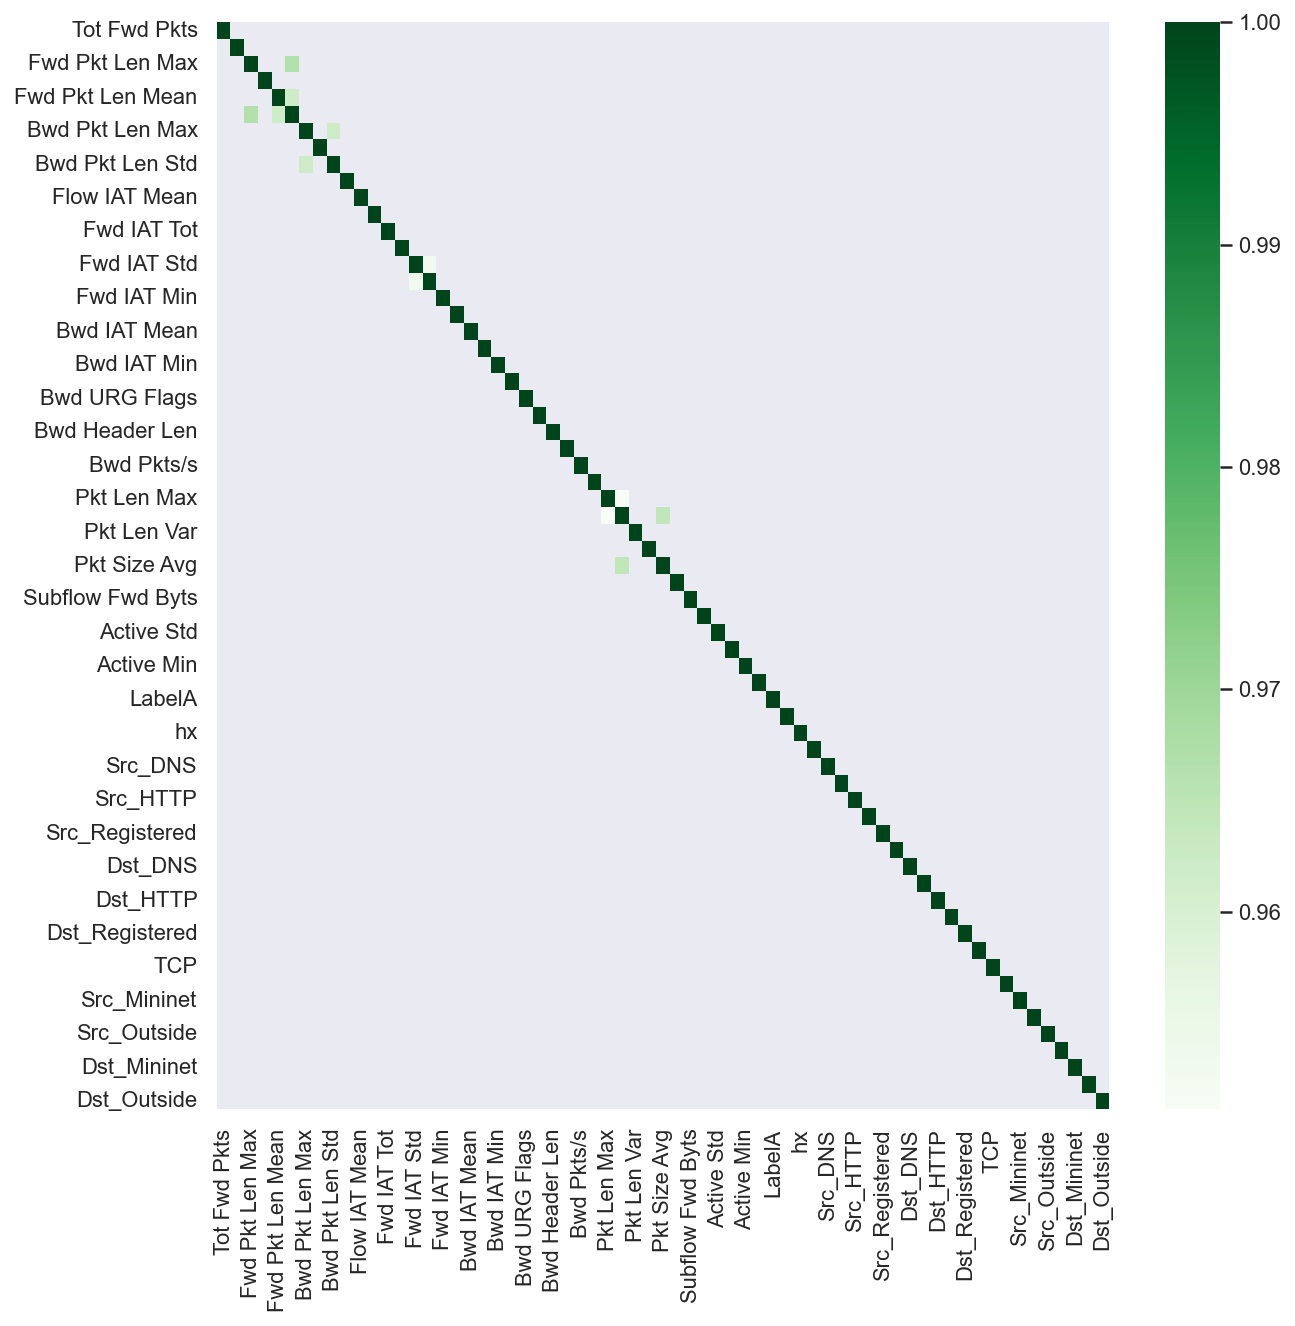

Fwd Pkt Len Max   Fwd Pkt Len Std    0.966866
Pkt Len Std       Pkt Size Avg       0.964483
Bwd Pkt Len Max   Bwd Pkt Len Std    0.962197
Fwd Pkt Len Mean  Fwd Pkt Len Std    0.961831
Fwd IAT Std       Fwd IAT Max        0.953052
Pkt Len Max       Pkt Len Std        0.951108
dtype: float64

Still have  6 high correlations left
-------------------------------------------------------------
Correlation value is: 0.9668656982619471
Fwd Pkt Len Max  f0 has value: 0.015472385551783794
Fwd Pkt Len Std  f1 has value: 0.0026340056721246285
drop Fwd Pkt Len Std
########################################################################


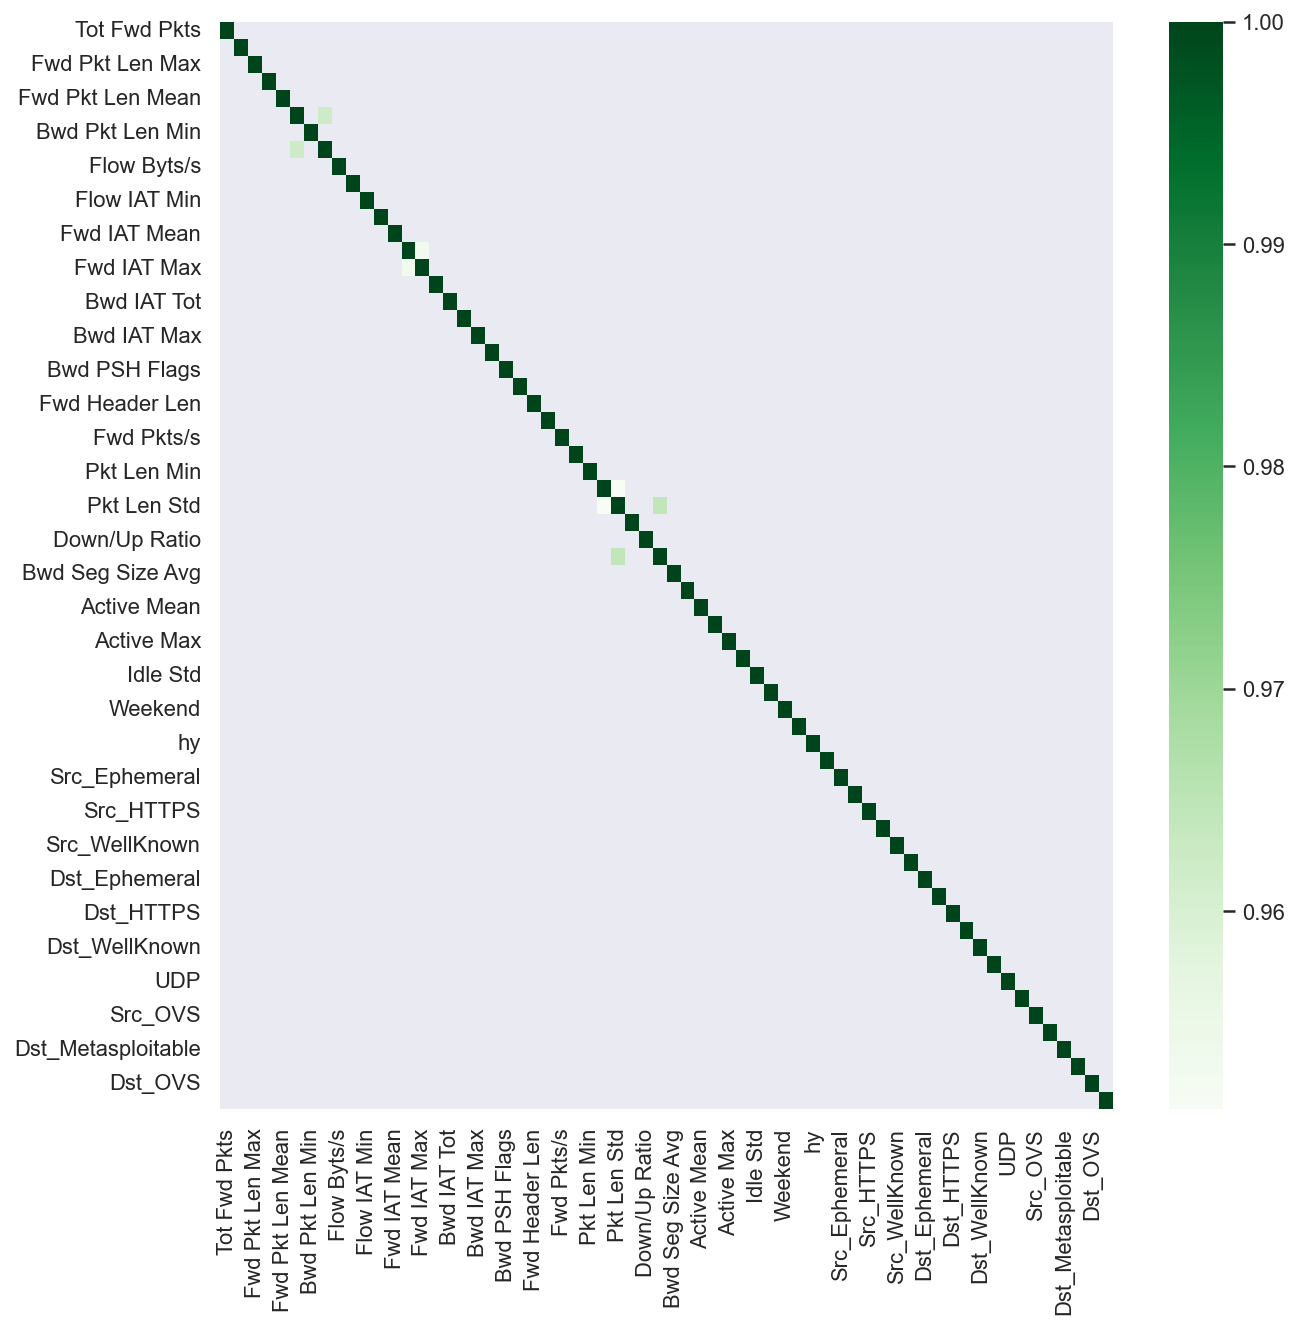

Pkt Len Std      Pkt Size Avg       0.964483
Bwd Pkt Len Max  Bwd Pkt Len Std    0.962197
Fwd IAT Std      Fwd IAT Max        0.953052
Pkt Len Max      Pkt Len Std        0.951108
dtype: float64

Still have  4 high correlations left
-------------------------------------------------------------
Correlation value is: 0.9644827463475314
Pkt Len Std  f0 has value: 0.018342181605440003
Pkt Size Avg  f1 has value: 0.02743507236366474
drop Pkt Len Std
########################################################################


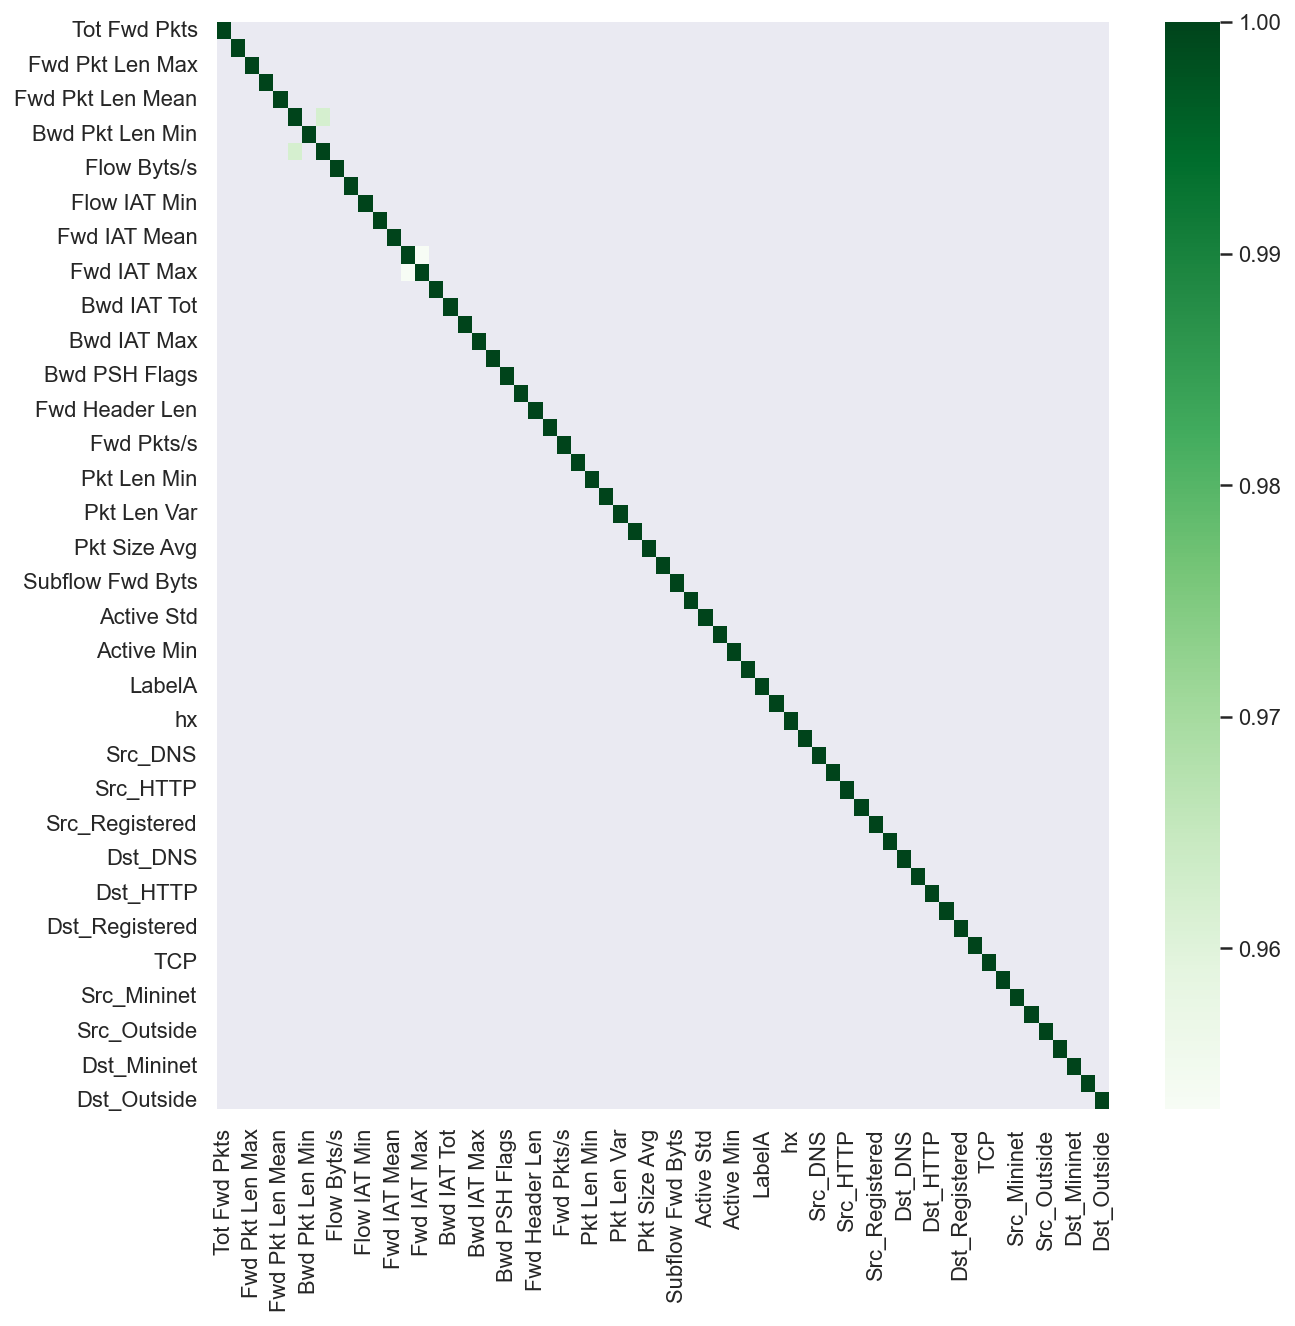

Bwd Pkt Len Max  Bwd Pkt Len Std    0.962197
Fwd IAT Std      Fwd IAT Max        0.953052
dtype: float64

Still have  2 high correlations left
-------------------------------------------------------------
Correlation value is: 0.9621965810668583
Bwd Pkt Len Max  f0 has value: 0.010530799021545351
Bwd Pkt Len Std  f1 has value: 0.007251417594172381
drop Bwd Pkt Len Std
########################################################################


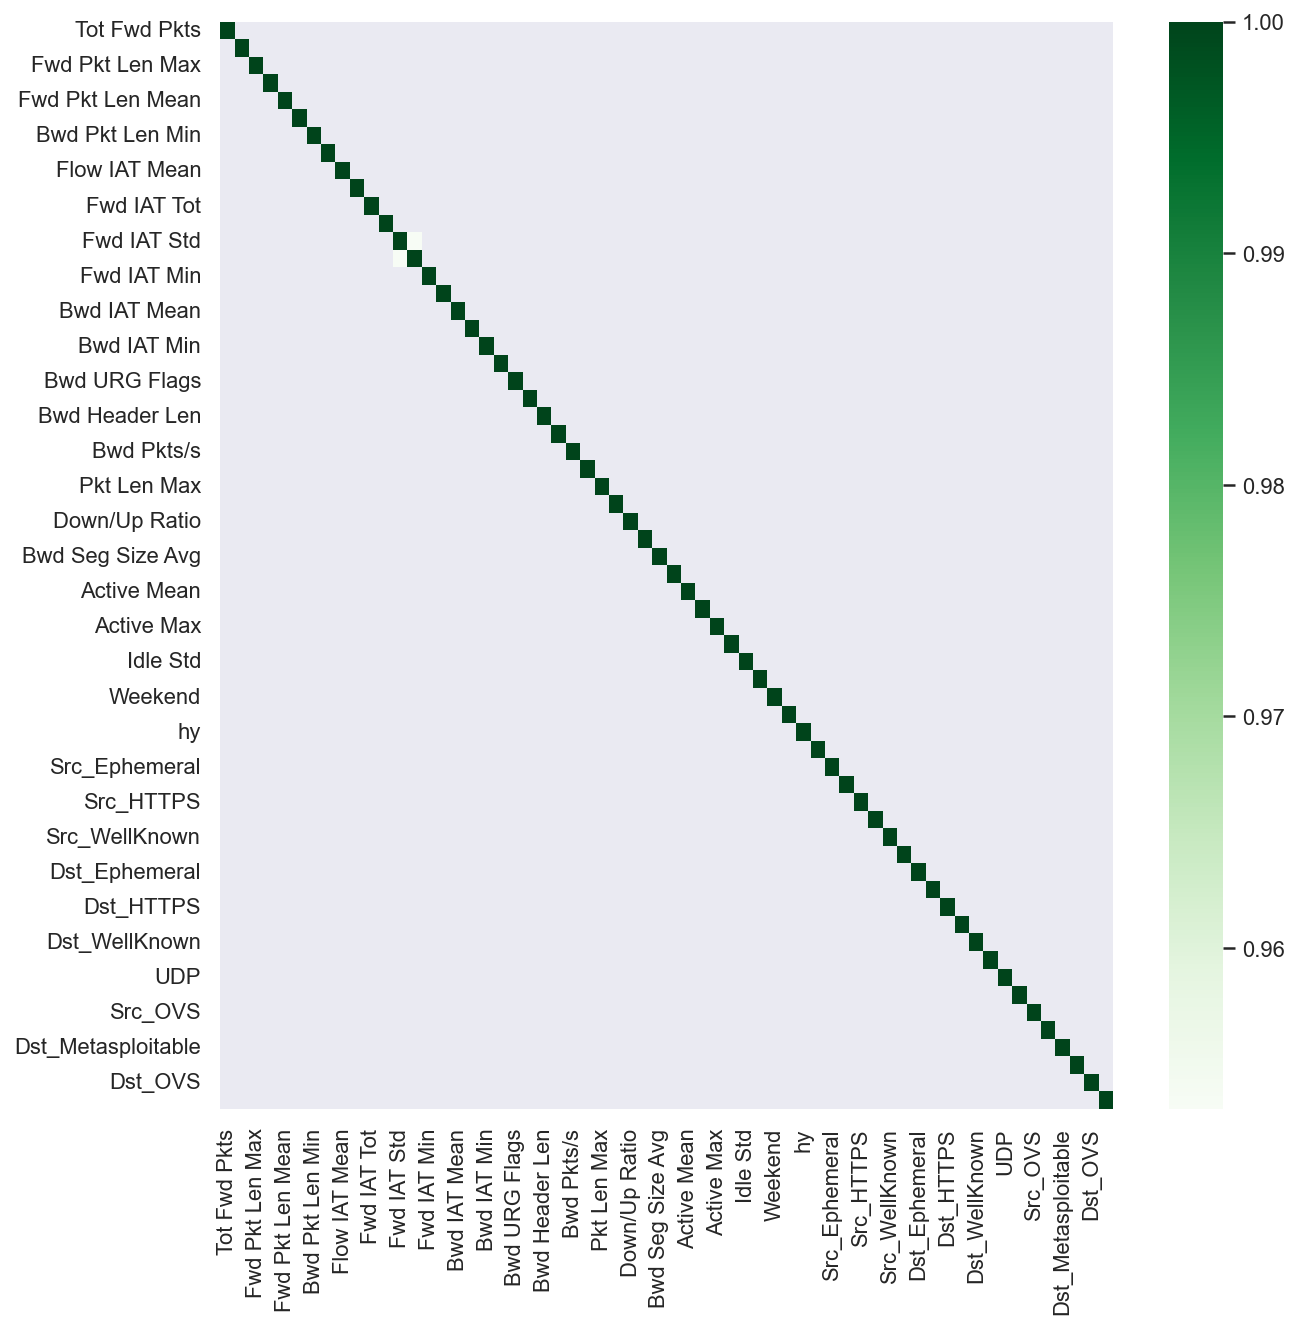

Fwd IAT Std  Fwd IAT Max    0.953052
dtype: float64

Still have  1 high correlations left
-------------------------------------------------------------
Correlation value is: 0.9530516795378022
Fwd IAT Std  f0 has value: 0.004030916568578171
Fwd IAT Max  f1 has value: 0.0077931049436756
drop Fwd IAT Std
########################################################################


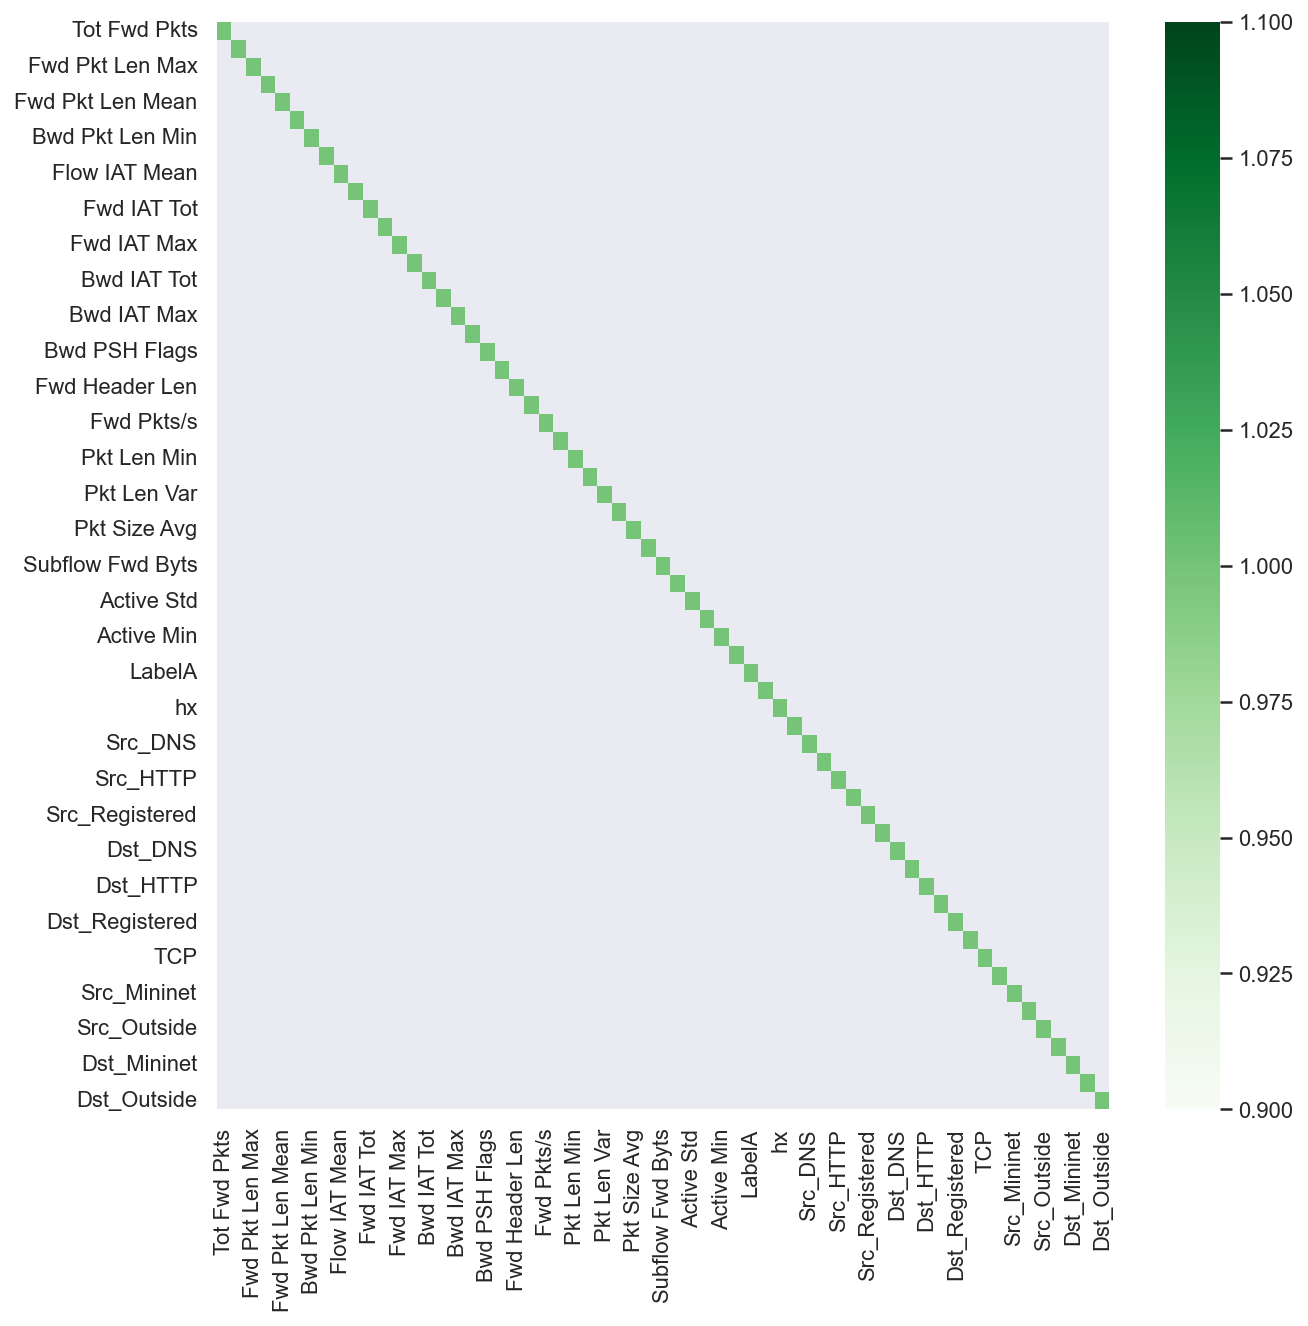

Series([], dtype: float64)

Still have  0 high correlations left
-------------------------------------------------------------
Correlation value is: 0.9482567154258401
Fwd Pkt Len Max  f0 has value: 0.013842785928107584
Fwd Pkt Len Mean  f1 has value: 0.020170971535506475
drop Fwd Pkt Len Max
########################################################################


In [119]:
thresh = 0.95

while st>0:
    X = dft.copy()
    y = X.pop("LabelA")
    #X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,random_state=42)
    forest = RandomForestClassifier(random_state=0)
    forest.fit(X, y)
    ##########################################################################
    cor = dft.corr().abs()
    #print("max corr:",high_cor.max(), ", min corr: ", high_cor.min())
    ############################################################################
    c1 = cor.where(np.triu(np.ones(cor.shape), k=1).astype(bool))
    high_cor = c1.stack().sort_values(ascending=False).drop_duplicates()
    ###################################################################################
    st=(high_cor[high_cor>thresh]).size
    ################Drawing the map##########################################################
    plt.figure(figsize=(10, 10)) 
    sns.heatmap(cor[corr>thresh],cmap="Greens")
    plt.show()
    ##########################################################################
    display(high_cor[high_cor>thresh])

    print("Still have ", st,"high correlations left")
    print("-------------------------------------------------------------")

    ###########################################################################
    important_features_dict = {}
    for idx, val in enumerate(forest.feature_importances_):
        important_features_dict[idx] = val

    important_features_list = sorted(important_features_dict,
                                     key=important_features_dict.get,
                                     reverse=True)
    sortedlist = sorted(important_features_dict.items(), key=operator.itemgetter(1),reverse=True)

    im_names_list=X.columns.values.tolist()
    ifd={}
    for i,j in sortedlist :
        ifd[im_names_list[(i)]]=j

    ###################################################################################
    f0=(high_cor.index[0])[0]
    f1=(high_cor.index[0])[1]
    #################################################################################
    print("Correlation value is:",high_cor.iloc[0])
    print(f0," f0 has value:",ifd[f0])
    print(f1," f1 has value:",ifd[f1])
    if (ifd[f0]>ifd[f1]):
        print("drop",f1)
        dft =dft.drop([f1], axis=1)
    else:
        print("drop",f0)
        dft =dft.drop([f0], axis=1)
    print("########################################################################")
    ###################################################################################


In [121]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336090 entries, 0 to 343888
Data columns (total 60 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Tot Fwd Pkts        336090 non-null  int64  
 1   TotLen Bwd Pkts     336090 non-null  float64
 2   Fwd Pkt Len Min     336090 non-null  int64  
 3   Fwd Pkt Len Mean    336090 non-null  float64
 4   Bwd Pkt Len Max     336090 non-null  int64  
 5   Bwd Pkt Len Min     336090 non-null  int64  
 6   Flow Byts/s         336090 non-null  float64
 7   Flow IAT Mean       336090 non-null  float64
 8   Flow IAT Min        336090 non-null  float64
 9   Fwd IAT Tot         336090 non-null  float64
 10  Fwd IAT Mean        336090 non-null  float64
 11  Fwd IAT Max         336090 non-null  float64
 12  Fwd IAT Min         336090 non-null  float64
 13  Bwd IAT Tot         336090 non-null  float64
 14  Bwd IAT Mean        336090 non-null  float64
 15  Bwd IAT Max         336090 non-nul

# Extract single tree
estimator = forest.estimators_[5]


from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X.columns,
                class_names = dft["LabelA"].values.astype(str),
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
import pydot
(graph,) = pydot.graph_from_dot_file(r'C:\Users\White\Desktop\tfg\tree.dot')
graph.write_png('tree.png')

# Display in jupyter notebook
#from IPython.display import Image
#Image(filename = 'tree.png')


prompt="Choose 1 or 0: "
while True:
    value = input(prompt)
    if value.lower() not in ('1', '0'):
        print("Not an appropriate choice.")
    else:
        break
if value == "1":
    print("Delete f1")

if value == "0":
    print("Delete f0")


In [123]:
dft.to_csv(r"C:\Users\White\Desktop\tfg\generados\dft2.csv", index = None, header=True) 


In [ ]:
dft2 = pd.read_csv (r"C:\Users\White\Desktop\tfg\generados\dftB.csv")

In [ ]:
dft2.sample()

https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e < Isolation forest
https://www.cienciadedatos.net/documentos/py22-deteccion-anomalias-isolation-forest-python.html